## Soiling Intervals Detection

This data set of current-voltage (I-V) curves and associated meteorological data for photovoltaic (PV) modules representing a flat-plate PV for one-year period. These publicly available data are intended to facilitate the validation of existing models for predicting the performance of PV modules and for the development of new and improved models. The data include a wide range of irradiance and temperature conditions representing each season.

The data include the following periods:

• Eugene – December 20, 2012, through January 20, 2014

• Cocoa – January 21, 2011, through March 4, 2012

• Golden – August 14, 2012, through September 24, 2013

In this notebook we are going to study the aforementioned dataset in order to identify periods of underperfoming due to soiling.

#### Loading Libraries

In [1]:
%matplotlib inline
import os,sys
import warnings
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
# from genmod.solarpaper import parse_csv
# from genmod.popu import *
# from genmod.procedure_fitness import *
# from genmod.listes import *
# from genmod.plot_eval import *
from genlib import *


#### Loading dataset

We denote the variables we extract from our datasets.

**poa**: The amount of solar irradiance in watts per square meter received on the PV module surface at the time indicated.

**mod_temp**: PV module back-surface temperature in degrees Celsius at the time indicated, measured behind center of cell near center of PV module.

**power**: Maximum power of PV module in watts at the time indicated.

**humidity**: Relative humidity at the site in percent, nearest 5-second average to the time indicated.

**precipitation**: Accumulated daily total precipitation in millimeters at the time indicated.

**soiling_derate**: Normalized metric comparing daily performance of a PV module to an identical PV module that is cleaned during daily maintenance.

In [2]:
import pandas as pd
filename ='golden.csv'

df=pd.read_csv(filename)
df['timestamp']=pd.to_datetime(df['timestamp'])
df=df.set_index('timestamp')
if filename=='golden.csv':
  df=df.loc[:'2013-06-24']


print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
# print(f'The Features of are set are {df.columns}')
print(f'Shape of our Timeseries: {df.shape}')
df


We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (207, 7)


,poa,mod_temp,power,humidity,precipitation,div,soiling_derate
timestamp,,,,,,,
2012-08-14,0.702845,0.900660,0.612522,0.138939,0.0,0.248621,0.994
2012-08-15,0.460646,0.814200,0.408669,0.094540,0.0,0.335704,0.995
2012-08-16,0.509351,0.695448,0.459634,0.505782,0.0,0.358148,0.995
2012-08-17,0.728656,0.832355,0.650592,0.394974,0.0,0.332674,0.993
2012-08-18,0.798300,0.859112,0.712263,0.222876,0.0,0.305808,0.993
...,...,...,...,...,...,...,...
2013-06-20,0.702163,0.853479,0.615004,0.096175,0.0,0.211933,0.987
2013-06-21,0.440595,0.786854,0.379020,0.091091,0.0,0.198195,0.986
2013-06-22,0.466936,0.744031,0.410957,0.278472,0.0,0.220976,0.990


In [3]:
# df2 = pd.DataFrame(index = pd.date_range('2014-01-21','2014-02-4', freq='D'))
# # df=pd.concat([df,df[:15].reset_index(drop=True).set_index(df2.index)])
# df=pd.concat([df,df2])
# df.soiling_derate=df.soiling_derate.fillna(1)
# df=df.interpolate(method='linear')
df_old=df


In the next cell we are taking advantage of the soiling_derate variable which we can distinguish soiling periods in our sets to create a groundtruth. We filter those periods with **soiling_dates(y=0.991)** function. As **y** goes to 1 the output becomes more sensitive so more periods will be return.

We found 22 Soiling Events with decay less than 0.999 
The indication of the start of a Soil is presented with Bold line
The indication of the end of a Soil is presented with Uncontinious line


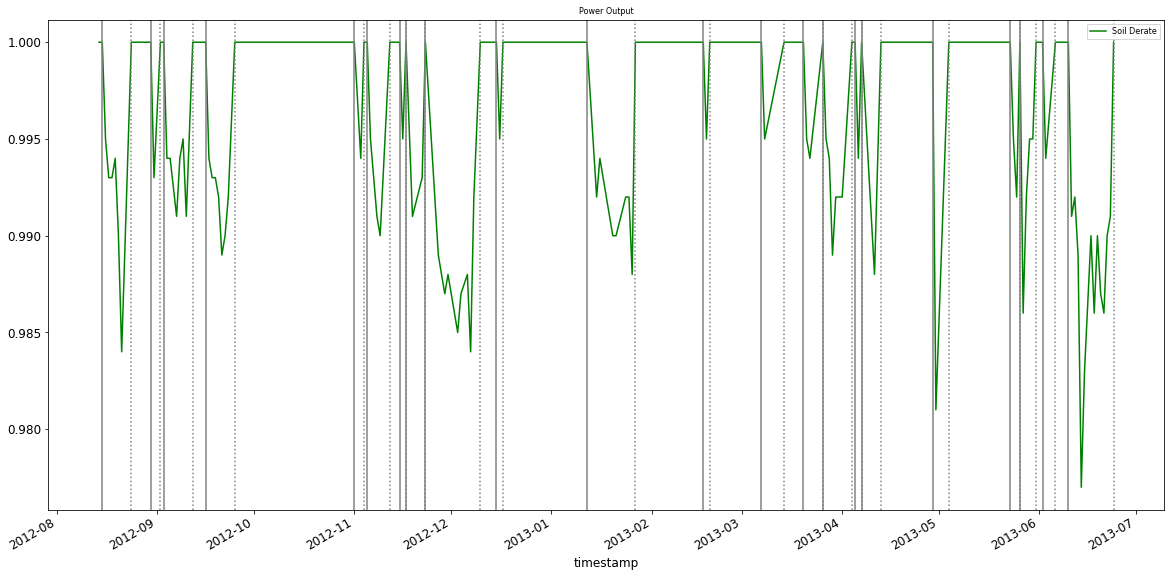

In [4]:
x=0.999
df.soiling_derate[-1]=1
if filename=='golden.csv':
    df.soiling_derate[0]=1
    df.soiling_derate[1]=1
df.soiling_derate[-1]=1
df_soil_output=soiling_dates(df,y=x,plot=True)
# print(f'Here we observe the exact dates which a soiling interval starts and stops')
# print(df_soil_output)

#### Motifs and Genetic algorithm

We rest on the matrixprofile algortihm and more specifically in the motif calculation algorithm by creating a domain of the several parameters it holds. On top of that we use a genetic algorithm in order to optimize the aforementioned
parameters which result into fiding soiling patterns(motifs).
To evaluate our approach, we use as training/testing data any of the Eugene, Cocoa, Golden panels.

### Parameters Initialization

In the next cell we initialize our parameters for a complete genetic run.

**col**: Columns which the matrix profile will be executed

**pop_size**: Population size. In our setting we create individuals (as many as the pop_size) which consist of 6 chromosomes. Namely those chromosomes are:

*min_neighbors*: The minimum number of similar matches a subsequence needs to have in order to be considered a motif.

*max_distance*: For a candidate motif,max_distance is the maximum distance allowed between the motif and the subsequence in order to be considered as a match.

*cutoff*: The largest matrix profile value (distance) that a candidate motif is allowed to have.

*max_matches*: The maximum amount of similar matches of a motif representative to be returned.

*max_motifs*: The maximum number of motifs to return.

*matrix_profile_windows*: Window size to perform the matrix profile.

**num_parents_mating**: Selects the parents using a user defined selection technique. Later, these parents will mate to produce the offspring. The techniques offered are: Selection Mating Pool, Steady State, Rank, Random, Tournament, Roulette Wheel Selection. (num_parents_mating must be always stricter less than pop_size)

**crossover**: Applies the  crossover. It randomly selects a gene at which crossover takes place between the pairs of parents through various techniques. The techniques offered are: Single_point, Two_points, Uniform, Scatter crossover.

**num_mutations**: Mutation changes a number of genes as defined by the num_mutations argument.The changes are random. More techniques to be **updated**.

**num_generations**: Number of genereations(loops) of the algorithm.

**mix_up**: True/False If true in each loop the pareting and crossover techniques are changing randomly.



In [5]:
col=['power']
pop_size = 300
num_parents_mating = 200
num_generations = 300
num_mutations=6
days=0
mix_up=True
#parenting=[smp,sss,ranks,randoms,tournament,rws,sus]
parenting='tournament'
#crossover=[single,twopoint,uni,scatter,old]
crossover='twopoint'
events=len(df_soil_output)

The goal of the procedure is to optimize the starting population through some steps.
1. Initialazing of the starting population.
2. Calculate a fitness function. We create a binary set of soiling & motif periods. In this setting we optimize the recall function from sklearn. We denote with class "1" the soiling and the motif periods, with class "0" when we have no soiling, motif period.

3. For the best output of fitness population we create the parents
4. From parents through crossover function we create the offspring (kids)
5. In order to avoid many identical solutions we mutate the offspring
6. Last step is to pass the offspring in the population for the next generation


#### Train Step

In [6]:
new_population,best_outputs,end_df,alles_df=procedure(df,df_soil_output,pop_size,days,
                                                      num_generations,num_parents_mating,
                                                      num_mutations,col,events,parenting,
                                                      crossover,mix_up)

Features: ['power']
Chromosomes: 6
Soiling Events: 22
Generations: 300
Population :300
Parents: 200


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:16<1:20:48, 16.21s/it]

  1%|          | 2/300 [00:37<1:35:39, 19.26s/it]

  1%|          | 3/300 [01:03<1:51:21, 22.50s/it]

  1%|▏         | 4/300 [01:30<1:58:18, 23.98s/it]

  2%|▏         | 5/300 [01:54<1:58:39, 24.13s/it]

  2%|▏         | 6/300 [02:18<1:57:06, 23.90s/it]

  2%|▏         | 7/300 [02:44<2:00:11, 24.61s/it]

  3%|▎         | 8/300 [03:16<2:12:03, 27.14s/it]

  3%|▎         | 9/300 [03:47<2:17:52, 28.43s/it]

  3%|▎         | 10/300 [04:20<2:23:56, 29.78s/it]

  4%|▎         | 11/300 [04:50<2:23:54, 29.88s/it]

  4%|▍         | 12/300 [05:22<2:25:25, 30.30s/it]

  4%|▍         | 13/300 [05:52<2:25:15, 30.37s/it]

  5%|▍         | 14/300 [06:23<2:25:41, 30.56s/it]

  5%|▌         | 15/300 [06:54<2:25:59, 30.73s/it]

  5%|▌         | 16/300 [07:26<2:26:44, 31.00s/it]

  6%|▌         | 17/300 [07:59<2:29:46, 31.75s/it]

  6%|▌         | 18/300 [08:31<2:29:25, 31.79s/it]

  6%|▋         | 19/300 [09:04<2:30:04, 32.04s/it]

  7%|▋         | 20/300 [09:35<2:28:42, 31.87s/it]

  7%|▋         | 21/300 [10:08<2:28:54, 32.02s/it]

  7%|▋         | 22/300 [10:41<2:29:33, 32.28s/it]

  8%|▊         | 23/300 [11:13<2:28:59, 32.27s/it]

  8%|▊         | 24/300 [11:45<2:27:35, 32.09s/it]

  8%|▊         | 25/300 [12:16<2:26:22, 31.94s/it]

  9%|▊         | 26/300 [12:49<2:26:26, 32.07s/it]

  9%|▉         | 27/300 [13:17<2:21:31, 31.10s/it]

  9%|▉         | 28/300 [13:47<2:18:37, 30.58s/it]

 10%|▉         | 29/300 [14:17<2:17:51, 30.52s/it]

 10%|█         | 30/300 [14:47<2:16:53, 30.42s/it]

 10%|█         | 31/300 [15:18<2:16:55, 30.54s/it]

 11%|█         | 32/300 [15:47<2:14:25, 30.10s/it]

 11%|█         | 33/300 [16:16<2:12:49, 29.85s/it]

 11%|█▏        | 34/300 [16:46<2:11:35, 29.68s/it]

 12%|█▏        | 35/300 [17:15<2:10:53, 29.64s/it]

 12%|█▏        | 36/300 [17:44<2:08:59, 29.32s/it]

 12%|█▏        | 37/300 [18:12<2:07:27, 29.08s/it]

 13%|█▎        | 38/300 [18:42<2:07:35, 29.22s/it]

 13%|█▎        | 39/300 [19:10<2:06:09, 29.00s/it]

 13%|█▎        | 40/300 [19:38<2:03:17, 28.45s/it]

 14%|█▎        | 41/300 [20:07<2:04:41, 28.89s/it]

 14%|█▍        | 42/300 [20:38<2:06:07, 29.33s/it]

 14%|█▍        | 43/300 [21:06<2:04:37, 29.10s/it]

 15%|█▍        | 44/300 [21:35<2:03:40, 28.99s/it]

 15%|█▌        | 45/300 [22:04<2:02:51, 28.91s/it]

 15%|█▌        | 46/300 [22:33<2:02:23, 28.91s/it]

 16%|█▌        | 47/300 [23:04<2:04:33, 29.54s/it]

 16%|█▌        | 48/300 [23:34<2:05:04, 29.78s/it]

 16%|█▋        | 49/300 [24:03<2:03:08, 29.44s/it]

 17%|█▋        | 50/300 [24:31<2:00:33, 28.93s/it]

 17%|█▋        | 51/300 [24:59<1:58:58, 28.67s/it]

 17%|█▋        | 52/300 [25:25<1:55:47, 28.02s/it]

 18%|█▊        | 53/300 [25:52<1:54:35, 27.84s/it]

 18%|█▊        | 54/300 [26:18<1:51:29, 27.19s/it]

 18%|█▊        | 55/300 [26:46<1:51:27, 27.30s/it]

 19%|█▊        | 56/300 [27:13<1:51:18, 27.37s/it]

 19%|█▉        | 57/300 [27:41<1:51:16, 27.48s/it]

 19%|█▉        | 58/300 [28:08<1:50:19, 27.35s/it]

 20%|█▉        | 59/300 [28:36<1:50:31, 27.51s/it]

 20%|██        | 60/300 [29:04<1:50:45, 27.69s/it]

 20%|██        | 61/300 [29:33<1:51:14, 27.93s/it]

 21%|██        | 62/300 [30:01<1:51:43, 28.17s/it]

 21%|██        | 63/300 [30:28<1:49:36, 27.75s/it]

 21%|██▏       | 64/300 [30:55<1:48:49, 27.67s/it]

 22%|██▏       | 65/300 [31:24<1:48:48, 27.78s/it]

 22%|██▏       | 66/300 [31:52<1:48:56, 27.93s/it]

 22%|██▏       | 67/300 [32:18<1:45:57, 27.29s/it]

 23%|██▎       | 68/300 [32:45<1:45:59, 27.41s/it]

 23%|██▎       | 69/300 [33:11<1:43:47, 26.96s/it]

 23%|██▎       | 70/300 [33:37<1:42:15, 26.68s/it]

 24%|██▎       | 71/300 [34:04<1:41:31, 26.60s/it]

 24%|██▍       | 72/300 [34:28<1:38:37, 25.95s/it]

 24%|██▍       | 73/300 [34:54<1:38:08, 25.94s/it]

 25%|██▍       | 74/300 [35:20<1:38:08, 26.05s/it]

 25%|██▌       | 75/300 [35:46<1:37:25, 25.98s/it]

 25%|██▌       | 76/300 [36:13<1:37:52, 26.22s/it]

 26%|██▌       | 77/300 [36:39<1:37:07, 26.13s/it]

 26%|██▌       | 78/300 [37:05<1:36:41, 26.13s/it]

 26%|██▋       | 79/300 [37:29<1:33:41, 25.44s/it]

 27%|██▋       | 80/300 [37:54<1:32:54, 25.34s/it]

 27%|██▋       | 81/300 [38:19<1:31:53, 25.18s/it]

 27%|██▋       | 82/300 [38:44<1:31:52, 25.29s/it]

 28%|██▊       | 83/300 [39:11<1:33:10, 25.76s/it]

 28%|██▊       | 84/300 [39:37<1:32:39, 25.74s/it]

 28%|██▊       | 85/300 [40:04<1:34:09, 26.28s/it]

 29%|██▊       | 86/300 [40:33<1:36:31, 27.06s/it]

 29%|██▉       | 87/300 [41:02<1:37:37, 27.50s/it]

 29%|██▉       | 88/300 [41:28<1:36:04, 27.19s/it]

 30%|██▉       | 89/300 [41:56<1:36:42, 27.50s/it]

 30%|███       | 90/300 [42:24<1:36:06, 27.46s/it]

 30%|███       | 91/300 [42:52<1:36:39, 27.75s/it]

 31%|███       | 92/300 [43:19<1:35:07, 27.44s/it]

 31%|███       | 93/300 [43:46<1:34:05, 27.27s/it]

 31%|███▏      | 94/300 [44:14<1:35:00, 27.67s/it]

 32%|███▏      | 95/300 [44:44<1:36:08, 28.14s/it]

 32%|███▏      | 96/300 [45:11<1:34:37, 27.83s/it]

 32%|███▏      | 97/300 [45:39<1:34:08, 27.83s/it]

 33%|███▎      | 98/300 [46:04<1:31:36, 27.21s/it]

 33%|███▎      | 99/300 [46:33<1:32:10, 27.51s/it]

 33%|███▎      | 100/300 [47:01<1:32:23, 27.72s/it]

 34%|███▎      | 101/300 [47:27<1:30:53, 27.40s/it]

 34%|███▍      | 102/300 [47:55<1:30:42, 27.49s/it]

 34%|███▍      | 103/300 [48:22<1:29:42, 27.32s/it]

 35%|███▍      | 104/300 [48:47<1:27:12, 26.70s/it]

 35%|███▌      | 105/300 [49:14<1:26:54, 26.74s/it]

 35%|███▌      | 106/300 [49:41<1:26:44, 26.82s/it]

 36%|███▌      | 107/300 [50:08<1:26:18, 26.83s/it]

 36%|███▌      | 108/300 [50:34<1:25:19, 26.66s/it]

 36%|███▋      | 109/300 [50:59<1:23:07, 26.12s/it]

 37%|███▋      | 110/300 [51:25<1:22:20, 26.00s/it]

 37%|███▋      | 111/300 [51:51<1:22:14, 26.11s/it]

 37%|███▋      | 112/300 [52:16<1:20:39, 25.74s/it]

 38%|███▊      | 113/300 [52:43<1:20:52, 25.95s/it]

 38%|███▊      | 114/300 [53:09<1:20:33, 25.99s/it]

 38%|███▊      | 115/300 [53:35<1:20:04, 25.97s/it]

 39%|███▊      | 116/300 [54:02<1:21:01, 26.42s/it]

 39%|███▉      | 117/300 [54:29<1:21:04, 26.58s/it]

 39%|███▉      | 118/300 [54:53<1:18:28, 25.87s/it]

 40%|███▉      | 119/300 [55:19<1:18:15, 25.94s/it]

 40%|████      | 120/300 [55:44<1:16:47, 25.60s/it]

 40%|████      | 121/300 [56:09<1:15:29, 25.31s/it]

 41%|████      | 122/300 [56:34<1:14:50, 25.23s/it]

 41%|████      | 123/300 [57:01<1:15:53, 25.72s/it]

 41%|████▏     | 124/300 [57:26<1:15:33, 25.76s/it]

 42%|████▏     | 125/300 [57:52<1:15:12, 25.79s/it]

 42%|████▏     | 126/300 [58:19<1:15:18, 25.97s/it]

 42%|████▏     | 127/300 [58:43<1:13:46, 25.58s/it]

 43%|████▎     | 128/300 [59:07<1:11:43, 25.02s/it]

 43%|████▎     | 129/300 [59:32<1:11:32, 25.11s/it]

 43%|████▎     | 130/300 [59:56<1:09:34, 24.56s/it]

 44%|████▎     | 131/300 [1:00:19<1:08:12, 24.22s/it]

 44%|████▍     | 132/300 [1:00:42<1:06:24, 23.72s/it]

 44%|████▍     | 133/300 [1:01:04<1:04:47, 23.28s/it]

 45%|████▍     | 134/300 [1:01:26<1:03:32, 22.97s/it]

 45%|████▌     | 135/300 [1:01:49<1:03:24, 23.06s/it]

 45%|████▌     | 136/300 [1:02:16<1:05:32, 23.98s/it]

 46%|████▌     | 137/300 [1:02:43<1:07:56, 25.01s/it]

 46%|████▌     | 138/300 [1:03:09<1:08:22, 25.33s/it]

 46%|████▋     | 139/300 [1:03:36<1:08:54, 25.68s/it]

 47%|████▋     | 140/300 [1:04:02<1:09:26, 26.04s/it]

 47%|████▋     | 141/300 [1:04:28<1:09:01, 26.05s/it]

 47%|████▋     | 142/300 [1:04:56<1:09:24, 26.36s/it]

 48%|████▊     | 143/300 [1:05:23<1:10:04, 26.78s/it]

 48%|████▊     | 144/300 [1:05:51<1:10:22, 27.07s/it]

 48%|████▊     | 145/300 [1:06:18<1:10:04, 27.13s/it]

 49%|████▊     | 146/300 [1:06:46<1:10:19, 27.40s/it]

 49%|████▉     | 147/300 [1:07:15<1:10:30, 27.65s/it]

 49%|████▉     | 148/300 [1:07:42<1:10:10, 27.70s/it]

 50%|████▉     | 149/300 [1:08:12<1:10:58, 28.20s/it]

 50%|█████     | 150/300 [1:08:41<1:11:26, 28.58s/it]

 50%|█████     | 151/300 [1:09:10<1:10:56, 28.57s/it]

 51%|█████     | 152/300 [1:09:38<1:09:54, 28.34s/it]

 51%|█████     | 153/300 [1:10:07<1:10:07, 28.62s/it]

 51%|█████▏    | 154/300 [1:10:36<1:09:49, 28.70s/it]

 52%|█████▏    | 155/300 [1:11:04<1:08:51, 28.49s/it]

 52%|█████▏    | 156/300 [1:11:32<1:08:11, 28.41s/it]

 52%|█████▏    | 157/300 [1:12:00<1:07:25, 28.29s/it]

 53%|█████▎    | 158/300 [1:12:29<1:07:06, 28.36s/it]

 53%|█████▎    | 159/300 [1:12:56<1:05:59, 28.08s/it]

 53%|█████▎    | 160/300 [1:13:24<1:05:24, 28.03s/it]

 54%|█████▎    | 161/300 [1:13:52<1:05:20, 28.21s/it]

 54%|█████▍    | 162/300 [1:14:18<1:03:21, 27.54s/it]

 54%|█████▍    | 163/300 [1:14:45<1:02:22, 27.32s/it]

 55%|█████▍    | 164/300 [1:15:12<1:01:48, 27.27s/it]

 55%|█████▌    | 165/300 [1:15:39<1:00:57, 27.09s/it]

 55%|█████▌    | 166/300 [1:16:05<59:38, 26.70s/it]  

 56%|█████▌    | 167/300 [1:16:32<59:25, 26.81s/it]

 56%|█████▌    | 168/300 [1:16:57<58:03, 26.39s/it]

 56%|█████▋    | 169/300 [1:17:23<57:10, 26.19s/it]

 57%|█████▋    | 170/300 [1:17:50<57:18, 26.45s/it]

 57%|█████▋    | 171/300 [1:18:17<57:07, 26.57s/it]

 57%|█████▋    | 172/300 [1:18:45<57:22, 26.90s/it]

 58%|█████▊    | 173/300 [1:19:13<57:35, 27.21s/it]

 58%|█████▊    | 174/300 [1:19:40<57:00, 27.15s/it]

 58%|█████▊    | 175/300 [1:20:07<56:53, 27.31s/it]

 59%|█████▊    | 176/300 [1:20:36<57:01, 27.59s/it]

 59%|█████▉    | 177/300 [1:21:04<57:14, 27.93s/it]

 59%|█████▉    | 178/300 [1:21:32<56:26, 27.76s/it]

 60%|█████▉    | 179/300 [1:21:59<55:44, 27.64s/it]

 60%|██████    | 180/300 [1:22:26<54:56, 27.47s/it]

 60%|██████    | 181/300 [1:22:53<54:17, 27.37s/it]

 61%|██████    | 182/300 [1:23:22<54:33, 27.74s/it]

 61%|██████    | 183/300 [1:23:48<53:10, 27.27s/it]

 61%|██████▏   | 184/300 [1:24:16<52:59, 27.41s/it]

 62%|██████▏   | 185/300 [1:24:44<52:50, 27.57s/it]

 62%|██████▏   | 186/300 [1:25:10<51:52, 27.31s/it]

 62%|██████▏   | 187/300 [1:25:37<51:07, 27.14s/it]

 63%|██████▎   | 188/300 [1:26:05<51:09, 27.40s/it]

 63%|██████▎   | 189/300 [1:26:33<51:14, 27.69s/it]

 63%|██████▎   | 190/300 [1:27:02<51:21, 28.02s/it]

 64%|██████▎   | 191/300 [1:27:30<50:43, 27.92s/it]

 64%|██████▍   | 192/300 [1:27:58<50:06, 27.84s/it]

 64%|██████▍   | 193/300 [1:28:26<49:43, 27.88s/it]

 65%|██████▍   | 194/300 [1:28:53<49:15, 27.88s/it]

 65%|██████▌   | 195/300 [1:29:20<48:13, 27.55s/it]

 65%|██████▌   | 196/300 [1:29:47<47:27, 27.38s/it]

 66%|██████▌   | 197/300 [1:30:14<46:36, 27.15s/it]

 66%|██████▌   | 198/300 [1:30:41<46:02, 27.08s/it]

 66%|██████▋   | 199/300 [1:31:07<45:03, 26.77s/it]

 67%|██████▋   | 200/300 [1:31:34<44:39, 26.80s/it]

 67%|██████▋   | 201/300 [1:32:00<44:00, 26.67s/it]

 67%|██████▋   | 202/300 [1:32:26<43:09, 26.42s/it]

 68%|██████▊   | 203/300 [1:32:53<43:15, 26.76s/it]

 68%|██████▊   | 204/300 [1:33:22<43:52, 27.42s/it]

 68%|██████▊   | 205/300 [1:33:50<43:38, 27.56s/it]

 69%|██████▊   | 206/300 [1:34:17<42:58, 27.43s/it]

 69%|██████▉   | 207/300 [1:34:46<43:03, 27.78s/it]

 69%|██████▉   | 208/300 [1:35:14<42:51, 27.95s/it]

 70%|██████▉   | 209/300 [1:35:44<42:59, 28.35s/it]

 70%|███████   | 210/300 [1:36:14<43:18, 28.88s/it]

 70%|███████   | 211/300 [1:36:43<43:11, 29.11s/it]

 71%|███████   | 212/300 [1:37:13<42:42, 29.12s/it]

 71%|███████   | 213/300 [1:37:42<42:21, 29.21s/it]

 71%|███████▏  | 214/300 [1:38:10<41:23, 28.88s/it]

 72%|███████▏  | 215/300 [1:38:39<40:51, 28.84s/it]

 72%|███████▏  | 216/300 [1:39:07<40:03, 28.62s/it]

 72%|███████▏  | 217/300 [1:39:37<40:09, 29.03s/it]

 73%|███████▎  | 218/300 [1:40:06<39:40, 29.03s/it]

 73%|███████▎  | 219/300 [1:40:35<39:20, 29.14s/it]

 73%|███████▎  | 220/300 [1:41:04<38:35, 28.95s/it]

 74%|███████▎  | 221/300 [1:41:32<37:56, 28.82s/it]

 74%|███████▍  | 222/300 [1:41:59<36:33, 28.12s/it]

 74%|███████▍  | 223/300 [1:42:27<35:56, 28.00s/it]

 75%|███████▍  | 224/300 [1:42:54<35:22, 27.93s/it]

 75%|███████▌  | 225/300 [1:43:22<34:54, 27.93s/it]

 75%|███████▌  | 226/300 [1:43:49<34:10, 27.71s/it]

 76%|███████▌  | 227/300 [1:44:16<33:18, 27.38s/it]

 76%|███████▌  | 228/300 [1:44:43<32:52, 27.40s/it]

 76%|███████▋  | 229/300 [1:45:12<32:51, 27.76s/it]

 77%|███████▋  | 230/300 [1:45:39<32:07, 27.54s/it]

 77%|███████▋  | 231/300 [1:46:06<31:27, 27.35s/it]

 77%|███████▋  | 232/300 [1:46:34<31:20, 27.66s/it]

 78%|███████▊  | 233/300 [1:47:03<31:20, 28.06s/it]

 78%|███████▊  | 234/300 [1:47:31<30:41, 27.91s/it]

 78%|███████▊  | 235/300 [1:47:59<30:20, 28.00s/it]

 79%|███████▊  | 236/300 [1:48:26<29:37, 27.77s/it]

 79%|███████▉  | 237/300 [1:48:56<29:34, 28.17s/it]

 79%|███████▉  | 238/300 [1:49:24<29:19, 28.39s/it]

 80%|███████▉  | 239/300 [1:49:54<29:20, 28.86s/it]

 80%|████████  | 240/300 [1:50:24<29:09, 29.16s/it]

 80%|████████  | 241/300 [1:50:54<28:48, 29.30s/it]

 81%|████████  | 242/300 [1:51:23<28:14, 29.21s/it]

 81%|████████  | 243/300 [1:51:52<27:46, 29.23s/it]

 81%|████████▏ | 244/300 [1:52:22<27:20, 29.29s/it]

 82%|████████▏ | 245/300 [1:52:53<27:19, 29.81s/it]

 82%|████████▏ | 246/300 [1:53:22<26:37, 29.59s/it]

 82%|████████▏ | 247/300 [1:53:51<26:05, 29.54s/it]

 83%|████████▎ | 248/300 [1:54:19<25:15, 29.15s/it]

 83%|████████▎ | 249/300 [1:54:48<24:39, 29.01s/it]

 83%|████████▎ | 250/300 [1:55:17<24:09, 28.99s/it]

 84%|████████▎ | 251/300 [1:55:47<23:55, 29.30s/it]

 84%|████████▍ | 252/300 [1:56:16<23:22, 29.23s/it]

 84%|████████▍ | 253/300 [1:56:46<23:00, 29.38s/it]

 85%|████████▍ | 254/300 [1:57:16<22:41, 29.60s/it]

 85%|████████▌ | 255/300 [1:57:46<22:22, 29.83s/it]

 85%|████████▌ | 256/300 [1:58:17<21:58, 29.96s/it]

 86%|████████▌ | 257/300 [1:58:46<21:27, 29.94s/it]

 86%|████████▌ | 258/300 [1:59:16<20:53, 29.85s/it]

 86%|████████▋ | 259/300 [1:59:47<20:32, 30.05s/it]

 87%|████████▋ | 260/300 [2:00:17<20:00, 30.02s/it]

 87%|████████▋ | 261/300 [2:00:46<19:29, 29.99s/it]

 87%|████████▋ | 262/300 [2:01:17<19:04, 30.13s/it]

 88%|████████▊ | 263/300 [2:01:47<18:34, 30.11s/it]

 88%|████████▊ | 264/300 [2:02:18<18:10, 30.29s/it]

 88%|████████▊ | 265/300 [2:02:46<17:22, 29.78s/it]

 89%|████████▊ | 266/300 [2:03:16<16:47, 29.64s/it]

 89%|████████▉ | 267/300 [2:03:45<16:16, 29.61s/it]

 89%|████████▉ | 268/300 [2:04:14<15:44, 29.51s/it]

 90%|████████▉ | 269/300 [2:04:43<15:09, 29.32s/it]

 90%|█████████ | 270/300 [2:05:14<14:55, 29.84s/it]

 90%|█████████ | 271/300 [2:05:45<14:34, 30.14s/it]

 91%|█████████ | 272/300 [2:06:15<14:03, 30.11s/it]

 91%|█████████ | 273/300 [2:06:45<13:33, 30.12s/it]

 91%|█████████▏| 274/300 [2:07:15<12:55, 29.83s/it]

 92%|█████████▏| 275/300 [2:07:43<12:16, 29.48s/it]

 92%|█████████▏| 276/300 [2:08:12<11:39, 29.14s/it]

 92%|█████████▏| 277/300 [2:08:41<11:15, 29.36s/it]

 93%|█████████▎| 278/300 [2:09:11<10:44, 29.30s/it]

 93%|█████████▎| 279/300 [2:09:39<10:12, 29.18s/it]

 93%|█████████▎| 280/300 [2:10:09<09:43, 29.19s/it]

 94%|█████████▎| 281/300 [2:10:38<09:16, 29.29s/it]

 94%|█████████▍| 282/300 [2:11:08<08:50, 29.46s/it]

 94%|█████████▍| 283/300 [2:11:38<08:24, 29.69s/it]

 95%|█████████▍| 284/300 [2:12:09<07:58, 29.92s/it]

 95%|█████████▌| 285/300 [2:12:39<07:31, 30.08s/it]

 95%|█████████▌| 286/300 [2:13:07<06:52, 29.45s/it]

 96%|█████████▌| 287/300 [2:13:36<06:20, 29.30s/it]

 96%|█████████▌| 288/300 [2:14:05<05:51, 29.28s/it]

 96%|█████████▋| 289/300 [2:14:35<05:23, 29.38s/it]

 97%|█████████▋| 290/300 [2:15:05<04:55, 29.60s/it]

 97%|█████████▋| 291/300 [2:15:34<04:25, 29.48s/it]

 97%|█████████▋| 292/300 [2:16:03<03:54, 29.37s/it]

 98%|█████████▊| 293/300 [2:16:32<03:24, 29.15s/it]

 98%|█████████▊| 294/300 [2:17:01<02:54, 29.14s/it]

 98%|█████████▊| 295/300 [2:17:30<02:24, 28.90s/it]

 99%|█████████▊| 296/300 [2:17:58<01:54, 28.75s/it]

 99%|█████████▉| 297/300 [2:18:27<01:26, 28.77s/it]

 99%|█████████▉| 298/300 [2:18:57<00:58, 29.11s/it]

100%|█████████▉| 299/300 [2:19:26<00:29, 29.25s/it]

100%|██████████| 300/300 [2:19:56<00:00, 29.42s/it]

100%|██████████| 300/300 [2:19:56<00:00, 27.99s/it]

Time to complete: 8396.53seconds


:The individual which max the F1 function is: 1
Best solution fitness :  0.7229729729729729


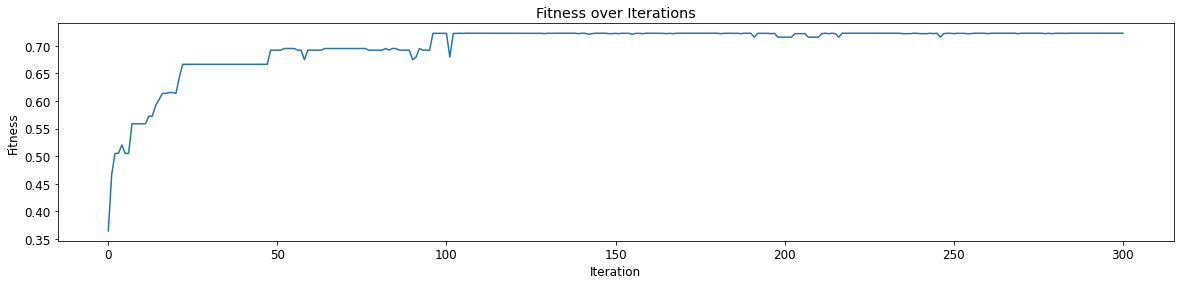

Shape of Result Frame
(2456, 17)


In [7]:
# print(best_outputs)
fitness,alles_df1 = fiteness_fun(df,df_soil_output,days,new_population,col)
best_outputs.extend([np.max(fitness)])
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.max(fitness))
print(f':The individual which max the F1 function is: {len(best_match_idx[0])}')
print("Best solution fitness : ", np.max(best_outputs))
import matplotlib.pyplot
matplotlib.pyplot.plot(best_outputs)
matplotlib.pyplot.title('Fitness over Iterations')
matplotlib.pyplot.xlabel("Iteration")
matplotlib.pyplot.ylabel("Fitness")
matplotlib.pyplot.show()
end_df=pd.concat([end_df,alles_df1])
end_df=end_df.reset_index(drop=True)
end_df=end_df.loc[end_df[['f1']].drop_duplicates(['f1']).index]
end_df=end_df.sort_values(by='f1',ascending=False)
end_df=end_df.reset_index(drop=True)
end_df.head(5)
print('Shape of Result Frame')
print(end_df.shape)

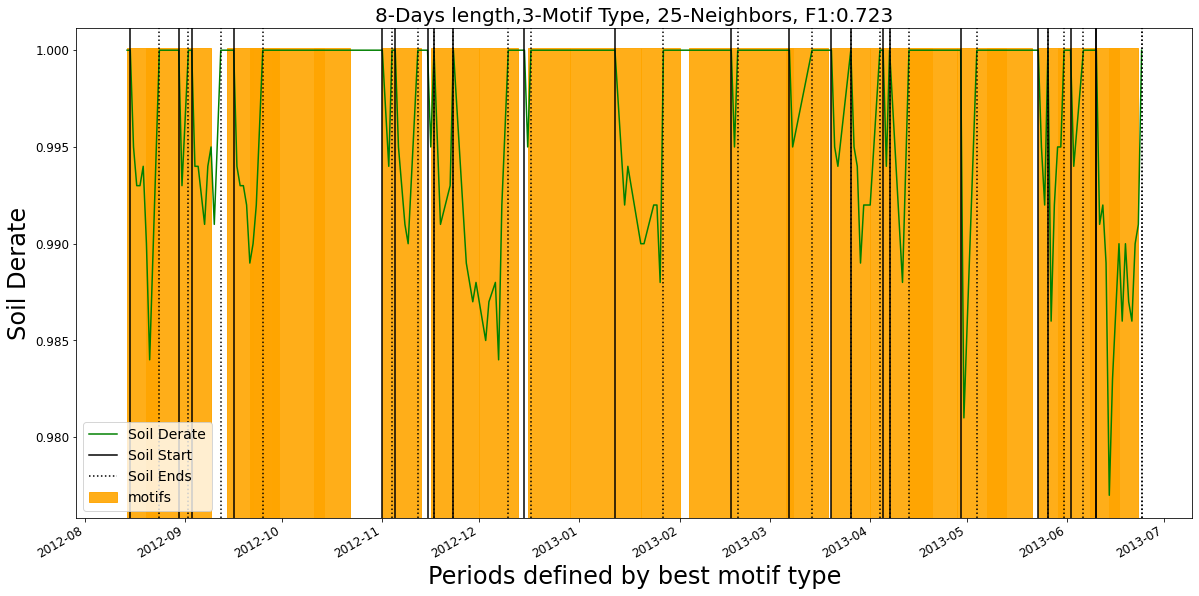

              precision    recall  f1-score   support

         0.0       0.72      0.19      0.31        93
         1.0       0.59      0.94      0.72       114

    accuracy                           0.60       207
   macro avg       0.65      0.57      0.51       207
weighted avg       0.65      0.60      0.54       207



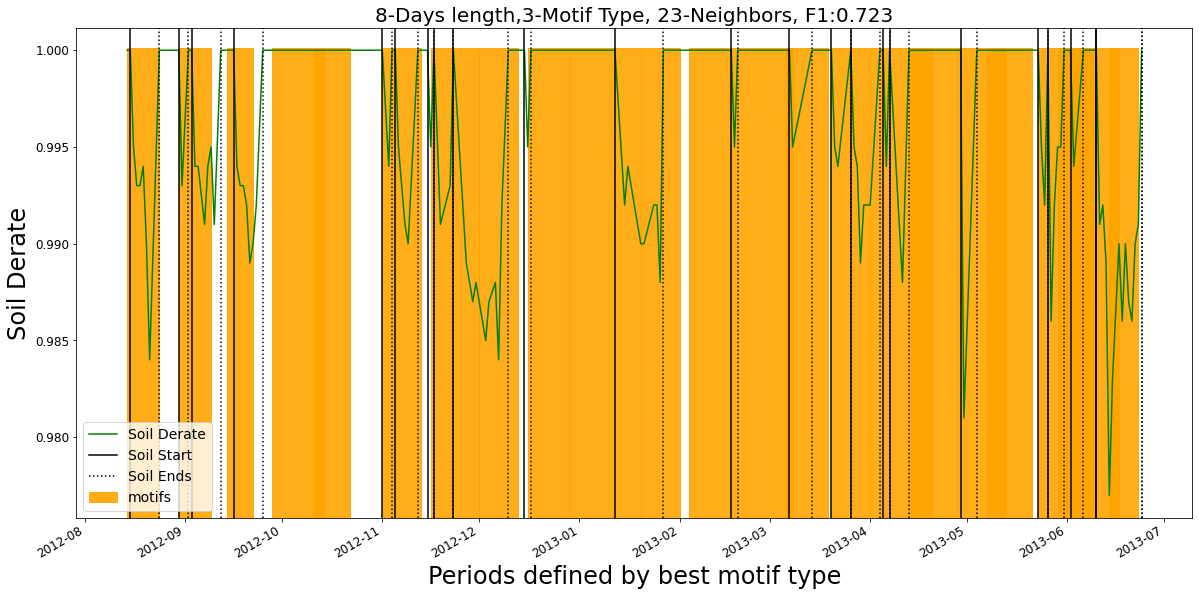

              precision    recall  f1-score   support

         0.0       0.69      0.27      0.39        93
         1.0       0.60      0.90      0.72       114

    accuracy                           0.62       207
   macro avg       0.65      0.59      0.56       207
weighted avg       0.64      0.62      0.57       207



In [8]:
motif_graph_multi_dim(col=col,df=df,
                  df_soil_output=df_soil_output,
                  alles_df=end_df,n=2,plot=True)

### Motif Based Pattern Discovery
Here we test the results of the the previous panel to the other two.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
1/2
eugene.csv
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (355, 7)
We found 27 Soiling Events with decay less than 0.999 


  0%|          | 0/1196 [00:00<?, ?it/s]

  0%|          | 1/1196 [00:00<15:09,  1.31it/s]

  0%|          | 2/1196 [00:01<17:00,  1.17it/s]

  0%|          | 3/1196 [00:02<17:45,  1.12it/s]

  0%|          | 4/1196 [00:03<20:18,  1.02s/it]

  0%|          | 5/1196 [00:05<22:10,  1.12s/it]

  1%|          | 6/1196 [00:06<22:00,  1.11s/it]

  1%|          | 7/1196 [00:06<19:30,  1.02it/s]

  1%|          | 8/1196 [00:07<18:46,  1.05it/s]

  1%|          | 9/1196 [00:08<19:50,  1.00s/it]

  1%|          | 10/1196 [00:09<19:51,  1.00s/it]

  1%|          | 11/1196 [00:11<25:52,  1.31s/it]

  1%|          | 12/1196 [00:13<25:02,  1.27s/it]

  1%|          | 13/1196 [00:14<27:29,  1.39s/it]

  1%|          | 14/1196 [00:16<29:08,  1.48s/it]

  1%|▏         | 15/1196 [00:18<30:54,  1.57s/it]

  1%|▏         | 16/1196 [00:20<33:51,  1.72s/it]

  1%|▏         | 17/1196 [00:22<33:32,  1.71s/it]

  2%|▏         | 18/1196 [00:24<36:57,  1.88s/it]

  2%|▏         | 19/1196 [00:25<30:00,  1.53s/it]

  2%|▏         | 20/1196 [00:25<25:42,  1.31s/it]

  2%|▏         | 21/1196 [00:26<22:09,  1.13s/it]

  2%|▏         | 22/1196 [00:27<22:27,  1.15s/it]

  2%|▏         | 23/1196 [00:29<23:30,  1.20s/it]

  2%|▏         | 24/1196 [00:29<21:58,  1.13s/it]

  2%|▏         | 25/1196 [00:31<22:17,  1.14s/it]

  2%|▏         | 26/1196 [00:32<20:58,  1.08s/it]

  2%|▏         | 27/1196 [00:32<19:24,  1.00it/s]

  2%|▏         | 28/1196 [00:34<20:07,  1.03s/it]

  2%|▏         | 29/1196 [00:34<18:19,  1.06it/s]

  3%|▎         | 30/1196 [00:36<22:40,  1.17s/it]

  3%|▎         | 31/1196 [00:39<32:51,  1.69s/it]

  3%|▎         | 32/1196 [00:39<26:06,  1.35s/it]

  3%|▎         | 33/1196 [00:40<24:22,  1.26s/it]

  3%|▎         | 34/1196 [00:41<22:56,  1.18s/it]

  3%|▎         | 35/1196 [00:43<27:20,  1.41s/it]

  3%|▎         | 36/1196 [00:45<26:28,  1.37s/it]

  3%|▎         | 37/1196 [00:47<29:23,  1.52s/it]

  3%|▎         | 38/1196 [00:48<30:02,  1.56s/it]

  3%|▎         | 39/1196 [00:49<27:42,  1.44s/it]

  3%|▎         | 40/1196 [00:50<23:54,  1.24s/it]

  3%|▎         | 41/1196 [00:52<25:57,  1.35s/it]

  4%|▎         | 42/1196 [00:54<32:44,  1.70s/it]

  4%|▎         | 43/1196 [00:55<29:46,  1.55s/it]

  4%|▎         | 44/1196 [00:57<28:02,  1.46s/it]

  4%|▍         | 45/1196 [00:58<25:48,  1.35s/it]

  4%|▍         | 46/1196 [01:00<28:10,  1.47s/it]

  4%|▍         | 47/1196 [01:00<22:29,  1.17s/it]

  4%|▍         | 48/1196 [01:01<23:34,  1.23s/it]

  4%|▍         | 49/1196 [01:04<30:25,  1.59s/it]

  4%|▍         | 50/1196 [01:05<25:51,  1.35s/it]

  4%|▍         | 51/1196 [01:06<25:02,  1.31s/it]

  4%|▍         | 52/1196 [01:07<22:18,  1.17s/it]

  4%|▍         | 53/1196 [01:08<22:05,  1.16s/it]

  5%|▍         | 54/1196 [01:10<25:31,  1.34s/it]

  5%|▍         | 55/1196 [01:10<21:27,  1.13s/it]

  5%|▍         | 56/1196 [01:11<16:55,  1.12it/s]

  5%|▍         | 57/1196 [01:12<17:26,  1.09it/s]

  5%|▍         | 58/1196 [01:14<24:37,  1.30s/it]

  5%|▍         | 59/1196 [01:15<22:26,  1.18s/it]

  5%|▌         | 60/1196 [01:15<20:05,  1.06s/it]

  5%|▌         | 61/1196 [01:16<19:26,  1.03s/it]

  5%|▌         | 62/1196 [01:18<25:08,  1.33s/it]

  5%|▌         | 63/1196 [01:19<23:16,  1.23s/it]

  5%|▌         | 64/1196 [01:20<20:23,  1.08s/it]

  5%|▌         | 65/1196 [01:21<20:48,  1.10s/it]

  6%|▌         | 66/1196 [01:22<17:39,  1.07it/s]

  6%|▌         | 67/1196 [01:23<17:34,  1.07it/s]

  6%|▌         | 68/1196 [01:23<15:37,  1.20it/s]

  6%|▌         | 69/1196 [01:25<19:35,  1.04s/it]

  6%|▌         | 70/1196 [01:27<25:45,  1.37s/it]

  6%|▌         | 71/1196 [01:28<22:06,  1.18s/it]

  6%|▌         | 72/1196 [01:29<21:35,  1.15s/it]

  6%|▌         | 73/1196 [01:30<19:29,  1.04s/it]

  6%|▌         | 74/1196 [01:31<20:20,  1.09s/it]

  6%|▋         | 75/1196 [01:32<19:44,  1.06s/it]

  6%|▋         | 76/1196 [01:33<18:13,  1.02it/s]

  6%|▋         | 77/1196 [01:33<16:51,  1.11it/s]

  7%|▋         | 78/1196 [01:34<17:13,  1.08it/s]

  7%|▋         | 79/1196 [01:35<16:14,  1.15it/s]

  7%|▋         | 80/1196 [01:38<27:04,  1.46s/it]

  7%|▋         | 81/1196 [01:39<23:32,  1.27s/it]

  7%|▋         | 82/1196 [01:39<20:36,  1.11s/it]

  7%|▋         | 83/1196 [01:40<17:49,  1.04it/s]

  7%|▋         | 84/1196 [01:41<15:17,  1.21it/s]

  7%|▋         | 85/1196 [01:41<13:06,  1.41it/s]

  7%|▋         | 86/1196 [01:43<18:25,  1.00it/s]

  7%|▋         | 87/1196 [01:43<16:25,  1.13it/s]

  7%|▋         | 88/1196 [01:44<18:03,  1.02it/s]

  7%|▋         | 89/1196 [01:46<19:39,  1.07s/it]

  8%|▊         | 90/1196 [01:46<15:51,  1.16it/s]

  8%|▊         | 91/1196 [01:48<18:47,  1.02s/it]

  8%|▊         | 92/1196 [01:48<18:04,  1.02it/s]

  8%|▊         | 93/1196 [01:49<18:31,  1.01s/it]

  8%|▊         | 94/1196 [01:52<24:55,  1.36s/it]

  8%|▊         | 95/1196 [01:52<19:43,  1.07s/it]

  8%|▊         | 96/1196 [01:53<17:16,  1.06it/s]

  8%|▊         | 97/1196 [01:53<14:51,  1.23it/s]

  8%|▊         | 98/1196 [01:54<13:31,  1.35it/s]

  8%|▊         | 99/1196 [01:55<17:10,  1.07it/s]

  8%|▊         | 100/1196 [01:56<16:41,  1.09it/s]

  8%|▊         | 101/1196 [01:58<20:33,  1.13s/it]

  9%|▊         | 102/1196 [01:59<19:25,  1.07s/it]

  9%|▊         | 103/1196 [02:00<20:28,  1.12s/it]

  9%|▊         | 104/1196 [02:01<18:56,  1.04s/it]

  9%|▉         | 105/1196 [02:01<17:02,  1.07it/s]

  9%|▉         | 106/1196 [02:02<16:32,  1.10it/s]

  9%|▉         | 107/1196 [02:03<13:28,  1.35it/s]

  9%|▉         | 108/1196 [02:03<13:43,  1.32it/s]

  9%|▉         | 109/1196 [02:05<17:04,  1.06it/s]

  9%|▉         | 110/1196 [02:06<18:38,  1.03s/it]

  9%|▉         | 111/1196 [02:06<15:01,  1.20it/s]

  9%|▉         | 112/1196 [02:07<13:07,  1.38it/s]

  9%|▉         | 113/1196 [02:09<19:29,  1.08s/it]

 10%|▉         | 114/1196 [02:10<22:04,  1.22s/it]

 10%|▉         | 115/1196 [02:11<18:45,  1.04s/it]

 10%|▉         | 116/1196 [02:12<18:32,  1.03s/it]

 10%|▉         | 117/1196 [02:14<25:43,  1.43s/it]

 10%|▉         | 118/1196 [02:15<22:32,  1.25s/it]

 10%|▉         | 119/1196 [02:17<24:37,  1.37s/it]

 10%|█         | 120/1196 [02:18<25:53,  1.44s/it]

 10%|█         | 121/1196 [02:19<23:22,  1.30s/it]

 10%|█         | 122/1196 [02:20<18:44,  1.05s/it]

 10%|█         | 123/1196 [02:20<15:26,  1.16it/s]

 10%|█         | 124/1196 [02:21<15:55,  1.12it/s]

 10%|█         | 125/1196 [02:22<15:33,  1.15it/s]

 11%|█         | 126/1196 [02:24<23:24,  1.31s/it]

 11%|█         | 127/1196 [02:25<22:03,  1.24s/it]

 11%|█         | 128/1196 [02:26<18:28,  1.04s/it]

 11%|█         | 129/1196 [02:28<22:43,  1.28s/it]

 11%|█         | 130/1196 [02:29<19:43,  1.11s/it]

 11%|█         | 131/1196 [02:29<18:37,  1.05s/it]

 11%|█         | 132/1196 [02:30<17:14,  1.03it/s]

 11%|█         | 133/1196 [02:31<14:49,  1.20it/s]

 11%|█         | 134/1196 [02:31<12:49,  1.38it/s]

 11%|█▏        | 135/1196 [02:32<10:53,  1.62it/s]

 11%|█▏        | 136/1196 [02:33<13:56,  1.27it/s]

 11%|█▏        | 137/1196 [02:34<16:21,  1.08it/s]

 12%|█▏        | 138/1196 [02:35<16:34,  1.06it/s]

 12%|█▏        | 139/1196 [02:36<18:19,  1.04s/it]

 12%|█▏        | 140/1196 [02:37<17:07,  1.03it/s]

 12%|█▏        | 141/1196 [02:40<26:42,  1.52s/it]

 12%|█▏        | 142/1196 [02:41<25:27,  1.45s/it]

 12%|█▏        | 143/1196 [02:43<29:04,  1.66s/it]

 12%|█▏        | 144/1196 [02:45<29:20,  1.67s/it]

 12%|█▏        | 145/1196 [02:46<25:49,  1.47s/it]

 12%|█▏        | 146/1196 [02:47<22:35,  1.29s/it]

 12%|█▏        | 147/1196 [02:49<24:04,  1.38s/it]

 12%|█▏        | 148/1196 [02:49<17:55,  1.03s/it]

 12%|█▏        | 149/1196 [02:50<18:28,  1.06s/it]

 13%|█▎        | 150/1196 [02:51<18:26,  1.06s/it]

 13%|█▎        | 151/1196 [02:52<19:48,  1.14s/it]

 13%|█▎        | 152/1196 [02:53<16:36,  1.05it/s]

 13%|█▎        | 153/1196 [02:54<20:23,  1.17s/it]

 13%|█▎        | 154/1196 [02:55<17:14,  1.01it/s]

 13%|█▎        | 155/1196 [02:56<17:46,  1.02s/it]

 13%|█▎        | 156/1196 [02:57<15:58,  1.09it/s]

 13%|█▎        | 157/1196 [03:00<26:44,  1.54s/it]

 13%|█▎        | 158/1196 [03:02<27:48,  1.61s/it]

 13%|█▎        | 159/1196 [03:03<24:58,  1.45s/it]

 13%|█▎        | 160/1196 [03:03<21:31,  1.25s/it]

 13%|█▎        | 161/1196 [03:06<27:05,  1.57s/it]

 14%|█▎        | 162/1196 [03:07<24:20,  1.41s/it]

 14%|█▎        | 163/1196 [03:08<24:23,  1.42s/it]

 14%|█▎        | 164/1196 [03:10<24:13,  1.41s/it]

 14%|█▍        | 165/1196 [03:11<24:53,  1.45s/it]

 14%|█▍        | 166/1196 [03:12<20:11,  1.18s/it]

 14%|█▍        | 167/1196 [03:13<19:13,  1.12s/it]

 14%|█▍        | 168/1196 [03:14<19:18,  1.13s/it]

 14%|█▍        | 169/1196 [03:14<15:58,  1.07it/s]

 14%|█▍        | 170/1196 [03:15<13:36,  1.26it/s]

 14%|█▍        | 171/1196 [03:16<17:53,  1.05s/it]

 14%|█▍        | 172/1196 [03:18<21:42,  1.27s/it]

 14%|█▍        | 173/1196 [03:20<23:32,  1.38s/it]

 15%|█▍        | 174/1196 [03:20<19:42,  1.16s/it]

 15%|█▍        | 175/1196 [03:22<24:05,  1.42s/it]

 15%|█▍        | 176/1196 [03:24<23:55,  1.41s/it]

 15%|█▍        | 177/1196 [03:25<21:46,  1.28s/it]

 15%|█▍        | 178/1196 [03:26<22:35,  1.33s/it]

 15%|█▍        | 179/1196 [03:27<21:13,  1.25s/it]

 15%|█▌        | 180/1196 [03:29<24:44,  1.46s/it]

 15%|█▌        | 181/1196 [03:30<23:00,  1.36s/it]

 15%|█▌        | 182/1196 [03:32<22:10,  1.31s/it]

 15%|█▌        | 183/1196 [03:33<21:02,  1.25s/it]

 15%|█▌        | 184/1196 [03:34<22:53,  1.36s/it]

 15%|█▌        | 185/1196 [03:35<17:41,  1.05s/it]

 16%|█▌        | 186/1196 [03:36<16:50,  1.00s/it]

 16%|█▌        | 187/1196 [03:36<15:34,  1.08it/s]

 16%|█▌        | 188/1196 [03:37<15:45,  1.07it/s]

 16%|█▌        | 189/1196 [03:39<17:15,  1.03s/it]

 16%|█▌        | 190/1196 [03:40<18:38,  1.11s/it]

 16%|█▌        | 191/1196 [03:43<28:17,  1.69s/it]

 16%|█▌        | 192/1196 [03:44<25:54,  1.55s/it]

 16%|█▌        | 193/1196 [03:45<23:13,  1.39s/it]

 16%|█▌        | 194/1196 [03:46<19:02,  1.14s/it]

 16%|█▋        | 195/1196 [03:46<16:51,  1.01s/it]

 16%|█▋        | 196/1196 [03:47<17:16,  1.04s/it]

 16%|█▋        | 197/1196 [03:48<14:38,  1.14it/s]

 17%|█▋        | 198/1196 [03:49<13:54,  1.20it/s]

 17%|█▋        | 199/1196 [03:51<21:43,  1.31s/it]

 17%|█▋        | 200/1196 [03:52<19:57,  1.20s/it]

 17%|█▋        | 201/1196 [03:53<19:59,  1.21s/it]

 17%|█▋        | 202/1196 [03:54<19:34,  1.18s/it]

 17%|█▋        | 203/1196 [03:56<20:20,  1.23s/it]

 17%|█▋        | 204/1196 [03:57<22:19,  1.35s/it]

 17%|█▋        | 205/1196 [03:58<19:47,  1.20s/it]

 17%|█▋        | 206/1196 [03:59<16:14,  1.02it/s]

 17%|█▋        | 207/1196 [03:59<14:17,  1.15it/s]

 17%|█▋        | 208/1196 [04:01<16:16,  1.01it/s]

 17%|█▋        | 209/1196 [04:01<14:19,  1.15it/s]

 18%|█▊        | 210/1196 [04:02<15:20,  1.07it/s]

 18%|█▊        | 211/1196 [04:03<13:29,  1.22it/s]

 18%|█▊        | 212/1196 [04:04<15:19,  1.07it/s]

 18%|█▊        | 213/1196 [04:05<16:35,  1.01s/it]

 18%|█▊        | 214/1196 [04:07<19:59,  1.22s/it]

 18%|█▊        | 215/1196 [04:09<22:27,  1.37s/it]

 18%|█▊        | 216/1196 [04:09<18:50,  1.15s/it]

 18%|█▊        | 217/1196 [04:10<17:30,  1.07s/it]

 18%|█▊        | 218/1196 [04:11<15:52,  1.03it/s]

 18%|█▊        | 219/1196 [04:12<14:14,  1.14it/s]

 18%|█▊        | 220/1196 [04:12<12:51,  1.26it/s]

 18%|█▊        | 221/1196 [04:13<12:18,  1.32it/s]

 19%|█▊        | 222/1196 [04:13<11:42,  1.39it/s]

 19%|█▊        | 223/1196 [04:15<13:31,  1.20it/s]

 19%|█▊        | 224/1196 [04:16<15:23,  1.05it/s]

 19%|█▉        | 225/1196 [04:17<16:04,  1.01it/s]

 19%|█▉        | 226/1196 [04:18<19:01,  1.18s/it]

 19%|█▉        | 227/1196 [04:19<16:37,  1.03s/it]

 19%|█▉        | 228/1196 [04:20<17:11,  1.07s/it]

 19%|█▉        | 229/1196 [04:21<17:29,  1.09s/it]

 19%|█▉        | 230/1196 [04:22<15:25,  1.04it/s]

 19%|█▉        | 231/1196 [04:24<18:19,  1.14s/it]

 19%|█▉        | 232/1196 [04:25<17:38,  1.10s/it]

 19%|█▉        | 233/1196 [04:25<15:19,  1.05it/s]

 20%|█▉        | 234/1196 [04:28<22:54,  1.43s/it]

 20%|█▉        | 235/1196 [04:29<19:37,  1.23s/it]

 20%|█▉        | 236/1196 [04:30<18:14,  1.14s/it]

 20%|█▉        | 237/1196 [04:30<17:13,  1.08s/it]

 20%|█▉        | 238/1196 [04:31<16:15,  1.02s/it]

 20%|█▉        | 239/1196 [04:33<20:09,  1.26s/it]

 20%|██        | 240/1196 [04:35<22:32,  1.42s/it]

 20%|██        | 241/1196 [04:36<21:16,  1.34s/it]

 20%|██        | 242/1196 [04:37<20:22,  1.28s/it]

 20%|██        | 243/1196 [04:39<20:46,  1.31s/it]

 20%|██        | 244/1196 [04:40<19:00,  1.20s/it]

 20%|██        | 245/1196 [04:42<23:53,  1.51s/it]

 21%|██        | 246/1196 [04:44<27:15,  1.72s/it]

 21%|██        | 247/1196 [04:45<25:27,  1.61s/it]

 21%|██        | 248/1196 [04:48<28:06,  1.78s/it]

 21%|██        | 249/1196 [04:48<23:08,  1.47s/it]

 21%|██        | 250/1196 [04:50<22:14,  1.41s/it]

 21%|██        | 251/1196 [04:50<18:45,  1.19s/it]

 21%|██        | 252/1196 [04:52<23:47,  1.51s/it]

 21%|██        | 253/1196 [04:53<20:39,  1.31s/it]

 21%|██        | 254/1196 [04:54<16:22,  1.04s/it]

 21%|██▏       | 255/1196 [04:55<15:11,  1.03it/s]

 21%|██▏       | 256/1196 [04:56<15:31,  1.01it/s]

 21%|██▏       | 257/1196 [04:56<12:40,  1.24it/s]

 22%|██▏       | 258/1196 [04:57<12:20,  1.27it/s]

 22%|██▏       | 259/1196 [05:00<25:56,  1.66s/it]

 22%|██▏       | 260/1196 [05:02<25:48,  1.65s/it]

 22%|██▏       | 261/1196 [05:03<23:02,  1.48s/it]

 22%|██▏       | 262/1196 [05:05<24:46,  1.59s/it]

 22%|██▏       | 263/1196 [05:07<27:47,  1.79s/it]

 22%|██▏       | 264/1196 [05:08<22:09,  1.43s/it]

 22%|██▏       | 265/1196 [05:08<17:55,  1.16s/it]

 22%|██▏       | 266/1196 [05:10<21:20,  1.38s/it]

 22%|██▏       | 267/1196 [05:12<20:51,  1.35s/it]

 22%|██▏       | 268/1196 [05:12<17:05,  1.10s/it]

 22%|██▏       | 269/1196 [05:14<19:42,  1.28s/it]

 23%|██▎       | 270/1196 [05:15<18:47,  1.22s/it]

 23%|██▎       | 271/1196 [05:16<19:56,  1.29s/it]

 23%|██▎       | 272/1196 [05:17<17:34,  1.14s/it]

 23%|██▎       | 273/1196 [05:18<15:35,  1.01s/it]

 23%|██▎       | 274/1196 [05:19<15:06,  1.02it/s]

 23%|██▎       | 275/1196 [05:20<15:44,  1.03s/it]

 23%|██▎       | 276/1196 [05:21<18:38,  1.22s/it]

 23%|██▎       | 277/1196 [05:23<20:46,  1.36s/it]

 23%|██▎       | 278/1196 [05:24<20:40,  1.35s/it]

 23%|██▎       | 279/1196 [05:26<21:42,  1.42s/it]

 23%|██▎       | 280/1196 [05:27<20:40,  1.35s/it]

 23%|██▎       | 281/1196 [05:29<20:20,  1.33s/it]

 24%|██▎       | 282/1196 [05:30<18:48,  1.23s/it]

 24%|██▎       | 283/1196 [05:31<21:30,  1.41s/it]

 24%|██▎       | 284/1196 [05:33<22:22,  1.47s/it]

 24%|██▍       | 285/1196 [05:34<20:55,  1.38s/it]

 24%|██▍       | 286/1196 [05:35<18:57,  1.25s/it]

 24%|██▍       | 287/1196 [05:36<18:43,  1.24s/it]

 24%|██▍       | 288/1196 [05:39<25:18,  1.67s/it]

 24%|██▍       | 289/1196 [05:41<26:38,  1.76s/it]

 24%|██▍       | 290/1196 [05:41<20:17,  1.34s/it]

 24%|██▍       | 291/1196 [05:43<19:56,  1.32s/it]

 24%|██▍       | 292/1196 [05:43<17:16,  1.15s/it]

 24%|██▍       | 293/1196 [05:45<17:46,  1.18s/it]

 25%|██▍       | 294/1196 [05:45<16:04,  1.07s/it]

 25%|██▍       | 295/1196 [05:46<14:05,  1.07it/s]

 25%|██▍       | 296/1196 [05:48<16:37,  1.11s/it]

 25%|██▍       | 297/1196 [05:49<20:15,  1.35s/it]

 25%|██▍       | 298/1196 [05:50<16:25,  1.10s/it]

 25%|██▌       | 299/1196 [05:52<20:32,  1.37s/it]

 25%|██▌       | 300/1196 [05:53<19:10,  1.28s/it]

 25%|██▌       | 301/1196 [05:55<20:39,  1.39s/it]

 25%|██▌       | 302/1196 [05:55<16:52,  1.13s/it]

 25%|██▌       | 303/1196 [05:57<19:28,  1.31s/it]

 25%|██▌       | 304/1196 [05:58<19:03,  1.28s/it]

 26%|██▌       | 305/1196 [06:01<24:12,  1.63s/it]

 26%|██▌       | 306/1196 [06:02<21:35,  1.46s/it]

 26%|██▌       | 307/1196 [06:03<20:20,  1.37s/it]

 26%|██▌       | 308/1196 [06:03<16:51,  1.14s/it]

 26%|██▌       | 309/1196 [06:05<18:51,  1.28s/it]

 26%|██▌       | 310/1196 [06:06<18:18,  1.24s/it]

 26%|██▌       | 311/1196 [06:08<21:45,  1.48s/it]

 26%|██▌       | 312/1196 [06:10<21:00,  1.43s/it]

 26%|██▌       | 313/1196 [06:11<19:18,  1.31s/it]

 26%|██▋       | 314/1196 [06:12<21:24,  1.46s/it]

 26%|██▋       | 315/1196 [06:13<19:37,  1.34s/it]

 26%|██▋       | 316/1196 [06:14<16:52,  1.15s/it]

 27%|██▋       | 317/1196 [06:15<16:53,  1.15s/it]

 27%|██▋       | 318/1196 [06:17<17:21,  1.19s/it]

 27%|██▋       | 319/1196 [06:18<19:33,  1.34s/it]

 27%|██▋       | 320/1196 [06:19<17:25,  1.19s/it]

 27%|██▋       | 321/1196 [06:20<15:31,  1.06s/it]

 27%|██▋       | 322/1196 [06:20<13:11,  1.10it/s]

 27%|██▋       | 323/1196 [06:22<14:10,  1.03it/s]

 27%|██▋       | 324/1196 [06:22<13:39,  1.06it/s]

 27%|██▋       | 325/1196 [06:24<14:43,  1.01s/it]

 27%|██▋       | 326/1196 [06:25<14:56,  1.03s/it]

 27%|██▋       | 327/1196 [06:25<12:55,  1.12it/s]

 27%|██▋       | 328/1196 [06:26<12:09,  1.19it/s]

 28%|██▊       | 329/1196 [06:27<10:51,  1.33it/s]

 28%|██▊       | 330/1196 [06:27<10:33,  1.37it/s]

 28%|██▊       | 331/1196 [06:29<17:08,  1.19s/it]

 28%|██▊       | 332/1196 [06:31<17:05,  1.19s/it]

 28%|██▊       | 333/1196 [06:32<17:07,  1.19s/it]

 28%|██▊       | 334/1196 [06:33<15:41,  1.09s/it]

 28%|██▊       | 335/1196 [06:34<17:41,  1.23s/it]

 28%|██▊       | 336/1196 [06:35<17:42,  1.24s/it]

 28%|██▊       | 337/1196 [06:38<23:13,  1.62s/it]

 28%|██▊       | 338/1196 [06:39<21:11,  1.48s/it]

 28%|██▊       | 339/1196 [06:40<18:34,  1.30s/it]

 28%|██▊       | 340/1196 [06:41<18:42,  1.31s/it]

 29%|██▊       | 341/1196 [06:43<21:32,  1.51s/it]

 29%|██▊       | 342/1196 [06:45<22:44,  1.60s/it]

 29%|██▊       | 343/1196 [06:46<20:59,  1.48s/it]

 29%|██▉       | 344/1196 [06:47<17:12,  1.21s/it]

 29%|██▉       | 345/1196 [06:49<22:03,  1.55s/it]

 29%|██▉       | 346/1196 [06:51<23:10,  1.64s/it]

 29%|██▉       | 347/1196 [06:52<19:49,  1.40s/it]

 29%|██▉       | 348/1196 [06:54<22:06,  1.56s/it]

 29%|██▉       | 349/1196 [06:56<23:52,  1.69s/it]

 29%|██▉       | 350/1196 [06:57<23:02,  1.63s/it]

 29%|██▉       | 351/1196 [06:59<23:36,  1.68s/it]

 29%|██▉       | 352/1196 [07:01<23:15,  1.65s/it]

 30%|██▉       | 353/1196 [07:02<20:59,  1.49s/it]

 30%|██▉       | 354/1196 [07:03<20:40,  1.47s/it]

 30%|██▉       | 355/1196 [07:05<22:56,  1.64s/it]

 30%|██▉       | 356/1196 [07:07<23:04,  1.65s/it]

 30%|██▉       | 357/1196 [07:08<20:06,  1.44s/it]

 30%|██▉       | 358/1196 [07:09<18:59,  1.36s/it]

 30%|███       | 359/1196 [07:11<19:17,  1.38s/it]

 30%|███       | 360/1196 [07:12<19:20,  1.39s/it]

 30%|███       | 361/1196 [07:14<20:38,  1.48s/it]

 30%|███       | 362/1196 [07:15<21:37,  1.56s/it]

 30%|███       | 363/1196 [07:16<19:07,  1.38s/it]

 30%|███       | 364/1196 [07:17<17:47,  1.28s/it]

 31%|███       | 365/1196 [07:18<16:27,  1.19s/it]

 31%|███       | 366/1196 [07:20<20:08,  1.46s/it]

 31%|███       | 367/1196 [07:21<16:46,  1.21s/it]

 31%|███       | 368/1196 [07:22<16:24,  1.19s/it]

 31%|███       | 369/1196 [07:23<16:25,  1.19s/it]

 31%|███       | 370/1196 [07:25<17:19,  1.26s/it]

 31%|███       | 371/1196 [07:26<17:14,  1.25s/it]

 31%|███       | 372/1196 [07:28<19:08,  1.39s/it]

 31%|███       | 373/1196 [07:30<21:33,  1.57s/it]

 31%|███▏      | 374/1196 [07:31<20:28,  1.49s/it]

 31%|███▏      | 375/1196 [07:32<18:54,  1.38s/it]

 31%|███▏      | 376/1196 [07:34<21:44,  1.59s/it]

 32%|███▏      | 377/1196 [07:36<21:12,  1.55s/it]

 32%|███▏      | 378/1196 [07:37<21:10,  1.55s/it]

 32%|███▏      | 379/1196 [07:39<19:46,  1.45s/it]

 32%|███▏      | 380/1196 [07:40<17:38,  1.30s/it]

 32%|███▏      | 381/1196 [07:40<15:14,  1.12s/it]

 32%|███▏      | 382/1196 [07:42<18:36,  1.37s/it]

 32%|███▏      | 383/1196 [07:43<16:02,  1.18s/it]

 32%|███▏      | 384/1196 [07:45<18:25,  1.36s/it]

 32%|███▏      | 385/1196 [07:47<21:04,  1.56s/it]

 32%|███▏      | 386/1196 [07:48<21:00,  1.56s/it]

 32%|███▏      | 387/1196 [07:50<21:22,  1.59s/it]

 32%|███▏      | 388/1196 [07:53<26:26,  1.96s/it]

 33%|███▎      | 389/1196 [07:54<23:11,  1.72s/it]

 33%|███▎      | 390/1196 [07:55<20:41,  1.54s/it]

 33%|███▎      | 391/1196 [07:56<18:04,  1.35s/it]

 33%|███▎      | 392/1196 [07:57<18:07,  1.35s/it]

 33%|███▎      | 393/1196 [07:58<15:59,  1.19s/it]

 33%|███▎      | 394/1196 [07:59<15:19,  1.15s/it]

 33%|███▎      | 395/1196 [08:00<15:16,  1.14s/it]

 33%|███▎      | 396/1196 [08:01<15:00,  1.13s/it]

 33%|███▎      | 397/1196 [08:02<13:05,  1.02it/s]

 33%|███▎      | 398/1196 [08:04<16:10,  1.22s/it]

 33%|███▎      | 399/1196 [08:05<15:56,  1.20s/it]

 33%|███▎      | 400/1196 [08:07<20:02,  1.51s/it]

 34%|███▎      | 401/1196 [08:09<20:21,  1.54s/it]

 34%|███▎      | 402/1196 [08:09<16:24,  1.24s/it]

 34%|███▎      | 403/1196 [08:11<18:34,  1.41s/it]

 34%|███▍      | 404/1196 [08:13<19:55,  1.51s/it]

 34%|███▍      | 405/1196 [08:14<18:00,  1.37s/it]

 34%|███▍      | 406/1196 [08:15<16:19,  1.24s/it]

 34%|███▍      | 407/1196 [08:16<17:46,  1.35s/it]

 34%|███▍      | 408/1196 [08:18<19:15,  1.47s/it]

 34%|███▍      | 409/1196 [08:21<24:38,  1.88s/it]

 34%|███▍      | 410/1196 [08:23<24:25,  1.87s/it]

 34%|███▍      | 411/1196 [08:24<20:37,  1.58s/it]

 34%|███▍      | 412/1196 [08:24<16:18,  1.25s/it]

 35%|███▍      | 413/1196 [08:25<15:03,  1.15s/it]

 35%|███▍      | 414/1196 [08:27<17:12,  1.32s/it]

 35%|███▍      | 415/1196 [08:29<21:22,  1.64s/it]

 35%|███▍      | 416/1196 [08:30<16:17,  1.25s/it]

 35%|███▍      | 417/1196 [08:30<13:10,  1.01s/it]

 35%|███▍      | 418/1196 [08:31<14:31,  1.12s/it]

 35%|███▌      | 419/1196 [08:34<20:04,  1.55s/it]

 35%|███▌      | 420/1196 [08:35<17:40,  1.37s/it]

 35%|███▌      | 421/1196 [08:36<16:55,  1.31s/it]

 35%|███▌      | 422/1196 [08:37<16:41,  1.29s/it]

 35%|███▌      | 423/1196 [08:38<15:16,  1.19s/it]

 35%|███▌      | 424/1196 [08:40<17:19,  1.35s/it]

 36%|███▌      | 425/1196 [08:42<18:08,  1.41s/it]

 36%|███▌      | 426/1196 [08:43<17:25,  1.36s/it]

 36%|███▌      | 427/1196 [08:45<19:03,  1.49s/it]

 36%|███▌      | 428/1196 [08:47<21:52,  1.71s/it]

 36%|███▌      | 429/1196 [08:49<22:31,  1.76s/it]

 36%|███▌      | 430/1196 [08:50<22:08,  1.73s/it]

 36%|███▌      | 431/1196 [08:52<20:27,  1.60s/it]

 36%|███▌      | 432/1196 [08:52<17:12,  1.35s/it]

 36%|███▌      | 433/1196 [08:53<14:30,  1.14s/it]

 36%|███▋      | 434/1196 [08:54<14:57,  1.18s/it]

 36%|███▋      | 435/1196 [08:55<13:29,  1.06s/it]

 36%|███▋      | 436/1196 [08:57<15:03,  1.19s/it]

 37%|███▋      | 437/1196 [08:58<16:49,  1.33s/it]

 37%|███▋      | 438/1196 [09:01<22:31,  1.78s/it]

 37%|███▋      | 439/1196 [09:03<21:20,  1.69s/it]

 37%|███▋      | 440/1196 [09:04<18:49,  1.49s/it]

 37%|███▋      | 441/1196 [09:05<19:07,  1.52s/it]

 37%|███▋      | 442/1196 [09:06<17:10,  1.37s/it]

 37%|███▋      | 443/1196 [09:09<21:14,  1.69s/it]

 37%|███▋      | 444/1196 [09:10<18:58,  1.51s/it]

 37%|███▋      | 445/1196 [09:11<17:59,  1.44s/it]

 37%|███▋      | 446/1196 [09:13<20:14,  1.62s/it]

 37%|███▋      | 447/1196 [09:16<23:38,  1.89s/it]

 37%|███▋      | 448/1196 [09:17<21:18,  1.71s/it]

 38%|███▊      | 449/1196 [09:18<18:11,  1.46s/it]

 38%|███▊      | 450/1196 [09:20<19:12,  1.54s/it]

 38%|███▊      | 451/1196 [09:20<16:10,  1.30s/it]

 38%|███▊      | 452/1196 [09:21<14:05,  1.14s/it]

 38%|███▊      | 453/1196 [09:22<14:25,  1.17s/it]

 38%|███▊      | 454/1196 [09:24<16:53,  1.37s/it]

 38%|███▊      | 455/1196 [09:27<20:45,  1.68s/it]

 38%|███▊      | 456/1196 [09:28<18:56,  1.54s/it]

 38%|███▊      | 457/1196 [09:29<17:29,  1.42s/it]

 38%|███▊      | 458/1196 [09:30<16:40,  1.36s/it]

 38%|███▊      | 459/1196 [09:31<15:50,  1.29s/it]

 38%|███▊      | 460/1196 [09:34<21:35,  1.76s/it]

 39%|███▊      | 461/1196 [09:35<19:40,  1.61s/it]

 39%|███▊      | 462/1196 [09:37<20:20,  1.66s/it]

 39%|███▊      | 463/1196 [09:39<21:21,  1.75s/it]

 39%|███▉      | 464/1196 [09:42<23:52,  1.96s/it]

 39%|███▉      | 465/1196 [09:44<25:15,  2.07s/it]

 39%|███▉      | 466/1196 [09:45<21:54,  1.80s/it]

 39%|███▉      | 467/1196 [09:46<19:20,  1.59s/it]

 39%|███▉      | 468/1196 [09:48<20:02,  1.65s/it]

 39%|███▉      | 469/1196 [09:49<16:23,  1.35s/it]

 39%|███▉      | 470/1196 [09:49<13:36,  1.12s/it]

 39%|███▉      | 471/1196 [09:51<15:39,  1.30s/it]

 39%|███▉      | 472/1196 [09:52<15:28,  1.28s/it]

 40%|███▉      | 473/1196 [09:53<12:49,  1.06s/it]

 40%|███▉      | 474/1196 [09:54<12:59,  1.08s/it]

 40%|███▉      | 475/1196 [09:55<13:31,  1.13s/it]

 40%|███▉      | 476/1196 [09:57<15:50,  1.32s/it]

 40%|███▉      | 477/1196 [09:58<16:52,  1.41s/it]

 40%|███▉      | 478/1196 [10:00<15:54,  1.33s/it]

 40%|████      | 479/1196 [10:00<14:27,  1.21s/it]

 40%|████      | 480/1196 [10:03<18:56,  1.59s/it]

 40%|████      | 481/1196 [10:05<20:08,  1.69s/it]

 40%|████      | 482/1196 [10:07<23:08,  1.94s/it]

 40%|████      | 483/1196 [10:09<20:17,  1.71s/it]

 40%|████      | 484/1196 [10:10<20:23,  1.72s/it]

 41%|████      | 485/1196 [10:11<17:49,  1.50s/it]

 41%|████      | 486/1196 [10:13<17:28,  1.48s/it]

 41%|████      | 487/1196 [10:13<14:45,  1.25s/it]

 41%|████      | 488/1196 [10:16<20:47,  1.76s/it]

 41%|████      | 489/1196 [10:19<22:44,  1.93s/it]

 41%|████      | 490/1196 [10:21<23:22,  1.99s/it]

 41%|████      | 491/1196 [10:22<19:03,  1.62s/it]

 41%|████      | 492/1196 [10:23<17:55,  1.53s/it]

 41%|████      | 493/1196 [10:25<18:24,  1.57s/it]

 41%|████▏     | 494/1196 [10:26<16:31,  1.41s/it]

 41%|████▏     | 495/1196 [10:27<15:10,  1.30s/it]

 41%|████▏     | 496/1196 [10:29<17:16,  1.48s/it]

 42%|████▏     | 497/1196 [10:29<14:05,  1.21s/it]

 42%|████▏     | 498/1196 [10:31<15:31,  1.33s/it]

 42%|████▏     | 499/1196 [10:33<19:44,  1.70s/it]

 42%|████▏     | 500/1196 [10:34<17:45,  1.53s/it]

 42%|████▏     | 501/1196 [10:36<18:05,  1.56s/it]

 42%|████▏     | 502/1196 [10:38<19:31,  1.69s/it]

 42%|████▏     | 503/1196 [10:39<15:27,  1.34s/it]

 42%|████▏     | 504/1196 [10:40<15:16,  1.32s/it]

 42%|████▏     | 505/1196 [10:41<13:45,  1.19s/it]

 42%|████▏     | 506/1196 [10:42<12:43,  1.11s/it]

 42%|████▏     | 507/1196 [10:43<13:03,  1.14s/it]

 42%|████▏     | 508/1196 [10:45<15:23,  1.34s/it]

 43%|████▎     | 509/1196 [10:45<13:14,  1.16s/it]

 43%|████▎     | 510/1196 [10:47<15:46,  1.38s/it]

 43%|████▎     | 511/1196 [10:48<13:58,  1.22s/it]

 43%|████▎     | 512/1196 [10:50<15:22,  1.35s/it]

 43%|████▎     | 513/1196 [10:52<18:31,  1.63s/it]

 43%|████▎     | 514/1196 [10:53<15:24,  1.36s/it]

 43%|████▎     | 515/1196 [10:55<16:44,  1.47s/it]

 43%|████▎     | 516/1196 [10:56<16:04,  1.42s/it]

 43%|████▎     | 517/1196 [10:58<18:30,  1.64s/it]

 43%|████▎     | 518/1196 [11:01<21:24,  1.90s/it]

 43%|████▎     | 519/1196 [11:02<20:39,  1.83s/it]

 43%|████▎     | 520/1196 [11:04<18:52,  1.68s/it]

 44%|████▎     | 521/1196 [11:05<17:31,  1.56s/it]

 44%|████▎     | 522/1196 [11:07<19:19,  1.72s/it]

 44%|████▎     | 523/1196 [11:09<21:58,  1.96s/it]

 44%|████▍     | 524/1196 [11:11<18:58,  1.69s/it]

 44%|████▍     | 525/1196 [11:12<16:57,  1.52s/it]

 44%|████▍     | 526/1196 [11:12<14:41,  1.32s/it]

 44%|████▍     | 527/1196 [11:14<14:27,  1.30s/it]

 44%|████▍     | 528/1196 [11:16<17:01,  1.53s/it]

 44%|████▍     | 529/1196 [11:17<16:42,  1.50s/it]

 44%|████▍     | 530/1196 [11:19<16:32,  1.49s/it]

 44%|████▍     | 531/1196 [11:20<15:09,  1.37s/it]

 44%|████▍     | 532/1196 [11:21<13:26,  1.21s/it]

 45%|████▍     | 533/1196 [11:23<15:42,  1.42s/it]

 45%|████▍     | 534/1196 [11:24<17:08,  1.55s/it]

 45%|████▍     | 535/1196 [11:26<16:26,  1.49s/it]

 45%|████▍     | 536/1196 [11:27<15:31,  1.41s/it]

 45%|████▍     | 537/1196 [11:29<17:57,  1.63s/it]

 45%|████▍     | 538/1196 [11:30<13:48,  1.26s/it]

 45%|████▌     | 539/1196 [11:31<14:08,  1.29s/it]

 45%|████▌     | 540/1196 [11:32<13:40,  1.25s/it]

 45%|████▌     | 541/1196 [11:34<14:43,  1.35s/it]

 45%|████▌     | 542/1196 [11:36<16:37,  1.53s/it]

 45%|████▌     | 543/1196 [11:36<12:28,  1.15s/it]

 45%|████▌     | 544/1196 [11:37<13:08,  1.21s/it]

 46%|████▌     | 545/1196 [11:39<14:29,  1.34s/it]

 46%|████▌     | 546/1196 [11:40<14:51,  1.37s/it]

 46%|████▌     | 547/1196 [11:41<14:24,  1.33s/it]

 46%|████▌     | 548/1196 [11:43<13:22,  1.24s/it]

 46%|████▌     | 549/1196 [11:44<14:25,  1.34s/it]

 46%|████▌     | 550/1196 [11:45<12:45,  1.18s/it]

 46%|████▌     | 551/1196 [11:45<10:39,  1.01it/s]

 46%|████▌     | 552/1196 [11:46<10:03,  1.07it/s]

 46%|████▌     | 553/1196 [11:47<08:46,  1.22it/s]

 46%|████▋     | 554/1196 [11:49<12:56,  1.21s/it]

 46%|████▋     | 555/1196 [11:51<15:48,  1.48s/it]

 46%|████▋     | 556/1196 [11:52<14:48,  1.39s/it]

 47%|████▋     | 557/1196 [11:53<14:19,  1.34s/it]

 47%|████▋     | 558/1196 [11:55<13:59,  1.32s/it]

 47%|████▋     | 559/1196 [11:58<19:42,  1.86s/it]

 47%|████▋     | 560/1196 [12:00<19:29,  1.84s/it]

 47%|████▋     | 561/1196 [12:01<17:18,  1.63s/it]

 47%|████▋     | 562/1196 [12:02<15:10,  1.44s/it]

 47%|████▋     | 563/1196 [12:03<13:46,  1.31s/it]

 47%|████▋     | 564/1196 [12:03<11:27,  1.09s/it]

 47%|████▋     | 565/1196 [12:05<13:22,  1.27s/it]

 47%|████▋     | 566/1196 [12:06<13:05,  1.25s/it]

 47%|████▋     | 567/1196 [12:07<12:53,  1.23s/it]

 47%|████▋     | 568/1196 [12:08<12:07,  1.16s/it]

 48%|████▊     | 569/1196 [12:10<12:42,  1.22s/it]

 48%|████▊     | 570/1196 [12:12<14:32,  1.39s/it]

 48%|████▊     | 571/1196 [12:13<13:32,  1.30s/it]

 48%|████▊     | 572/1196 [12:13<11:25,  1.10s/it]

 48%|████▊     | 573/1196 [12:15<14:34,  1.40s/it]

 48%|████▊     | 574/1196 [12:17<15:28,  1.49s/it]

 48%|████▊     | 575/1196 [12:18<14:49,  1.43s/it]

 48%|████▊     | 576/1196 [12:19<13:40,  1.32s/it]

 48%|████▊     | 577/1196 [12:20<12:44,  1.23s/it]

 48%|████▊     | 578/1196 [12:23<15:58,  1.55s/it]

 48%|████▊     | 579/1196 [12:23<13:05,  1.27s/it]

 48%|████▊     | 580/1196 [12:25<13:38,  1.33s/it]

 49%|████▊     | 581/1196 [12:26<13:18,  1.30s/it]

 49%|████▊     | 582/1196 [12:27<12:42,  1.24s/it]

 49%|████▊     | 583/1196 [12:30<16:21,  1.60s/it]

 49%|████▉     | 584/1196 [12:31<14:46,  1.45s/it]

 49%|████▉     | 585/1196 [12:32<13:06,  1.29s/it]

 49%|████▉     | 586/1196 [12:34<16:22,  1.61s/it]

 49%|████▉     | 587/1196 [12:35<13:50,  1.36s/it]

 49%|████▉     | 588/1196 [12:36<11:55,  1.18s/it]

 49%|████▉     | 589/1196 [12:37<13:38,  1.35s/it]

 49%|████▉     | 590/1196 [12:39<13:40,  1.35s/it]

 49%|████▉     | 591/1196 [12:40<14:19,  1.42s/it]

 49%|████▉     | 592/1196 [12:41<11:12,  1.11s/it]

 50%|████▉     | 593/1196 [12:43<13:41,  1.36s/it]

 50%|████▉     | 594/1196 [12:43<10:41,  1.07s/it]

 50%|████▉     | 595/1196 [12:45<13:52,  1.38s/it]

 50%|████▉     | 596/1196 [12:46<13:27,  1.35s/it]

 50%|████▉     | 597/1196 [12:47<11:49,  1.18s/it]

 50%|█████     | 598/1196 [12:50<15:42,  1.58s/it]

 50%|█████     | 599/1196 [12:51<16:23,  1.65s/it]

 50%|█████     | 600/1196 [12:53<17:25,  1.75s/it]

 50%|█████     | 601/1196 [12:54<13:36,  1.37s/it]

 50%|█████     | 602/1196 [12:55<12:32,  1.27s/it]

 50%|█████     | 603/1196 [12:57<14:19,  1.45s/it]

 51%|█████     | 604/1196 [12:58<13:35,  1.38s/it]

 51%|█████     | 605/1196 [12:59<10:57,  1.11s/it]

 51%|█████     | 606/1196 [13:00<11:18,  1.15s/it]

 51%|█████     | 607/1196 [13:01<11:05,  1.13s/it]

 51%|█████     | 608/1196 [13:02<11:05,  1.13s/it]

 51%|█████     | 609/1196 [13:03<09:20,  1.05it/s]

 51%|█████     | 610/1196 [13:04<09:59,  1.02s/it]

 51%|█████     | 611/1196 [13:04<08:38,  1.13it/s]

 51%|█████     | 612/1196 [13:05<07:51,  1.24it/s]

 51%|█████▏    | 613/1196 [13:07<11:33,  1.19s/it]

 51%|█████▏    | 614/1196 [13:11<18:38,  1.92s/it]

 51%|█████▏    | 615/1196 [13:11<15:27,  1.60s/it]

 52%|█████▏    | 616/1196 [13:14<16:57,  1.75s/it]

 52%|█████▏    | 617/1196 [13:15<16:12,  1.68s/it]

 52%|█████▏    | 618/1196 [13:17<16:21,  1.70s/it]

 52%|█████▏    | 619/1196 [13:18<15:39,  1.63s/it]

 52%|█████▏    | 620/1196 [13:19<13:50,  1.44s/it]

 52%|█████▏    | 621/1196 [13:20<13:04,  1.36s/it]

 52%|█████▏    | 622/1196 [13:21<11:50,  1.24s/it]

 52%|█████▏    | 623/1196 [13:22<10:16,  1.08s/it]

 52%|█████▏    | 624/1196 [13:23<09:33,  1.00s/it]

 52%|█████▏    | 625/1196 [13:24<08:45,  1.09it/s]

 52%|█████▏    | 626/1196 [13:24<07:52,  1.21it/s]

 52%|█████▏    | 627/1196 [13:25<08:33,  1.11it/s]

 53%|█████▎    | 628/1196 [13:27<09:59,  1.06s/it]

 53%|█████▎    | 629/1196 [13:29<13:03,  1.38s/it]

 53%|█████▎    | 630/1196 [13:31<14:03,  1.49s/it]

 53%|█████▎    | 631/1196 [13:31<12:07,  1.29s/it]

 53%|█████▎    | 632/1196 [13:33<14:07,  1.50s/it]

 53%|█████▎    | 633/1196 [13:35<13:04,  1.39s/it]

 53%|█████▎    | 634/1196 [13:35<11:23,  1.22s/it]

 53%|█████▎    | 635/1196 [13:37<12:43,  1.36s/it]

 53%|█████▎    | 636/1196 [13:40<15:43,  1.68s/it]

 53%|█████▎    | 637/1196 [13:41<16:04,  1.73s/it]

 53%|█████▎    | 638/1196 [13:42<12:39,  1.36s/it]

 53%|█████▎    | 639/1196 [13:43<12:44,  1.37s/it]

 54%|█████▎    | 640/1196 [13:45<12:27,  1.34s/it]

 54%|█████▎    | 641/1196 [13:46<13:13,  1.43s/it]

 54%|█████▎    | 642/1196 [13:48<14:15,  1.54s/it]

 54%|█████▍    | 643/1196 [13:49<12:57,  1.41s/it]

 54%|█████▍    | 644/1196 [13:50<12:12,  1.33s/it]

 54%|█████▍    | 645/1196 [13:51<11:46,  1.28s/it]

 54%|█████▍    | 646/1196 [13:52<11:10,  1.22s/it]

 54%|█████▍    | 647/1196 [13:53<10:17,  1.13s/it]

 54%|█████▍    | 648/1196 [13:55<12:40,  1.39s/it]

 54%|█████▍    | 649/1196 [13:56<11:51,  1.30s/it]

 54%|█████▍    | 650/1196 [13:58<13:44,  1.51s/it]

 54%|█████▍    | 651/1196 [13:59<11:28,  1.26s/it]

 55%|█████▍    | 652/1196 [14:00<10:37,  1.17s/it]

 55%|█████▍    | 653/1196 [14:02<11:36,  1.28s/it]

 55%|█████▍    | 654/1196 [14:03<10:56,  1.21s/it]

 55%|█████▍    | 655/1196 [14:05<12:51,  1.43s/it]

 55%|█████▍    | 656/1196 [14:06<12:06,  1.34s/it]

 55%|█████▍    | 657/1196 [14:07<12:08,  1.35s/it]

 55%|█████▌    | 658/1196 [14:09<14:15,  1.59s/it]

 55%|█████▌    | 659/1196 [14:11<14:39,  1.64s/it]

 55%|█████▌    | 660/1196 [14:13<15:24,  1.73s/it]

 55%|█████▌    | 661/1196 [14:14<13:39,  1.53s/it]

 55%|█████▌    | 662/1196 [14:15<11:51,  1.33s/it]

 55%|█████▌    | 663/1196 [14:16<11:12,  1.26s/it]

 56%|█████▌    | 664/1196 [14:17<10:36,  1.20s/it]

 56%|█████▌    | 665/1196 [14:18<09:51,  1.11s/it]

 56%|█████▌    | 666/1196 [14:20<11:31,  1.30s/it]

 56%|█████▌    | 667/1196 [14:20<09:40,  1.10s/it]

 56%|█████▌    | 668/1196 [14:21<09:45,  1.11s/it]

 56%|█████▌    | 669/1196 [14:22<09:09,  1.04s/it]

 56%|█████▌    | 670/1196 [14:25<12:05,  1.38s/it]

 56%|█████▌    | 671/1196 [14:26<12:19,  1.41s/it]

 56%|█████▌    | 672/1196 [14:27<11:40,  1.34s/it]

 56%|█████▋    | 673/1196 [14:29<12:15,  1.41s/it]

 56%|█████▋    | 674/1196 [14:30<10:52,  1.25s/it]

 56%|█████▋    | 675/1196 [14:32<13:43,  1.58s/it]

 57%|█████▋    | 676/1196 [14:34<15:20,  1.77s/it]

 57%|█████▋    | 677/1196 [14:35<12:20,  1.43s/it]

 57%|█████▋    | 678/1196 [14:36<11:52,  1.38s/it]

 57%|█████▋    | 679/1196 [14:37<09:37,  1.12s/it]

 57%|█████▋    | 680/1196 [14:38<09:57,  1.16s/it]

 57%|█████▋    | 681/1196 [14:40<12:58,  1.51s/it]

 57%|█████▋    | 682/1196 [14:41<10:13,  1.19s/it]

 57%|█████▋    | 683/1196 [14:42<10:14,  1.20s/it]

 57%|█████▋    | 684/1196 [14:44<12:28,  1.46s/it]

 57%|█████▋    | 685/1196 [14:46<13:45,  1.62s/it]

 57%|█████▋    | 686/1196 [14:46<10:47,  1.27s/it]

 57%|█████▋    | 687/1196 [14:49<13:18,  1.57s/it]

 58%|█████▊    | 688/1196 [14:50<12:23,  1.46s/it]

 58%|█████▊    | 689/1196 [14:51<12:20,  1.46s/it]

 58%|█████▊    | 690/1196 [14:52<10:47,  1.28s/it]

 58%|█████▊    | 691/1196 [14:54<11:57,  1.42s/it]

 58%|█████▊    | 692/1196 [14:56<14:33,  1.73s/it]

 58%|█████▊    | 693/1196 [14:58<14:59,  1.79s/it]

 58%|█████▊    | 694/1196 [15:00<15:00,  1.79s/it]

 58%|█████▊    | 695/1196 [15:01<12:16,  1.47s/it]

 58%|█████▊    | 696/1196 [15:01<09:15,  1.11s/it]

 58%|█████▊    | 697/1196 [15:01<07:24,  1.12it/s]

 58%|█████▊    | 698/1196 [15:02<06:47,  1.22it/s]

 58%|█████▊    | 699/1196 [15:03<07:32,  1.10it/s]

 59%|█████▊    | 700/1196 [15:05<09:23,  1.14s/it]

 59%|█████▊    | 701/1196 [15:05<07:14,  1.14it/s]

 59%|█████▊    | 702/1196 [15:07<08:59,  1.09s/it]

 59%|█████▉    | 703/1196 [15:09<11:33,  1.41s/it]

 59%|█████▉    | 704/1196 [15:10<10:37,  1.30s/it]

 59%|█████▉    | 705/1196 [15:11<10:08,  1.24s/it]

 59%|█████▉    | 706/1196 [15:12<09:52,  1.21s/it]

 59%|█████▉    | 707/1196 [15:13<09:35,  1.18s/it]

 59%|█████▉    | 708/1196 [15:13<07:14,  1.12it/s]

 59%|█████▉    | 709/1196 [15:15<08:09,  1.00s/it]

 59%|█████▉    | 710/1196 [15:16<08:05,  1.00it/s]

 59%|█████▉    | 711/1196 [15:17<09:11,  1.14s/it]

 60%|█████▉    | 712/1196 [15:19<09:33,  1.19s/it]

 60%|█████▉    | 713/1196 [15:20<09:28,  1.18s/it]

 60%|█████▉    | 714/1196 [15:21<08:56,  1.11s/it]

 60%|█████▉    | 715/1196 [15:22<09:05,  1.13s/it]

 60%|█████▉    | 716/1196 [15:23<08:42,  1.09s/it]

 60%|█████▉    | 717/1196 [15:24<09:20,  1.17s/it]

 60%|██████    | 718/1196 [15:26<10:36,  1.33s/it]

 60%|██████    | 719/1196 [15:27<10:54,  1.37s/it]

 60%|██████    | 720/1196 [15:29<11:18,  1.43s/it]

 60%|██████    | 721/1196 [15:31<12:32,  1.58s/it]

 60%|██████    | 722/1196 [15:32<10:25,  1.32s/it]

 60%|██████    | 723/1196 [15:32<09:30,  1.21s/it]

 61%|██████    | 724/1196 [15:34<09:20,  1.19s/it]

 61%|██████    | 725/1196 [15:35<10:33,  1.34s/it]

 61%|██████    | 726/1196 [15:37<10:19,  1.32s/it]

 61%|██████    | 727/1196 [15:37<08:38,  1.11s/it]

 61%|██████    | 728/1196 [15:40<11:33,  1.48s/it]

 61%|██████    | 729/1196 [15:40<09:50,  1.26s/it]

 61%|██████    | 730/1196 [15:41<08:13,  1.06s/it]

 61%|██████    | 731/1196 [15:42<08:28,  1.09s/it]

 61%|██████    | 732/1196 [15:43<08:29,  1.10s/it]

 61%|██████▏   | 733/1196 [15:44<08:34,  1.11s/it]

 61%|██████▏   | 734/1196 [15:45<07:29,  1.03it/s]

 61%|██████▏   | 735/1196 [15:47<09:44,  1.27s/it]

 62%|██████▏   | 736/1196 [15:49<11:11,  1.46s/it]

 62%|██████▏   | 737/1196 [15:50<09:58,  1.30s/it]

 62%|██████▏   | 738/1196 [15:51<09:32,  1.25s/it]

 62%|██████▏   | 739/1196 [15:52<08:15,  1.09s/it]

 62%|██████▏   | 740/1196 [15:53<09:34,  1.26s/it]

 62%|██████▏   | 741/1196 [15:54<08:09,  1.08s/it]

 62%|██████▏   | 742/1196 [15:55<07:50,  1.04s/it]

 62%|██████▏   | 743/1196 [15:56<09:04,  1.20s/it]

 62%|██████▏   | 744/1196 [15:58<08:45,  1.16s/it]

 62%|██████▏   | 745/1196 [15:58<08:01,  1.07s/it]

 62%|██████▏   | 746/1196 [15:59<06:55,  1.08it/s]

 62%|██████▏   | 747/1196 [16:00<06:58,  1.07it/s]

 63%|██████▎   | 748/1196 [16:01<06:37,  1.13it/s]

 63%|██████▎   | 749/1196 [16:02<06:51,  1.09it/s]

 63%|██████▎   | 750/1196 [16:02<06:17,  1.18it/s]

 63%|██████▎   | 751/1196 [16:03<05:48,  1.28it/s]

 63%|██████▎   | 752/1196 [16:04<06:47,  1.09it/s]

 63%|██████▎   | 753/1196 [16:05<06:29,  1.14it/s]

 63%|██████▎   | 754/1196 [16:06<06:10,  1.19it/s]

 63%|██████▎   | 755/1196 [16:08<08:49,  1.20s/it]

 63%|██████▎   | 756/1196 [16:09<08:27,  1.15s/it]

 63%|██████▎   | 757/1196 [16:10<07:29,  1.02s/it]

 63%|██████▎   | 758/1196 [16:11<07:21,  1.01s/it]

 63%|██████▎   | 759/1196 [16:11<06:24,  1.14it/s]

 64%|██████▎   | 760/1196 [16:12<06:39,  1.09it/s]

 64%|██████▎   | 761/1196 [16:13<05:58,  1.21it/s]

 64%|██████▎   | 762/1196 [16:14<06:40,  1.08it/s]

 64%|██████▍   | 763/1196 [16:15<06:23,  1.13it/s]

 64%|██████▍   | 764/1196 [16:16<08:12,  1.14s/it]

 64%|██████▍   | 765/1196 [16:18<10:09,  1.41s/it]

 64%|██████▍   | 766/1196 [16:20<10:41,  1.49s/it]

 64%|██████▍   | 767/1196 [16:21<09:21,  1.31s/it]

 64%|██████▍   | 768/1196 [16:23<10:21,  1.45s/it]

 64%|██████▍   | 769/1196 [16:25<11:05,  1.56s/it]

 64%|██████▍   | 770/1196 [16:25<09:10,  1.29s/it]

 64%|██████▍   | 771/1196 [16:26<07:11,  1.02s/it]

 65%|██████▍   | 772/1196 [16:26<06:12,  1.14it/s]

 65%|██████▍   | 773/1196 [16:28<08:32,  1.21s/it]

 65%|██████▍   | 774/1196 [16:29<08:14,  1.17s/it]

 65%|██████▍   | 775/1196 [16:31<08:30,  1.21s/it]

 65%|██████▍   | 776/1196 [16:31<07:31,  1.07s/it]

 65%|██████▍   | 777/1196 [16:32<06:28,  1.08it/s]

 65%|██████▌   | 778/1196 [16:34<08:07,  1.17s/it]

 65%|██████▌   | 779/1196 [16:34<07:11,  1.03s/it]

 65%|██████▌   | 780/1196 [16:37<09:41,  1.40s/it]

 65%|██████▌   | 781/1196 [16:39<12:40,  1.83s/it]

 65%|██████▌   | 782/1196 [16:41<11:10,  1.62s/it]

 65%|██████▌   | 783/1196 [16:41<08:25,  1.22s/it]

 66%|██████▌   | 784/1196 [16:43<09:18,  1.36s/it]

 66%|██████▌   | 785/1196 [16:43<08:00,  1.17s/it]

 66%|██████▌   | 786/1196 [16:45<09:11,  1.35s/it]

 66%|██████▌   | 787/1196 [16:47<09:57,  1.46s/it]

 66%|██████▌   | 788/1196 [16:49<10:28,  1.54s/it]

 66%|██████▌   | 789/1196 [16:50<09:55,  1.46s/it]

 66%|██████▌   | 790/1196 [16:52<10:45,  1.59s/it]

 66%|██████▌   | 791/1196 [16:52<08:59,  1.33s/it]

 66%|██████▌   | 792/1196 [16:53<07:22,  1.09s/it]

 66%|██████▋   | 793/1196 [16:54<07:07,  1.06s/it]

 66%|██████▋   | 794/1196 [16:57<10:57,  1.64s/it]

 66%|██████▋   | 795/1196 [16:58<09:57,  1.49s/it]

 67%|██████▋   | 796/1196 [17:00<10:43,  1.61s/it]

 67%|██████▋   | 797/1196 [17:01<09:58,  1.50s/it]

 67%|██████▋   | 798/1196 [17:03<09:39,  1.46s/it]

 67%|██████▋   | 799/1196 [17:03<08:14,  1.25s/it]

 67%|██████▋   | 800/1196 [17:05<09:12,  1.40s/it]

 67%|██████▋   | 801/1196 [17:06<07:55,  1.20s/it]

 67%|██████▋   | 802/1196 [17:07<07:58,  1.22s/it]

 67%|██████▋   | 803/1196 [17:09<10:13,  1.56s/it]

 67%|██████▋   | 804/1196 [17:10<09:08,  1.40s/it]

 67%|██████▋   | 805/1196 [17:11<07:58,  1.22s/it]

 67%|██████▋   | 806/1196 [17:13<09:39,  1.49s/it]

 67%|██████▋   | 807/1196 [17:16<11:22,  1.75s/it]

 68%|██████▊   | 808/1196 [17:17<10:23,  1.61s/it]

 68%|██████▊   | 809/1196 [17:19<11:55,  1.85s/it]

 68%|██████▊   | 810/1196 [17:20<09:44,  1.52s/it]

 68%|██████▊   | 811/1196 [17:23<12:14,  1.91s/it]

 68%|██████▊   | 812/1196 [17:24<10:30,  1.64s/it]

 68%|██████▊   | 813/1196 [17:25<08:25,  1.32s/it]

 68%|██████▊   | 814/1196 [17:25<06:22,  1.00s/it]

 68%|██████▊   | 815/1196 [17:26<05:55,  1.07it/s]

 68%|██████▊   | 816/1196 [17:27<06:37,  1.05s/it]

 68%|██████▊   | 817/1196 [17:29<08:34,  1.36s/it]

 68%|██████▊   | 818/1196 [17:31<08:58,  1.42s/it]

 68%|██████▊   | 819/1196 [17:32<08:17,  1.32s/it]

 69%|██████▊   | 820/1196 [17:33<07:34,  1.21s/it]

 69%|██████▊   | 821/1196 [17:35<09:49,  1.57s/it]

 69%|██████▊   | 822/1196 [17:36<09:12,  1.48s/it]

 69%|██████▉   | 823/1196 [17:37<07:55,  1.28s/it]

 69%|██████▉   | 824/1196 [17:40<10:20,  1.67s/it]

 69%|██████▉   | 825/1196 [17:41<09:12,  1.49s/it]

 69%|██████▉   | 826/1196 [17:41<07:37,  1.24s/it]

 69%|██████▉   | 827/1196 [17:42<06:11,  1.01s/it]

 69%|██████▉   | 828/1196 [17:43<06:35,  1.07s/it]

 69%|██████▉   | 829/1196 [17:44<06:40,  1.09s/it]

 69%|██████▉   | 830/1196 [17:47<09:25,  1.54s/it]

 69%|██████▉   | 831/1196 [17:48<09:37,  1.58s/it]

 70%|██████▉   | 832/1196 [17:49<08:33,  1.41s/it]

 70%|██████▉   | 833/1196 [17:50<07:39,  1.27s/it]

 70%|██████▉   | 834/1196 [17:52<07:30,  1.24s/it]

 70%|██████▉   | 835/1196 [17:53<08:23,  1.39s/it]

 70%|██████▉   | 836/1196 [17:55<08:01,  1.34s/it]

 70%|██████▉   | 837/1196 [17:56<08:06,  1.36s/it]

 70%|███████   | 838/1196 [17:57<08:10,  1.37s/it]

 70%|███████   | 839/1196 [17:58<06:26,  1.08s/it]

 70%|███████   | 840/1196 [17:59<06:11,  1.04s/it]

 70%|███████   | 841/1196 [18:00<07:13,  1.22s/it]

 70%|███████   | 842/1196 [18:01<06:24,  1.09s/it]

 70%|███████   | 843/1196 [18:03<07:41,  1.31s/it]

 71%|███████   | 844/1196 [18:05<09:03,  1.54s/it]

 71%|███████   | 845/1196 [18:06<08:24,  1.44s/it]

 71%|███████   | 846/1196 [18:07<07:25,  1.27s/it]

 71%|███████   | 847/1196 [18:09<09:05,  1.56s/it]

 71%|███████   | 848/1196 [18:11<09:16,  1.60s/it]

 71%|███████   | 849/1196 [18:12<08:23,  1.45s/it]

 71%|███████   | 850/1196 [18:13<07:36,  1.32s/it]

 71%|███████   | 851/1196 [18:14<06:53,  1.20s/it]

 71%|███████   | 852/1196 [18:15<07:06,  1.24s/it]

 71%|███████▏  | 853/1196 [18:17<07:12,  1.26s/it]

 71%|███████▏  | 854/1196 [18:19<08:35,  1.51s/it]

 71%|███████▏  | 855/1196 [18:20<07:13,  1.27s/it]

 72%|███████▏  | 856/1196 [18:22<09:15,  1.63s/it]

 72%|███████▏  | 857/1196 [18:23<08:04,  1.43s/it]

 72%|███████▏  | 858/1196 [18:24<06:49,  1.21s/it]

 72%|███████▏  | 859/1196 [18:25<07:03,  1.26s/it]

 72%|███████▏  | 860/1196 [18:26<06:31,  1.16s/it]

 72%|███████▏  | 861/1196 [18:27<06:27,  1.16s/it]

 72%|███████▏  | 862/1196 [18:28<06:41,  1.20s/it]

 72%|███████▏  | 863/1196 [18:30<07:49,  1.41s/it]

 72%|███████▏  | 864/1196 [18:31<07:20,  1.33s/it]

 72%|███████▏  | 865/1196 [18:33<08:29,  1.54s/it]

 72%|███████▏  | 866/1196 [18:35<09:09,  1.66s/it]

 72%|███████▏  | 867/1196 [18:36<07:26,  1.36s/it]

 73%|███████▎  | 868/1196 [18:37<06:58,  1.28s/it]

 73%|███████▎  | 869/1196 [18:38<06:25,  1.18s/it]

 73%|███████▎  | 870/1196 [18:39<06:04,  1.12s/it]

 73%|███████▎  | 871/1196 [18:39<04:41,  1.16it/s]

 73%|███████▎  | 872/1196 [18:41<05:58,  1.11s/it]

 73%|███████▎  | 873/1196 [18:42<05:21,  1.00it/s]

 73%|███████▎  | 874/1196 [18:42<04:44,  1.13it/s]

 73%|███████▎  | 875/1196 [18:43<04:36,  1.16it/s]

 73%|███████▎  | 876/1196 [18:44<04:35,  1.16it/s]

 73%|███████▎  | 877/1196 [18:46<05:39,  1.06s/it]

 73%|███████▎  | 878/1196 [18:46<04:49,  1.10it/s]

 73%|███████▎  | 879/1196 [18:48<05:40,  1.07s/it]

 74%|███████▎  | 880/1196 [18:49<06:22,  1.21s/it]

 74%|███████▎  | 881/1196 [18:51<07:28,  1.43s/it]

 74%|███████▎  | 882/1196 [18:52<06:56,  1.33s/it]

 74%|███████▍  | 883/1196 [18:55<09:19,  1.79s/it]

 74%|███████▍  | 884/1196 [18:56<08:28,  1.63s/it]

 74%|███████▍  | 885/1196 [18:58<08:11,  1.58s/it]

 74%|███████▍  | 886/1196 [18:59<06:59,  1.35s/it]

 74%|███████▍  | 887/1196 [19:00<07:39,  1.49s/it]

 74%|███████▍  | 888/1196 [19:02<07:04,  1.38s/it]

 74%|███████▍  | 889/1196 [19:03<07:22,  1.44s/it]

 74%|███████▍  | 890/1196 [19:05<08:01,  1.57s/it]

 74%|███████▍  | 891/1196 [19:06<06:39,  1.31s/it]

 75%|███████▍  | 892/1196 [19:07<06:44,  1.33s/it]

 75%|███████▍  | 893/1196 [19:09<07:39,  1.52s/it]

 75%|███████▍  | 894/1196 [19:10<07:13,  1.44s/it]

 75%|███████▍  | 895/1196 [19:11<06:54,  1.38s/it]

 75%|███████▍  | 896/1196 [19:13<07:47,  1.56s/it]

 75%|███████▌  | 897/1196 [19:16<09:08,  1.83s/it]

 75%|███████▌  | 898/1196 [19:17<08:17,  1.67s/it]

 75%|███████▌  | 899/1196 [19:19<08:07,  1.64s/it]

 75%|███████▌  | 900/1196 [19:20<07:23,  1.50s/it]

 75%|███████▌  | 901/1196 [19:22<08:50,  1.80s/it]

 75%|███████▌  | 902/1196 [19:23<06:47,  1.39s/it]

 76%|███████▌  | 903/1196 [19:24<07:03,  1.44s/it]

 76%|███████▌  | 904/1196 [19:25<06:03,  1.24s/it]

 76%|███████▌  | 905/1196 [19:26<05:27,  1.13s/it]

 76%|███████▌  | 906/1196 [19:27<05:06,  1.06s/it]

 76%|███████▌  | 907/1196 [19:29<06:26,  1.34s/it]

 76%|███████▌  | 908/1196 [19:31<06:58,  1.45s/it]

 76%|███████▌  | 909/1196 [19:31<05:36,  1.17s/it]

 76%|███████▌  | 910/1196 [19:32<05:16,  1.11s/it]

 76%|███████▌  | 911/1196 [19:34<05:46,  1.22s/it]

 76%|███████▋  | 912/1196 [19:35<05:13,  1.11s/it]

 76%|███████▋  | 913/1196 [19:35<05:02,  1.07s/it]

 76%|███████▋  | 914/1196 [19:37<05:54,  1.26s/it]

 77%|███████▋  | 915/1196 [19:39<06:28,  1.38s/it]

 77%|███████▋  | 916/1196 [19:39<05:17,  1.14s/it]

 77%|███████▋  | 917/1196 [19:40<04:06,  1.13it/s]

 77%|███████▋  | 918/1196 [19:41<04:42,  1.02s/it]

 77%|███████▋  | 919/1196 [19:42<05:08,  1.11s/it]

 77%|███████▋  | 920/1196 [19:44<05:16,  1.15s/it]

 77%|███████▋  | 921/1196 [19:45<05:38,  1.23s/it]

 77%|███████▋  | 922/1196 [19:46<05:33,  1.22s/it]

 77%|███████▋  | 923/1196 [19:47<05:15,  1.15s/it]

 77%|███████▋  | 924/1196 [19:49<05:41,  1.26s/it]

 77%|███████▋  | 925/1196 [19:50<05:16,  1.17s/it]

 77%|███████▋  | 926/1196 [19:50<04:02,  1.11it/s]

 78%|███████▊  | 927/1196 [19:51<04:24,  1.02it/s]

 78%|███████▊  | 928/1196 [19:52<04:31,  1.01s/it]

 78%|███████▊  | 929/1196 [19:53<04:31,  1.02s/it]

 78%|███████▊  | 930/1196 [19:54<03:55,  1.13it/s]

 78%|███████▊  | 931/1196 [19:54<03:25,  1.29it/s]

 78%|███████▊  | 932/1196 [19:56<04:41,  1.07s/it]

 78%|███████▊  | 933/1196 [19:57<04:33,  1.04s/it]

 78%|███████▊  | 934/1196 [19:59<06:03,  1.39s/it]

 78%|███████▊  | 935/1196 [20:00<05:19,  1.22s/it]

 78%|███████▊  | 936/1196 [20:02<06:42,  1.55s/it]

 78%|███████▊  | 937/1196 [20:04<06:56,  1.61s/it]

 78%|███████▊  | 938/1196 [20:05<06:26,  1.50s/it]

 79%|███████▊  | 939/1196 [20:07<06:16,  1.47s/it]

 79%|███████▊  | 940/1196 [20:10<07:57,  1.86s/it]

 79%|███████▊  | 941/1196 [20:10<06:23,  1.50s/it]

 79%|███████▉  | 942/1196 [20:11<05:42,  1.35s/it]

 79%|███████▉  | 943/1196 [20:12<05:08,  1.22s/it]

 79%|███████▉  | 944/1196 [20:14<05:43,  1.36s/it]

 79%|███████▉  | 945/1196 [20:15<05:33,  1.33s/it]

 79%|███████▉  | 946/1196 [20:16<05:07,  1.23s/it]

 79%|███████▉  | 947/1196 [20:16<03:57,  1.05it/s]

 79%|███████▉  | 948/1196 [20:18<05:10,  1.25s/it]

 79%|███████▉  | 949/1196 [20:19<04:30,  1.10s/it]

 79%|███████▉  | 950/1196 [20:20<04:41,  1.15s/it]

 80%|███████▉  | 951/1196 [20:22<05:35,  1.37s/it]

 80%|███████▉  | 952/1196 [20:22<04:11,  1.03s/it]

 80%|███████▉  | 953/1196 [20:23<03:41,  1.10it/s]

 80%|███████▉  | 954/1196 [20:25<05:01,  1.25s/it]

 80%|███████▉  | 955/1196 [20:26<04:18,  1.07s/it]

 80%|███████▉  | 956/1196 [20:27<04:55,  1.23s/it]

 80%|████████  | 957/1196 [20:28<04:43,  1.19s/it]

 80%|████████  | 958/1196 [20:30<05:20,  1.35s/it]

 80%|████████  | 959/1196 [20:32<05:20,  1.35s/it]

 80%|████████  | 960/1196 [20:33<04:56,  1.26s/it]

 80%|████████  | 961/1196 [20:35<06:04,  1.55s/it]

 80%|████████  | 962/1196 [20:36<05:23,  1.38s/it]

 81%|████████  | 963/1196 [20:37<04:43,  1.22s/it]

 81%|████████  | 964/1196 [20:39<05:57,  1.54s/it]

 81%|████████  | 965/1196 [20:40<05:47,  1.51s/it]

 81%|████████  | 966/1196 [20:41<04:43,  1.23s/it]

 81%|████████  | 967/1196 [20:43<05:40,  1.48s/it]

 81%|████████  | 968/1196 [20:44<04:55,  1.30s/it]

 81%|████████  | 969/1196 [20:45<04:21,  1.15s/it]

 81%|████████  | 970/1196 [20:46<04:17,  1.14s/it]

 81%|████████  | 971/1196 [20:47<03:58,  1.06s/it]

 81%|████████▏ | 972/1196 [20:49<04:49,  1.29s/it]

 81%|████████▏ | 973/1196 [20:50<05:08,  1.38s/it]

 81%|████████▏ | 974/1196 [20:52<05:13,  1.41s/it]

 82%|████████▏ | 975/1196 [20:52<04:18,  1.17s/it]

 82%|████████▏ | 976/1196 [20:53<03:40,  1.00s/it]

 82%|████████▏ | 977/1196 [20:54<03:27,  1.05it/s]

 82%|████████▏ | 978/1196 [20:55<03:26,  1.05it/s]

 82%|████████▏ | 979/1196 [20:56<03:39,  1.01s/it]

 82%|████████▏ | 980/1196 [20:57<03:47,  1.06s/it]

 82%|████████▏ | 981/1196 [20:59<04:24,  1.23s/it]

 82%|████████▏ | 982/1196 [21:00<04:09,  1.17s/it]

 82%|████████▏ | 983/1196 [21:00<03:40,  1.04s/it]

 82%|████████▏ | 984/1196 [21:02<04:35,  1.30s/it]

 82%|████████▏ | 985/1196 [21:03<04:18,  1.22s/it]

 82%|████████▏ | 986/1196 [21:05<05:08,  1.47s/it]

 83%|████████▎ | 987/1196 [21:06<04:11,  1.20s/it]

 83%|████████▎ | 988/1196 [21:06<03:30,  1.01s/it]

 83%|████████▎ | 989/1196 [21:08<04:08,  1.20s/it]

 83%|████████▎ | 990/1196 [21:09<04:02,  1.18s/it]

 83%|████████▎ | 991/1196 [21:10<04:02,  1.18s/it]

 83%|████████▎ | 992/1196 [21:12<04:18,  1.27s/it]

 83%|████████▎ | 993/1196 [21:13<04:36,  1.36s/it]

 83%|████████▎ | 994/1196 [21:14<03:33,  1.06s/it]

 83%|████████▎ | 995/1196 [21:15<04:01,  1.20s/it]

 83%|████████▎ | 996/1196 [21:16<03:15,  1.03it/s]

 83%|████████▎ | 997/1196 [21:18<04:02,  1.22s/it]

 83%|████████▎ | 998/1196 [21:20<05:18,  1.61s/it]

 84%|████████▎ | 999/1196 [21:22<05:28,  1.67s/it]

 84%|████████▎ | 1000/1196 [21:23<05:13,  1.60s/it]

 84%|████████▎ | 1001/1196 [21:25<04:47,  1.47s/it]

 84%|████████▍ | 1002/1196 [21:26<04:22,  1.35s/it]

 84%|████████▍ | 1003/1196 [21:26<03:39,  1.14s/it]

 84%|████████▍ | 1004/1196 [21:27<03:38,  1.14s/it]

 84%|████████▍ | 1005/1196 [21:28<03:34,  1.12s/it]

 84%|████████▍ | 1006/1196 [21:30<04:09,  1.31s/it]

 84%|████████▍ | 1007/1196 [21:31<03:34,  1.14s/it]

 84%|████████▍ | 1008/1196 [21:32<03:39,  1.17s/it]

 84%|████████▍ | 1009/1196 [21:35<04:43,  1.52s/it]

 84%|████████▍ | 1010/1196 [21:37<05:14,  1.69s/it]

 85%|████████▍ | 1011/1196 [21:38<05:11,  1.69s/it]

 85%|████████▍ | 1012/1196 [21:41<05:50,  1.91s/it]

 85%|████████▍ | 1013/1196 [21:42<05:00,  1.64s/it]

 85%|████████▍ | 1014/1196 [21:43<04:29,  1.48s/it]

 85%|████████▍ | 1015/1196 [21:44<04:25,  1.47s/it]

 85%|████████▍ | 1016/1196 [21:45<03:58,  1.32s/it]

 85%|████████▌ | 1017/1196 [21:47<04:11,  1.40s/it]

 85%|████████▌ | 1018/1196 [21:49<04:23,  1.48s/it]

 85%|████████▌ | 1019/1196 [21:49<03:48,  1.29s/it]

 85%|████████▌ | 1020/1196 [21:51<03:40,  1.25s/it]

 85%|████████▌ | 1021/1196 [21:53<04:25,  1.52s/it]

 85%|████████▌ | 1022/1196 [21:55<04:50,  1.67s/it]

 86%|████████▌ | 1023/1196 [21:56<04:21,  1.51s/it]

 86%|████████▌ | 1024/1196 [21:57<04:22,  1.53s/it]

 86%|████████▌ | 1025/1196 [22:00<05:34,  1.96s/it]

 86%|████████▌ | 1026/1196 [22:02<05:19,  1.88s/it]

 86%|████████▌ | 1027/1196 [22:03<04:34,  1.62s/it]

 86%|████████▌ | 1028/1196 [22:04<03:57,  1.41s/it]

 86%|████████▌ | 1029/1196 [22:05<03:42,  1.33s/it]

 86%|████████▌ | 1030/1196 [22:07<04:00,  1.45s/it]

 86%|████████▌ | 1031/1196 [22:09<04:17,  1.56s/it]

 86%|████████▋ | 1032/1196 [22:10<03:58,  1.46s/it]

 86%|████████▋ | 1033/1196 [22:10<02:59,  1.10s/it]

 86%|████████▋ | 1034/1196 [22:11<02:48,  1.04s/it]

 87%|████████▋ | 1035/1196 [22:12<02:38,  1.02it/s]

 87%|████████▋ | 1036/1196 [22:14<03:24,  1.28s/it]

 87%|████████▋ | 1037/1196 [22:16<03:48,  1.44s/it]

 87%|████████▋ | 1038/1196 [22:18<04:12,  1.60s/it]

 87%|████████▋ | 1039/1196 [22:19<04:11,  1.60s/it]

 87%|████████▋ | 1040/1196 [22:21<04:02,  1.56s/it]

 87%|████████▋ | 1041/1196 [22:22<03:49,  1.48s/it]

 87%|████████▋ | 1042/1196 [22:24<04:16,  1.67s/it]

 87%|████████▋ | 1043/1196 [22:26<04:25,  1.73s/it]

 87%|████████▋ | 1044/1196 [22:27<03:48,  1.51s/it]

 87%|████████▋ | 1045/1196 [22:29<03:48,  1.51s/it]

 87%|████████▋ | 1046/1196 [22:30<03:27,  1.38s/it]

 88%|████████▊ | 1047/1196 [22:30<02:35,  1.04s/it]

 88%|████████▊ | 1048/1196 [22:31<02:43,  1.10s/it]

 88%|████████▊ | 1049/1196 [22:32<02:43,  1.11s/it]

 88%|████████▊ | 1050/1196 [22:34<03:06,  1.28s/it]

 88%|████████▊ | 1051/1196 [22:35<02:41,  1.11s/it]

 88%|████████▊ | 1052/1196 [22:35<02:12,  1.09it/s]

 88%|████████▊ | 1053/1196 [22:36<02:14,  1.06it/s]

 88%|████████▊ | 1054/1196 [22:38<02:39,  1.12s/it]

 88%|████████▊ | 1055/1196 [22:39<02:59,  1.27s/it]

 88%|████████▊ | 1056/1196 [22:40<02:43,  1.17s/it]

 88%|████████▊ | 1057/1196 [22:42<03:08,  1.35s/it]

 88%|████████▊ | 1058/1196 [22:43<02:39,  1.16s/it]

 89%|████████▊ | 1059/1196 [22:45<03:23,  1.48s/it]

 89%|████████▊ | 1060/1196 [22:46<03:25,  1.51s/it]

 89%|████████▊ | 1061/1196 [22:47<02:58,  1.32s/it]

 89%|████████▉ | 1062/1196 [22:48<02:38,  1.18s/it]

 89%|████████▉ | 1063/1196 [22:50<03:08,  1.42s/it]

 89%|████████▉ | 1064/1196 [22:50<02:22,  1.08s/it]

 89%|████████▉ | 1065/1196 [22:51<02:05,  1.04it/s]

 89%|████████▉ | 1066/1196 [22:53<02:34,  1.19s/it]

 89%|████████▉ | 1067/1196 [22:54<02:22,  1.10s/it]

 89%|████████▉ | 1068/1196 [22:55<02:38,  1.24s/it]

 89%|████████▉ | 1069/1196 [22:57<02:35,  1.23s/it]

 89%|████████▉ | 1070/1196 [22:59<03:15,  1.55s/it]

 90%|████████▉ | 1071/1196 [23:00<03:00,  1.45s/it]

 90%|████████▉ | 1072/1196 [23:01<02:35,  1.25s/it]

 90%|████████▉ | 1073/1196 [23:03<03:12,  1.57s/it]

 90%|████████▉ | 1074/1196 [23:04<02:56,  1.44s/it]

 90%|████████▉ | 1075/1196 [23:05<02:40,  1.33s/it]

 90%|████████▉ | 1076/1196 [23:07<03:03,  1.53s/it]

 90%|█████████ | 1077/1196 [23:10<03:35,  1.81s/it]

 90%|█████████ | 1078/1196 [23:11<03:22,  1.71s/it]

 90%|█████████ | 1079/1196 [23:12<02:46,  1.42s/it]

 90%|█████████ | 1080/1196 [23:13<02:23,  1.24s/it]

 90%|█████████ | 1081/1196 [23:14<02:14,  1.17s/it]

 90%|█████████ | 1082/1196 [23:15<02:05,  1.10s/it]

 91%|█████████ | 1083/1196 [23:16<02:01,  1.07s/it]

 91%|█████████ | 1084/1196 [23:17<01:56,  1.04s/it]

 91%|█████████ | 1085/1196 [23:18<02:06,  1.14s/it]

 91%|█████████ | 1086/1196 [23:20<02:17,  1.25s/it]

 91%|█████████ | 1087/1196 [23:21<02:14,  1.23s/it]

 91%|█████████ | 1088/1196 [23:22<02:09,  1.20s/it]

 91%|█████████ | 1089/1196 [23:24<02:28,  1.38s/it]

 91%|█████████ | 1090/1196 [23:24<01:59,  1.13s/it]

 91%|█████████ | 1091/1196 [23:26<02:00,  1.15s/it]

 91%|█████████▏| 1092/1196 [23:27<02:01,  1.17s/it]

 91%|█████████▏| 1093/1196 [23:28<01:57,  1.14s/it]

 91%|█████████▏| 1094/1196 [23:29<01:57,  1.16s/it]

 92%|█████████▏| 1095/1196 [23:30<01:58,  1.17s/it]

 92%|█████████▏| 1096/1196 [23:31<01:57,  1.17s/it]

 92%|█████████▏| 1097/1196 [23:33<02:16,  1.38s/it]

 92%|█████████▏| 1098/1196 [23:33<01:41,  1.03s/it]

 92%|█████████▏| 1099/1196 [23:34<01:33,  1.04it/s]

 92%|█████████▏| 1100/1196 [23:35<01:24,  1.13it/s]

 92%|█████████▏| 1101/1196 [23:36<01:18,  1.20it/s]

 92%|█████████▏| 1102/1196 [23:38<02:00,  1.28s/it]

 92%|█████████▏| 1103/1196 [23:39<01:53,  1.22s/it]

 92%|█████████▏| 1104/1196 [23:41<02:04,  1.36s/it]

 92%|█████████▏| 1105/1196 [23:42<02:09,  1.43s/it]

 92%|█████████▏| 1106/1196 [23:44<02:20,  1.57s/it]

 93%|█████████▎| 1107/1196 [23:46<02:29,  1.68s/it]

 93%|█████████▎| 1108/1196 [23:48<02:30,  1.71s/it]

 93%|█████████▎| 1109/1196 [23:50<02:31,  1.74s/it]

 93%|█████████▎| 1110/1196 [23:51<02:15,  1.58s/it]

 93%|█████████▎| 1111/1196 [23:52<02:07,  1.50s/it]

 93%|█████████▎| 1112/1196 [23:53<01:42,  1.23s/it]

 93%|█████████▎| 1113/1196 [23:54<01:48,  1.31s/it]

 93%|█████████▎| 1114/1196 [23:55<01:33,  1.15s/it]

 93%|█████████▎| 1115/1196 [23:56<01:26,  1.07s/it]

 93%|█████████▎| 1116/1196 [23:58<01:45,  1.32s/it]

 93%|█████████▎| 1117/1196 [23:59<01:39,  1.26s/it]

 93%|█████████▎| 1118/1196 [24:00<01:34,  1.22s/it]

 94%|█████████▎| 1119/1196 [24:01<01:29,  1.17s/it]

 94%|█████████▎| 1120/1196 [24:02<01:25,  1.13s/it]

 94%|█████████▎| 1121/1196 [24:03<01:07,  1.11it/s]

 94%|█████████▍| 1122/1196 [24:03<00:52,  1.42it/s]

 94%|█████████▍| 1123/1196 [24:03<00:47,  1.54it/s]

 94%|█████████▍| 1124/1196 [24:04<00:51,  1.39it/s]

 94%|█████████▍| 1125/1196 [24:06<01:11,  1.00s/it]

 94%|█████████▍| 1126/1196 [24:06<00:55,  1.27it/s]

 94%|█████████▍| 1127/1196 [24:08<01:13,  1.06s/it]

 94%|█████████▍| 1128/1196 [24:10<01:27,  1.28s/it]

 94%|█████████▍| 1129/1196 [24:10<01:10,  1.05s/it]

 94%|█████████▍| 1130/1196 [24:11<01:03,  1.05it/s]

 95%|█████████▍| 1131/1196 [24:12<01:01,  1.06it/s]

 95%|█████████▍| 1132/1196 [24:13<01:00,  1.06it/s]

 95%|█████████▍| 1133/1196 [24:15<01:17,  1.23s/it]

 95%|█████████▍| 1134/1196 [24:15<01:07,  1.08s/it]

 95%|█████████▍| 1135/1196 [24:16<00:59,  1.03it/s]

 95%|█████████▍| 1136/1196 [24:18<01:14,  1.24s/it]

 95%|█████████▌| 1137/1196 [24:20<01:24,  1.43s/it]

 95%|█████████▌| 1138/1196 [24:21<01:11,  1.22s/it]

 95%|█████████▌| 1139/1196 [24:21<00:53,  1.06it/s]

 95%|█████████▌| 1140/1196 [24:21<00:45,  1.23it/s]

 95%|█████████▌| 1141/1196 [24:22<00:42,  1.31it/s]

 95%|█████████▌| 1142/1196 [24:23<00:41,  1.31it/s]

 96%|█████████▌| 1143/1196 [24:23<00:37,  1.41it/s]

 96%|█████████▌| 1144/1196 [24:25<00:53,  1.04s/it]

 96%|█████████▌| 1145/1196 [24:26<00:52,  1.02s/it]

 96%|█████████▌| 1146/1196 [24:27<00:50,  1.02s/it]

 96%|█████████▌| 1147/1196 [24:28<00:45,  1.08it/s]

 96%|█████████▌| 1148/1196 [24:29<00:44,  1.08it/s]

 96%|█████████▌| 1149/1196 [24:31<01:00,  1.28s/it]

 96%|█████████▌| 1150/1196 [24:32<00:55,  1.20s/it]

 96%|█████████▌| 1151/1196 [24:33<00:50,  1.13s/it]

 96%|█████████▋| 1152/1196 [24:34<00:47,  1.08s/it]

 96%|█████████▋| 1153/1196 [24:35<00:47,  1.10s/it]

 96%|█████████▋| 1154/1196 [24:37<00:55,  1.33s/it]

 97%|█████████▋| 1155/1196 [24:39<00:59,  1.44s/it]

 97%|█████████▋| 1156/1196 [24:40<00:51,  1.29s/it]

 97%|█████████▋| 1157/1196 [24:40<00:44,  1.15s/it]

 97%|█████████▋| 1158/1196 [24:41<00:37,  1.01it/s]

 97%|█████████▋| 1159/1196 [24:42<00:36,  1.02it/s]

 97%|█████████▋| 1160/1196 [24:42<00:29,  1.21it/s]

 97%|█████████▋| 1161/1196 [24:44<00:33,  1.06it/s]

 97%|█████████▋| 1162/1196 [24:45<00:33,  1.03it/s]

 97%|█████████▋| 1163/1196 [24:46<00:35,  1.07s/it]

 97%|█████████▋| 1164/1196 [24:47<00:37,  1.16s/it]

 97%|█████████▋| 1165/1196 [24:49<00:37,  1.22s/it]

 97%|█████████▋| 1166/1196 [24:50<00:36,  1.23s/it]

 98%|█████████▊| 1167/1196 [24:51<00:31,  1.07s/it]

 98%|█████████▊| 1168/1196 [24:52<00:32,  1.18s/it]

 98%|█████████▊| 1169/1196 [24:53<00:28,  1.07s/it]

 98%|█████████▊| 1170/1196 [24:53<00:23,  1.09it/s]

 98%|█████████▊| 1171/1196 [24:54<00:22,  1.13it/s]

 98%|█████████▊| 1172/1196 [24:55<00:22,  1.09it/s]

 98%|█████████▊| 1173/1196 [24:57<00:26,  1.17s/it]

 98%|█████████▊| 1174/1196 [24:58<00:24,  1.10s/it]

 98%|█████████▊| 1175/1196 [24:59<00:20,  1.00it/s]

 98%|█████████▊| 1176/1196 [25:00<00:19,  1.04it/s]

 98%|█████████▊| 1177/1196 [25:01<00:18,  1.04it/s]

 98%|█████████▊| 1178/1196 [25:01<00:16,  1.07it/s]

 99%|█████████▊| 1179/1196 [25:02<00:12,  1.38it/s]

 99%|█████████▊| 1180/1196 [25:02<00:11,  1.35it/s]

 99%|█████████▊| 1181/1196 [25:04<00:16,  1.10s/it]

 99%|█████████▉| 1182/1196 [25:05<00:14,  1.02s/it]

 99%|█████████▉| 1183/1196 [25:06<00:11,  1.15it/s]

 99%|█████████▉| 1184/1196 [25:06<00:09,  1.21it/s]

 99%|█████████▉| 1185/1196 [25:08<00:10,  1.08it/s]

 99%|█████████▉| 1186/1196 [25:09<00:09,  1.08it/s]

 99%|█████████▉| 1187/1196 [25:10<00:09,  1.01s/it]

 99%|█████████▉| 1188/1196 [25:11<00:08,  1.05s/it]

 99%|█████████▉| 1189/1196 [25:12<00:06,  1.04it/s]

 99%|█████████▉| 1190/1196 [25:13<00:05,  1.04it/s]

100%|█████████▉| 1191/1196 [25:15<00:06,  1.35s/it]

100%|█████████▉| 1192/1196 [25:16<00:05,  1.42s/it]

100%|█████████▉| 1193/1196 [25:18<00:04,  1.34s/it]

100%|█████████▉| 1194/1196 [25:19<00:02,  1.22s/it]

100%|█████████▉| 1195/1196 [25:20<00:01,  1.28s/it]

100%|██████████| 1196/1196 [25:22<00:00,  1.51s/it]

100%|██████████| 1196/1196 [25:22<00:00,  1.27s/it]

   profile_wind  exclusion_zone  motif_index  motif_type  actual_nei  \
0             9             inf          140           4          13   
1            12             6.0           26           2          12   
2            12             1.0          141           7          11   
3            12             5.0          143           4          12   
4             7             8.0           19           8          12   
5            12             6.0          126           6          12   

   actual_motif   recall       f1  precision  hamming  jaccard    cohen  \
0             6  0.51095  0.57143    0.64815  0.29577  0.40000  0.35042   
1             8  0.54745  0.56604    0.58594  0.32394  0.39474  0.30809   
2             7  0.55474  0.56506    0.57576  0.32958  0.39378  0.29990   
3             6  0.54745  0.56391    0.58140  0.32676  0.39267  0.30303   
4             9  0.43796  0.56338    0.78947  0.26197  0.39216  0.39744   
5             8  0.55474  0.55882    0.56296 

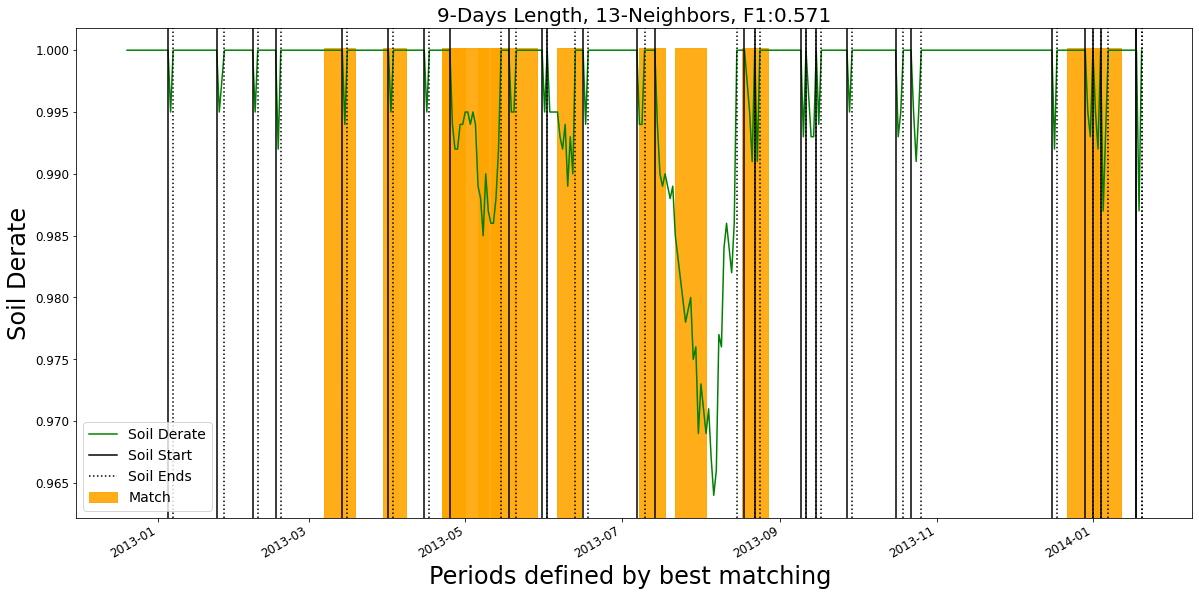

              precision    recall  f1-score   support

         0.0       0.73      0.83      0.77       218
         1.0       0.65      0.51      0.57       137

    accuracy                           0.70       355
   macro avg       0.69      0.67      0.67       355
weighted avg       0.70      0.70      0.70       355



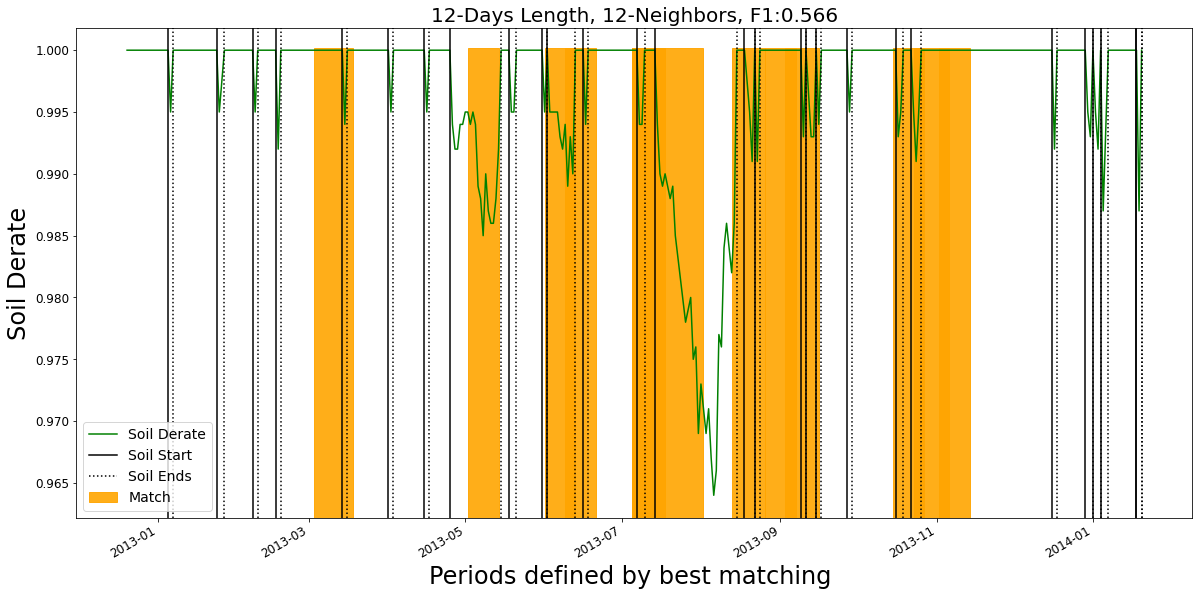

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74       218
         1.0       0.59      0.55      0.57       137

    accuracy                           0.68       355
   macro avg       0.66      0.65      0.65       355
weighted avg       0.67      0.68      0.67       355

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
2/2
cocoa.csv
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (331, 7)


We found 36 Soiling Events with decay less than 0.999 


  0%|          | 0/1196 [00:00<?, ?it/s]

  0%|          | 1/1196 [00:00<17:06,  1.16it/s]

  0%|          | 2/1196 [00:01<20:10,  1.01s/it]

  0%|          | 3/1196 [00:03<21:26,  1.08s/it]

  0%|          | 4/1196 [00:04<24:38,  1.24s/it]

  0%|          | 5/1196 [00:06<28:46,  1.45s/it]

  1%|          | 6/1196 [00:07<27:11,  1.37s/it]

  1%|          | 7/1196 [00:08<23:27,  1.18s/it]

  1%|          | 8/1196 [00:09<21:06,  1.07s/it]

  1%|          | 9/1196 [00:10<21:31,  1.09s/it]

  1%|          | 10/1196 [00:11<21:41,  1.10s/it]

  1%|          | 11/1196 [00:13<28:25,  1.44s/it]

  1%|          | 12/1196 [00:15<28:07,  1.43s/it]

  1%|          | 13/1196 [00:17<31:00,  1.57s/it]

  1%|          | 14/1196 [00:18<32:47,  1.66s/it]

  1%|▏         | 15/1196 [00:20<34:37,  1.76s/it]

  1%|▏         | 16/1196 [00:23<38:23,  1.95s/it]

  1%|▏         | 17/1196 [00:25<37:56,  1.93s/it]

  2%|▏         | 18/1196 [00:27<41:30,  2.11s/it]

  2%|▏         | 19/1196 [00:28<33:41,  1.72s/it]

  2%|▏         | 20/1196 [00:29<28:39,  1.46s/it]

  2%|▏         | 21/1196 [00:30<24:40,  1.26s/it]

  2%|▏         | 22/1196 [00:31<25:12,  1.29s/it]

  2%|▏         | 23/1196 [00:32<24:51,  1.27s/it]

  2%|▏         | 24/1196 [00:33<23:31,  1.20s/it]

  2%|▏         | 25/1196 [00:35<24:11,  1.24s/it]

  2%|▏         | 26/1196 [00:36<22:59,  1.18s/it]

  2%|▏         | 27/1196 [00:37<21:19,  1.09s/it]

  2%|▏         | 28/1196 [00:38<22:06,  1.14s/it]

  2%|▏         | 29/1196 [00:39<20:09,  1.04s/it]

  3%|▎         | 30/1196 [00:41<25:27,  1.31s/it]

  3%|▎         | 31/1196 [00:44<37:05,  1.91s/it]

  3%|▎         | 32/1196 [00:45<33:32,  1.73s/it]

  3%|▎         | 33/1196 [00:46<30:25,  1.57s/it]

  3%|▎         | 34/1196 [00:48<28:05,  1.45s/it]

  3%|▎         | 35/1196 [00:50<32:31,  1.68s/it]

  3%|▎         | 36/1196 [00:51<31:04,  1.61s/it]

  3%|▎         | 37/1196 [00:53<34:18,  1.78s/it]

  3%|▎         | 38/1196 [00:54<27:40,  1.43s/it]

  3%|▎         | 39/1196 [00:56<30:02,  1.56s/it]

  3%|▎         | 40/1196 [00:57<26:06,  1.35s/it]

  3%|▎         | 41/1196 [00:59<28:33,  1.48s/it]

  4%|▎         | 42/1196 [01:01<36:15,  1.89s/it]

  4%|▎         | 43/1196 [01:03<33:04,  1.72s/it]

  4%|▎         | 44/1196 [01:04<31:15,  1.63s/it]

  4%|▍         | 45/1196 [01:06<32:13,  1.68s/it]

  4%|▍         | 46/1196 [01:08<34:33,  1.80s/it]

  4%|▍         | 47/1196 [01:09<27:53,  1.46s/it]

  4%|▍         | 48/1196 [01:10<29:10,  1.53s/it]

  4%|▍         | 49/1196 [01:13<37:28,  1.96s/it]

  4%|▍         | 50/1196 [01:14<31:19,  1.64s/it]

  4%|▍         | 51/1196 [01:16<31:44,  1.66s/it]

  4%|▍         | 52/1196 [01:17<27:36,  1.45s/it]

  4%|▍         | 53/1196 [01:18<26:44,  1.40s/it]

  5%|▍         | 54/1196 [01:20<30:13,  1.59s/it]

  5%|▍         | 55/1196 [01:21<25:02,  1.32s/it]

  5%|▍         | 56/1196 [01:21<19:44,  1.04s/it]

  5%|▍         | 57/1196 [01:22<20:18,  1.07s/it]

  5%|▍         | 58/1196 [01:25<28:58,  1.53s/it]

  5%|▍         | 59/1196 [01:26<26:09,  1.38s/it]

  5%|▌         | 60/1196 [01:27<23:22,  1.23s/it]

  5%|▌         | 61/1196 [01:28<22:42,  1.20s/it]

  5%|▌         | 62/1196 [01:30<27:52,  1.47s/it]

  5%|▌         | 63/1196 [01:31<25:52,  1.37s/it]

  5%|▌         | 64/1196 [01:32<22:44,  1.21s/it]

  5%|▌         | 65/1196 [01:33<23:25,  1.24s/it]

  6%|▌         | 66/1196 [01:34<19:55,  1.06s/it]

  6%|▌         | 67/1196 [01:36<22:56,  1.22s/it]

  6%|▌         | 68/1196 [01:36<19:47,  1.05s/it]

  6%|▌         | 69/1196 [01:38<23:32,  1.25s/it]

  6%|▌         | 70/1196 [01:40<30:14,  1.61s/it]

  6%|▌         | 71/1196 [01:41<22:49,  1.22s/it]

  6%|▌         | 72/1196 [01:42<22:54,  1.22s/it]

  6%|▌         | 73/1196 [01:43<21:00,  1.12s/it]

  6%|▌         | 74/1196 [01:44<22:19,  1.19s/it]

  6%|▋         | 75/1196 [01:46<23:21,  1.25s/it]

  6%|▋         | 76/1196 [01:47<21:15,  1.14s/it]

  6%|▋         | 77/1196 [01:47<19:25,  1.04s/it]

  7%|▋         | 78/1196 [01:48<19:38,  1.05s/it]

  7%|▋         | 79/1196 [01:49<18:23,  1.01it/s]

  7%|▋         | 80/1196 [01:53<31:08,  1.67s/it]

  7%|▋         | 81/1196 [01:54<27:23,  1.47s/it]

  7%|▋         | 82/1196 [01:54<23:55,  1.29s/it]

  7%|▋         | 83/1196 [01:55<21:01,  1.13s/it]

  7%|▋         | 84/1196 [01:56<17:49,  1.04it/s]

  7%|▋         | 85/1196 [01:56<15:03,  1.23it/s]

  7%|▋         | 86/1196 [01:58<20:42,  1.12s/it]

  7%|▋         | 87/1196 [01:59<17:30,  1.06it/s]

  7%|▋         | 88/1196 [02:00<19:25,  1.05s/it]

  7%|▋         | 89/1196 [02:01<21:17,  1.15s/it]

  8%|▊         | 90/1196 [02:02<17:13,  1.07it/s]

  8%|▊         | 91/1196 [02:03<19:17,  1.05s/it]

  8%|▊         | 92/1196 [02:04<19:06,  1.04s/it]

  8%|▊         | 93/1196 [02:06<22:24,  1.22s/it]

  8%|▊         | 94/1196 [02:08<28:44,  1.57s/it]

  8%|▊         | 95/1196 [02:08<22:34,  1.23s/it]

  8%|▊         | 96/1196 [02:09<19:40,  1.07s/it]

  8%|▊         | 97/1196 [02:10<16:52,  1.09it/s]

  8%|▊         | 98/1196 [02:10<15:06,  1.21it/s]

  8%|▊         | 99/1196 [02:12<18:54,  1.03s/it]

  8%|▊         | 100/1196 [02:13<18:27,  1.01s/it]

  8%|▊         | 101/1196 [02:15<22:44,  1.25s/it]

  9%|▊         | 102/1196 [02:16<21:14,  1.17s/it]

  9%|▊         | 103/1196 [02:17<23:12,  1.27s/it]

  9%|▊         | 104/1196 [02:18<20:18,  1.12s/it]

  9%|▉         | 105/1196 [02:19<19:11,  1.06s/it]

  9%|▉         | 106/1196 [02:20<18:36,  1.02s/it]

  9%|▉         | 107/1196 [02:20<14:31,  1.25it/s]

  9%|▉         | 108/1196 [02:21<14:49,  1.22it/s]

  9%|▉         | 109/1196 [02:22<17:38,  1.03it/s]

  9%|▉         | 110/1196 [02:24<20:00,  1.11s/it]

  9%|▉         | 111/1196 [02:25<21:34,  1.19s/it]

  9%|▉         | 112/1196 [02:26<17:59,  1.00it/s]

  9%|▉         | 113/1196 [02:27<20:02,  1.11s/it]

 10%|▉         | 114/1196 [02:29<23:32,  1.31s/it]

 10%|▉         | 115/1196 [02:29<19:28,  1.08s/it]

 10%|▉         | 116/1196 [02:30<19:43,  1.10s/it]

 10%|▉         | 117/1196 [02:33<28:05,  1.56s/it]

 10%|▉         | 118/1196 [02:34<24:46,  1.38s/it]

 10%|▉         | 119/1196 [02:36<30:54,  1.72s/it]

 10%|█         | 120/1196 [02:37<26:34,  1.48s/it]

 10%|█         | 121/1196 [02:39<24:44,  1.38s/it]

 10%|█         | 122/1196 [02:39<20:50,  1.16s/it]

 10%|█         | 123/1196 [02:40<17:15,  1.04it/s]

 10%|█         | 124/1196 [02:41<18:44,  1.05s/it]

 10%|█         | 125/1196 [02:42<18:27,  1.03s/it]

 11%|█         | 126/1196 [02:45<26:49,  1.50s/it]

 11%|█         | 127/1196 [02:46<25:03,  1.41s/it]

 11%|█         | 128/1196 [02:46<20:48,  1.17s/it]

 11%|█         | 129/1196 [02:48<25:24,  1.43s/it]

 11%|█         | 130/1196 [02:49<21:54,  1.23s/it]

 11%|█         | 131/1196 [02:50<20:40,  1.16s/it]

 11%|█         | 132/1196 [02:51<19:23,  1.09s/it]

 11%|█         | 133/1196 [02:52<16:27,  1.08it/s]

 11%|█         | 134/1196 [02:52<14:12,  1.25it/s]

 11%|█▏        | 135/1196 [02:53<12:02,  1.47it/s]

 11%|█▏        | 136/1196 [02:54<15:30,  1.14it/s]

 11%|█▏        | 137/1196 [02:56<21:42,  1.23s/it]

 12%|█▏        | 138/1196 [02:57<20:57,  1.19s/it]

 12%|█▏        | 139/1196 [02:59<22:27,  1.28s/it]

 12%|█▏        | 140/1196 [02:59<20:31,  1.17s/it]

 12%|█▏        | 141/1196 [03:02<27:49,  1.58s/it]

 12%|█▏        | 142/1196 [03:03<27:06,  1.54s/it]

 12%|█▏        | 143/1196 [03:06<31:40,  1.81s/it]

 12%|█▏        | 144/1196 [03:08<32:13,  1.84s/it]

 12%|█▏        | 145/1196 [03:09<28:28,  1.63s/it]

 12%|█▏        | 146/1196 [03:10<25:07,  1.44s/it]

 12%|█▏        | 147/1196 [03:11<23:55,  1.37s/it]

 12%|█▏        | 148/1196 [03:11<18:01,  1.03s/it]

 12%|█▏        | 149/1196 [03:13<19:39,  1.13s/it]

 13%|█▎        | 150/1196 [03:14<20:20,  1.17s/it]

 13%|█▎        | 151/1196 [03:16<25:10,  1.45s/it]

 13%|█▎        | 152/1196 [03:17<20:43,  1.19s/it]

 13%|█▎        | 153/1196 [03:18<24:08,  1.39s/it]

 13%|█▎        | 154/1196 [03:19<20:14,  1.17s/it]

 13%|█▎        | 155/1196 [03:20<19:36,  1.13s/it]

 13%|█▎        | 156/1196 [03:21<17:37,  1.02s/it]

 13%|█▎        | 157/1196 [03:23<25:29,  1.47s/it]

 13%|█▎        | 158/1196 [03:25<28:00,  1.62s/it]

 13%|█▎        | 159/1196 [03:27<25:42,  1.49s/it]

 13%|█▎        | 160/1196 [03:27<22:21,  1.29s/it]

 13%|█▎        | 161/1196 [03:30<29:10,  1.69s/it]

 14%|█▎        | 162/1196 [03:31<26:24,  1.53s/it]

 14%|█▎        | 163/1196 [03:32<22:05,  1.28s/it]

 14%|█▎        | 164/1196 [03:33<23:25,  1.36s/it]

 14%|█▍        | 165/1196 [03:35<25:28,  1.48s/it]

 14%|█▍        | 166/1196 [03:36<20:11,  1.18s/it]

 14%|█▍        | 167/1196 [03:37<19:56,  1.16s/it]

 14%|█▍        | 168/1196 [03:38<20:39,  1.21s/it]

 14%|█▍        | 169/1196 [03:39<17:17,  1.01s/it]

 14%|█▍        | 170/1196 [03:39<14:54,  1.15it/s]

 14%|█▍        | 171/1196 [03:41<20:06,  1.18s/it]

 14%|█▍        | 172/1196 [03:43<24:41,  1.45s/it]

 14%|█▍        | 173/1196 [03:45<26:57,  1.58s/it]

 15%|█▍        | 174/1196 [03:46<23:15,  1.37s/it]

 15%|█▍        | 175/1196 [03:48<28:04,  1.65s/it]

 15%|█▍        | 176/1196 [03:50<27:35,  1.62s/it]

 15%|█▍        | 177/1196 [03:51<25:02,  1.47s/it]

 15%|█▍        | 178/1196 [03:52<24:54,  1.47s/it]

 15%|█▍        | 179/1196 [03:54<23:34,  1.39s/it]

 15%|█▌        | 180/1196 [03:56<27:36,  1.63s/it]

 15%|█▌        | 181/1196 [03:57<26:19,  1.56s/it]

 15%|█▌        | 182/1196 [03:59<25:36,  1.51s/it]

 15%|█▌        | 183/1196 [04:00<24:02,  1.42s/it]

 15%|█▌        | 184/1196 [04:02<25:58,  1.54s/it]

 15%|█▌        | 185/1196 [04:02<20:04,  1.19s/it]

 16%|█▌        | 186/1196 [04:03<19:07,  1.14s/it]

 16%|█▌        | 187/1196 [04:04<17:43,  1.05s/it]

 16%|█▌        | 188/1196 [04:06<21:48,  1.30s/it]

 16%|█▌        | 189/1196 [04:07<22:08,  1.32s/it]

 16%|█▌        | 190/1196 [04:09<22:43,  1.36s/it]

 16%|█▌        | 191/1196 [04:12<32:13,  1.92s/it]

 16%|█▌        | 192/1196 [04:13<29:12,  1.75s/it]

 16%|█▌        | 193/1196 [04:14<26:08,  1.56s/it]

 16%|█▌        | 194/1196 [04:15<22:22,  1.34s/it]

 16%|█▋        | 195/1196 [04:16<19:35,  1.17s/it]

 16%|█▋        | 196/1196 [04:17<19:46,  1.19s/it]

 16%|█▋        | 197/1196 [04:18<16:41,  1.00s/it]

 17%|█▋        | 198/1196 [04:19<15:46,  1.05it/s]

 17%|█▋        | 199/1196 [04:21<24:18,  1.46s/it]

 17%|█▋        | 200/1196 [04:22<22:18,  1.34s/it]

 17%|█▋        | 201/1196 [04:24<22:17,  1.34s/it]

 17%|█▋        | 202/1196 [04:25<21:56,  1.32s/it]

 17%|█▋        | 203/1196 [04:26<22:41,  1.37s/it]

 17%|█▋        | 204/1196 [04:28<25:37,  1.55s/it]

 17%|█▋        | 205/1196 [04:29<22:21,  1.35s/it]

 17%|█▋        | 206/1196 [04:30<18:14,  1.11s/it]

 17%|█▋        | 207/1196 [04:30<16:04,  1.03it/s]

 17%|█▋        | 208/1196 [04:32<17:42,  1.08s/it]

 17%|█▋        | 209/1196 [04:32<15:38,  1.05it/s]

 18%|█▊        | 210/1196 [04:34<16:50,  1.03s/it]

 18%|█▊        | 211/1196 [04:34<14:40,  1.12it/s]

 18%|█▊        | 212/1196 [04:36<18:32,  1.13s/it]

 18%|█▊        | 213/1196 [04:37<19:30,  1.19s/it]

 18%|█▊        | 214/1196 [04:39<22:56,  1.40s/it]

 18%|█▊        | 215/1196 [04:40<22:35,  1.38s/it]

 18%|█▊        | 216/1196 [04:41<19:21,  1.19s/it]

 18%|█▊        | 217/1196 [04:42<18:29,  1.13s/it]

 18%|█▊        | 218/1196 [04:43<17:05,  1.05s/it]

 18%|█▊        | 219/1196 [04:44<15:29,  1.05it/s]

 18%|█▊        | 220/1196 [04:44<14:07,  1.15it/s]

 18%|█▊        | 221/1196 [04:45<13:57,  1.16it/s]

 19%|█▊        | 222/1196 [04:46<13:13,  1.23it/s]

 19%|█▊        | 223/1196 [04:47<15:40,  1.03it/s]

 19%|█▊        | 224/1196 [04:49<17:33,  1.08s/it]

 19%|█▉        | 225/1196 [04:50<18:12,  1.12s/it]

 19%|█▉        | 226/1196 [04:51<18:04,  1.12s/it]

 19%|█▉        | 227/1196 [04:52<16:25,  1.02s/it]

 19%|█▉        | 228/1196 [04:53<17:58,  1.11s/it]

 19%|█▉        | 229/1196 [04:54<18:50,  1.17s/it]

 19%|█▉        | 230/1196 [04:55<17:30,  1.09s/it]

 19%|█▉        | 231/1196 [04:57<20:40,  1.29s/it]

 19%|█▉        | 232/1196 [04:58<20:14,  1.26s/it]

 19%|█▉        | 233/1196 [04:59<17:32,  1.09s/it]

 20%|█▉        | 234/1196 [05:02<26:00,  1.62s/it]

 20%|█▉        | 235/1196 [05:03<22:14,  1.39s/it]

 20%|█▉        | 236/1196 [05:04<20:38,  1.29s/it]

 20%|█▉        | 237/1196 [05:05<19:29,  1.22s/it]

 20%|█▉        | 238/1196 [05:06<18:23,  1.15s/it]

 20%|█▉        | 239/1196 [05:08<21:48,  1.37s/it]

 20%|██        | 240/1196 [05:10<24:26,  1.53s/it]

 20%|██        | 241/1196 [05:11<23:18,  1.46s/it]

 20%|██        | 242/1196 [05:12<22:13,  1.40s/it]

 20%|██        | 243/1196 [05:13<21:28,  1.35s/it]

 20%|██        | 244/1196 [05:14<20:10,  1.27s/it]

 20%|██        | 245/1196 [05:17<27:07,  1.71s/it]

 21%|██        | 246/1196 [05:20<30:24,  1.92s/it]

 21%|██        | 247/1196 [05:21<27:32,  1.74s/it]

 21%|██        | 248/1196 [05:23<30:45,  1.95s/it]

 21%|██        | 249/1196 [05:24<25:00,  1.59s/it]

 21%|██        | 250/1196 [05:26<27:08,  1.72s/it]

 21%|██        | 251/1196 [05:27<22:54,  1.45s/it]

 21%|██        | 252/1196 [05:29<28:10,  1.79s/it]

 21%|██        | 253/1196 [05:31<24:36,  1.57s/it]

 21%|██        | 254/1196 [05:31<19:22,  1.23s/it]

 21%|██▏       | 255/1196 [05:32<17:42,  1.13s/it]

 21%|██▏       | 256/1196 [05:33<17:41,  1.13s/it]

 21%|██▏       | 257/1196 [05:33<14:06,  1.11it/s]

 22%|██▏       | 258/1196 [05:34<13:47,  1.13it/s]

 22%|██▏       | 259/1196 [05:38<27:00,  1.73s/it]

 22%|██▏       | 260/1196 [05:40<27:43,  1.78s/it]

 22%|██▏       | 261/1196 [05:41<25:30,  1.64s/it]

 22%|██▏       | 262/1196 [05:43<27:46,  1.78s/it]

 22%|██▏       | 263/1196 [05:46<31:34,  2.03s/it]

 22%|██▏       | 264/1196 [05:46<23:40,  1.52s/it]

 22%|██▏       | 265/1196 [05:47<19:18,  1.24s/it]

 22%|██▏       | 266/1196 [05:49<23:18,  1.50s/it]

 22%|██▏       | 267/1196 [05:50<22:58,  1.48s/it]

 22%|██▏       | 268/1196 [05:51<18:52,  1.22s/it]

 22%|██▏       | 269/1196 [05:53<21:55,  1.42s/it]

 23%|██▎       | 270/1196 [05:54<21:04,  1.37s/it]

 23%|██▎       | 271/1196 [05:56<25:54,  1.68s/it]

 23%|██▎       | 272/1196 [05:57<21:51,  1.42s/it]

 23%|██▎       | 273/1196 [05:58<16:43,  1.09s/it]

 23%|██▎       | 274/1196 [05:59<16:25,  1.07s/it]

 23%|██▎       | 275/1196 [06:00<17:25,  1.13s/it]

 23%|██▎       | 276/1196 [06:02<21:11,  1.38s/it]

 23%|██▎       | 277/1196 [06:04<23:44,  1.55s/it]

 23%|██▎       | 278/1196 [06:06<26:48,  1.75s/it]

 23%|██▎       | 279/1196 [06:08<27:03,  1.77s/it]

 23%|██▎       | 280/1196 [06:09<25:11,  1.65s/it]

 23%|██▎       | 281/1196 [06:11<23:36,  1.55s/it]

 24%|██▎       | 282/1196 [06:12<21:51,  1.43s/it]

 24%|██▎       | 283/1196 [06:14<25:01,  1.64s/it]

 24%|██▎       | 284/1196 [06:16<29:38,  1.95s/it]

 24%|██▍       | 285/1196 [06:18<27:25,  1.81s/it]

 24%|██▍       | 286/1196 [06:19<24:09,  1.59s/it]

 24%|██▍       | 287/1196 [06:20<23:04,  1.52s/it]

 24%|██▍       | 288/1196 [06:23<29:53,  1.98s/it]

 24%|██▍       | 289/1196 [06:26<31:21,  2.07s/it]

 24%|██▍       | 290/1196 [06:26<24:02,  1.59s/it]

 24%|██▍       | 291/1196 [06:28<23:03,  1.53s/it]

 24%|██▍       | 292/1196 [06:28<19:46,  1.31s/it]

 24%|██▍       | 293/1196 [06:30<20:00,  1.33s/it]

 25%|██▍       | 294/1196 [06:31<17:59,  1.20s/it]

 25%|██▍       | 295/1196 [06:31<16:05,  1.07s/it]

 25%|██▍       | 296/1196 [06:33<18:31,  1.24s/it]

 25%|██▍       | 297/1196 [06:35<22:41,  1.51s/it]

 25%|██▍       | 298/1196 [06:36<18:24,  1.23s/it]

 25%|██▌       | 299/1196 [06:38<23:03,  1.54s/it]

 25%|██▌       | 300/1196 [06:39<21:36,  1.45s/it]

 25%|██▌       | 301/1196 [06:41<23:11,  1.56s/it]

 25%|██▌       | 302/1196 [06:42<19:00,  1.28s/it]

 25%|██▌       | 303/1196 [06:44<21:51,  1.47s/it]

 25%|██▌       | 304/1196 [06:44<18:42,  1.26s/it]

 26%|██▌       | 305/1196 [06:48<27:02,  1.82s/it]

 26%|██▌       | 306/1196 [06:49<24:40,  1.66s/it]

 26%|██▌       | 307/1196 [06:50<23:16,  1.57s/it]

 26%|██▌       | 308/1196 [06:51<19:15,  1.30s/it]

 26%|██▌       | 309/1196 [06:53<21:28,  1.45s/it]

 26%|██▌       | 310/1196 [06:54<20:52,  1.41s/it]

 26%|██▌       | 311/1196 [06:57<26:38,  1.81s/it]

 26%|██▌       | 312/1196 [06:58<25:07,  1.71s/it]

 26%|██▌       | 313/1196 [06:59<22:28,  1.53s/it]

 26%|██▋       | 314/1196 [07:01<24:20,  1.66s/it]

 26%|██▋       | 315/1196 [07:03<22:42,  1.55s/it]

 26%|██▋       | 316/1196 [07:03<19:20,  1.32s/it]

 27%|██▋       | 317/1196 [07:05<19:17,  1.32s/it]

 27%|██▋       | 318/1196 [07:06<19:35,  1.34s/it]

 27%|██▋       | 319/1196 [07:08<21:43,  1.49s/it]

 27%|██▋       | 320/1196 [07:09<18:50,  1.29s/it]

 27%|██▋       | 321/1196 [07:10<16:50,  1.15s/it]

 27%|██▋       | 322/1196 [07:10<14:21,  1.01it/s]

 27%|██▋       | 323/1196 [07:11<15:36,  1.07s/it]

 27%|██▋       | 324/1196 [07:12<15:15,  1.05s/it]

 27%|██▋       | 325/1196 [07:14<16:35,  1.14s/it]

 27%|██▋       | 326/1196 [07:16<20:48,  1.44s/it]

 27%|██▋       | 327/1196 [07:16<17:17,  1.19s/it]

 27%|██▋       | 328/1196 [07:17<15:33,  1.08s/it]

 28%|██▊       | 329/1196 [07:18<13:30,  1.07it/s]

 28%|██▊       | 330/1196 [07:19<12:39,  1.14it/s]

 28%|██▊       | 331/1196 [07:21<17:37,  1.22s/it]

 28%|██▊       | 332/1196 [07:22<17:47,  1.24s/it]

 28%|██▊       | 333/1196 [07:23<18:42,  1.30s/it]

 28%|██▊       | 334/1196 [07:24<17:13,  1.20s/it]

 28%|██▊       | 335/1196 [07:26<19:59,  1.39s/it]

 28%|██▊       | 336/1196 [07:28<19:49,  1.38s/it]

 28%|██▊       | 337/1196 [07:30<25:16,  1.77s/it]

 28%|██▊       | 338/1196 [07:31<22:58,  1.61s/it]

 28%|██▊       | 339/1196 [07:32<20:31,  1.44s/it]

 28%|██▊       | 340/1196 [07:34<20:08,  1.41s/it]

 29%|██▊       | 341/1196 [07:37<27:35,  1.94s/it]

 29%|██▊       | 342/1196 [07:39<28:16,  1.99s/it]

 29%|██▊       | 343/1196 [07:41<26:13,  1.84s/it]

 29%|██▉       | 344/1196 [07:41<21:10,  1.49s/it]

 29%|██▉       | 345/1196 [07:43<23:22,  1.65s/it]

 29%|██▉       | 346/1196 [07:45<24:42,  1.74s/it]

 29%|██▉       | 347/1196 [07:46<21:22,  1.51s/it]

 29%|██▉       | 348/1196 [07:48<24:19,  1.72s/it]

 29%|██▉       | 349/1196 [07:51<26:14,  1.86s/it]

 29%|██▉       | 350/1196 [07:52<25:58,  1.84s/it]

 29%|██▉       | 351/1196 [07:54<26:30,  1.88s/it]

 29%|██▉       | 352/1196 [07:56<26:21,  1.87s/it]

 30%|██▉       | 353/1196 [07:58<23:45,  1.69s/it]

 30%|██▉       | 354/1196 [07:59<23:36,  1.68s/it]

 30%|██▉       | 355/1196 [08:01<25:53,  1.85s/it]

 30%|██▉       | 356/1196 [08:03<25:54,  1.85s/it]

 30%|██▉       | 357/1196 [08:04<20:42,  1.48s/it]

 30%|██▉       | 358/1196 [08:06<22:59,  1.65s/it]

 30%|███       | 359/1196 [08:07<22:32,  1.62s/it]

 30%|███       | 360/1196 [08:09<22:19,  1.60s/it]

 30%|███       | 361/1196 [08:11<23:55,  1.72s/it]

 30%|███       | 362/1196 [08:13<24:52,  1.79s/it]

 30%|███       | 363/1196 [08:14<21:50,  1.57s/it]

 30%|███       | 364/1196 [08:16<22:07,  1.60s/it]

 31%|███       | 365/1196 [08:17<19:58,  1.44s/it]

 31%|███       | 366/1196 [08:19<23:37,  1.71s/it]

 31%|███       | 367/1196 [08:20<19:34,  1.42s/it]

 31%|███       | 368/1196 [08:21<18:57,  1.37s/it]

 31%|███       | 369/1196 [08:22<18:49,  1.37s/it]

 31%|███       | 370/1196 [08:24<19:43,  1.43s/it]

 31%|███       | 371/1196 [08:26<21:28,  1.56s/it]

 31%|███       | 372/1196 [08:28<22:41,  1.65s/it]

 31%|███       | 373/1196 [08:30<25:00,  1.82s/it]

 31%|███▏      | 374/1196 [08:32<23:47,  1.74s/it]

 31%|███▏      | 375/1196 [08:33<21:54,  1.60s/it]

 31%|███▏      | 376/1196 [08:35<25:02,  1.83s/it]

 32%|███▏      | 377/1196 [08:37<24:39,  1.81s/it]

 32%|███▏      | 378/1196 [08:39<24:29,  1.80s/it]

 32%|███▏      | 379/1196 [08:40<22:40,  1.67s/it]

 32%|███▏      | 380/1196 [08:41<20:20,  1.50s/it]

 32%|███▏      | 381/1196 [08:42<17:28,  1.29s/it]

 32%|███▏      | 382/1196 [08:44<21:32,  1.59s/it]

 32%|███▏      | 383/1196 [08:46<20:04,  1.48s/it]

 32%|███▏      | 384/1196 [08:48<22:40,  1.68s/it]

 32%|███▏      | 385/1196 [08:50<25:19,  1.87s/it]

 32%|███▏      | 386/1196 [08:51<21:09,  1.57s/it]

 32%|███▏      | 387/1196 [08:53<22:38,  1.68s/it]

 32%|███▏      | 388/1196 [08:56<29:17,  2.17s/it]

 33%|███▎      | 389/1196 [08:57<25:50,  1.92s/it]

 33%|███▎      | 390/1196 [08:59<23:13,  1.73s/it]

 33%|███▎      | 391/1196 [09:00<20:19,  1.51s/it]

 33%|███▎      | 392/1196 [09:01<20:17,  1.51s/it]

 33%|███▎      | 393/1196 [09:02<17:11,  1.28s/it]

 33%|███▎      | 394/1196 [09:03<16:15,  1.22s/it]

 33%|███▎      | 395/1196 [09:04<16:55,  1.27s/it]

 33%|███▎      | 396/1196 [09:06<17:15,  1.29s/it]

 33%|███▎      | 397/1196 [09:07<15:21,  1.15s/it]

 33%|███▎      | 398/1196 [09:09<18:56,  1.42s/it]

 33%|███▎      | 399/1196 [09:10<18:41,  1.41s/it]

 33%|███▎      | 400/1196 [09:13<23:32,  1.77s/it]

 34%|███▎      | 401/1196 [09:14<22:43,  1.72s/it]

 34%|███▎      | 402/1196 [09:15<19:38,  1.48s/it]

 34%|███▎      | 403/1196 [09:17<22:07,  1.67s/it]

 34%|███▍      | 404/1196 [09:19<23:28,  1.78s/it]

 34%|███▍      | 405/1196 [09:21<21:15,  1.61s/it]

 34%|███▍      | 406/1196 [09:22<19:16,  1.46s/it]

 34%|███▍      | 407/1196 [09:24<20:59,  1.60s/it]

 34%|███▍      | 408/1196 [09:25<22:07,  1.69s/it]

 34%|███▍      | 409/1196 [09:29<28:27,  2.17s/it]

 34%|███▍      | 410/1196 [09:31<27:34,  2.11s/it]

 34%|███▍      | 411/1196 [09:32<23:21,  1.79s/it]

 34%|███▍      | 412/1196 [09:32<18:31,  1.42s/it]

 35%|███▍      | 413/1196 [09:33<17:11,  1.32s/it]

 35%|███▍      | 414/1196 [09:35<19:49,  1.52s/it]

 35%|███▍      | 415/1196 [09:37<21:27,  1.65s/it]

 35%|███▍      | 416/1196 [09:38<16:49,  1.29s/it]

 35%|███▍      | 417/1196 [09:38<13:45,  1.06s/it]

 35%|███▍      | 418/1196 [09:40<15:38,  1.21s/it]

 35%|███▌      | 419/1196 [09:43<21:52,  1.69s/it]

 35%|███▌      | 420/1196 [09:44<19:22,  1.50s/it]

 35%|███▌      | 421/1196 [09:46<21:56,  1.70s/it]

 35%|███▌      | 422/1196 [09:47<20:47,  1.61s/it]

 35%|███▌      | 423/1196 [09:48<18:34,  1.44s/it]

 35%|███▌      | 424/1196 [09:50<20:18,  1.58s/it]

 36%|███▌      | 425/1196 [09:52<21:02,  1.64s/it]

 36%|███▌      | 426/1196 [09:53<19:53,  1.55s/it]

 36%|███▌      | 427/1196 [09:55<21:11,  1.65s/it]

 36%|███▌      | 428/1196 [09:58<24:27,  1.91s/it]

 36%|███▌      | 429/1196 [09:59<22:08,  1.73s/it]

 36%|███▌      | 430/1196 [10:01<22:46,  1.78s/it]

 36%|███▌      | 431/1196 [10:02<21:30,  1.69s/it]

 36%|███▌      | 432/1196 [10:03<18:39,  1.47s/it]

 36%|███▌      | 433/1196 [10:04<15:56,  1.25s/it]

 36%|███▋      | 434/1196 [10:06<18:00,  1.42s/it]

 36%|███▋      | 435/1196 [10:07<15:53,  1.25s/it]

 36%|███▋      | 436/1196 [10:09<17:25,  1.38s/it]

 37%|███▋      | 437/1196 [10:09<15:27,  1.22s/it]

 37%|███▋      | 438/1196 [10:13<23:19,  1.85s/it]

 37%|███▋      | 439/1196 [10:14<22:33,  1.79s/it]

 37%|███▋      | 440/1196 [10:16<20:43,  1.64s/it]

 37%|███▋      | 441/1196 [10:17<21:06,  1.68s/it]

 37%|███▋      | 442/1196 [10:19<19:26,  1.55s/it]

 37%|███▋      | 443/1196 [10:21<23:58,  1.91s/it]

 37%|███▋      | 444/1196 [10:23<21:24,  1.71s/it]

 37%|███▋      | 445/1196 [10:24<20:20,  1.62s/it]

 37%|███▋      | 446/1196 [10:27<24:23,  1.95s/it]

 37%|███▋      | 447/1196 [10:30<27:24,  2.20s/it]

 37%|███▋      | 448/1196 [10:31<24:23,  1.96s/it]

 38%|███▊      | 449/1196 [10:31<18:24,  1.48s/it]

 38%|███▊      | 450/1196 [10:33<19:56,  1.60s/it]

 38%|███▊      | 451/1196 [10:34<17:06,  1.38s/it]

 38%|███▊      | 452/1196 [10:35<17:03,  1.38s/it]

 38%|███▊      | 453/1196 [10:37<16:54,  1.37s/it]

 38%|███▊      | 454/1196 [10:39<19:14,  1.56s/it]

 38%|███▊      | 455/1196 [10:41<23:25,  1.90s/it]

 38%|███▊      | 456/1196 [10:43<20:48,  1.69s/it]

 38%|███▊      | 457/1196 [10:44<19:49,  1.61s/it]

 38%|███▊      | 458/1196 [10:46<20:35,  1.67s/it]

 38%|███▊      | 459/1196 [10:47<19:05,  1.55s/it]

 38%|███▊      | 460/1196 [10:50<25:12,  2.05s/it]

 39%|███▊      | 461/1196 [10:52<22:47,  1.86s/it]

 39%|███▊      | 462/1196 [10:54<23:55,  1.96s/it]

 39%|███▊      | 463/1196 [10:56<25:51,  2.12s/it]

 39%|███▉      | 464/1196 [10:59<28:02,  2.30s/it]

 39%|███▉      | 465/1196 [11:02<29:02,  2.38s/it]

 39%|███▉      | 466/1196 [11:03<24:56,  2.05s/it]

 39%|███▉      | 467/1196 [11:04<21:58,  1.81s/it]

 39%|███▉      | 468/1196 [11:07<23:50,  1.96s/it]

 39%|███▉      | 469/1196 [11:07<19:19,  1.60s/it]

 39%|███▉      | 470/1196 [11:08<15:55,  1.32s/it]

 39%|███▉      | 471/1196 [11:10<17:47,  1.47s/it]

 39%|███▉      | 472/1196 [11:11<17:44,  1.47s/it]

 40%|███▉      | 473/1196 [11:12<14:40,  1.22s/it]

 40%|███▉      | 474/1196 [11:13<14:45,  1.23s/it]

 40%|███▉      | 475/1196 [11:15<15:17,  1.27s/it]

 40%|███▉      | 476/1196 [11:17<17:45,  1.48s/it]

 40%|███▉      | 477/1196 [11:17<15:51,  1.32s/it]

 40%|███▉      | 478/1196 [11:19<15:43,  1.31s/it]

 40%|████      | 479/1196 [11:20<14:47,  1.24s/it]

 40%|████      | 480/1196 [11:22<19:44,  1.65s/it]

 40%|████      | 481/1196 [11:25<21:42,  1.82s/it]

 40%|████      | 482/1196 [11:27<25:09,  2.11s/it]

 40%|████      | 483/1196 [11:29<22:17,  1.88s/it]

 40%|████      | 484/1196 [11:31<22:37,  1.91s/it]

 41%|████      | 485/1196 [11:32<19:54,  1.68s/it]

 41%|████      | 486/1196 [11:34<19:31,  1.65s/it]

 41%|████      | 487/1196 [11:34<16:32,  1.40s/it]

 41%|████      | 488/1196 [11:38<23:19,  1.98s/it]

 41%|████      | 489/1196 [11:40<24:57,  2.12s/it]

 41%|████      | 490/1196 [11:42<25:46,  2.19s/it]

 41%|████      | 491/1196 [11:43<21:03,  1.79s/it]

 41%|████      | 492/1196 [11:45<19:45,  1.68s/it]

 41%|████      | 493/1196 [11:47<20:16,  1.73s/it]

 41%|████▏     | 494/1196 [11:48<18:09,  1.55s/it]

 41%|████▏     | 495/1196 [11:49<16:35,  1.42s/it]

 41%|████▏     | 496/1196 [11:51<18:59,  1.63s/it]

 42%|████▏     | 497/1196 [11:52<15:30,  1.33s/it]

 42%|████▏     | 498/1196 [11:53<17:22,  1.49s/it]

 42%|████▏     | 499/1196 [11:56<22:29,  1.94s/it]

 42%|████▏     | 500/1196 [11:58<20:13,  1.74s/it]

 42%|████▏     | 501/1196 [12:00<20:35,  1.78s/it]

 42%|████▏     | 502/1196 [12:02<22:30,  1.95s/it]

 42%|████▏     | 503/1196 [12:03<17:53,  1.55s/it]

 42%|████▏     | 504/1196 [12:04<17:03,  1.48s/it]

 42%|████▏     | 505/1196 [12:06<17:48,  1.55s/it]

 42%|████▏     | 506/1196 [12:07<16:01,  1.39s/it]

 42%|████▏     | 507/1196 [12:08<15:51,  1.38s/it]

 42%|████▏     | 508/1196 [12:10<18:05,  1.58s/it]

 43%|████▎     | 509/1196 [12:11<15:28,  1.35s/it]

 43%|████▎     | 510/1196 [12:13<18:21,  1.61s/it]

 43%|████▎     | 511/1196 [12:14<15:45,  1.38s/it]

 43%|████▎     | 512/1196 [12:16<19:50,  1.74s/it]

 43%|████▎     | 513/1196 [12:19<22:34,  1.98s/it]

 43%|████▎     | 514/1196 [12:20<18:31,  1.63s/it]

 43%|████▎     | 515/1196 [12:22<19:39,  1.73s/it]

 43%|████▎     | 516/1196 [12:23<18:38,  1.64s/it]

 43%|████▎     | 517/1196 [12:26<21:02,  1.86s/it]

 43%|████▎     | 518/1196 [12:28<24:11,  2.14s/it]

 43%|████▎     | 519/1196 [12:30<23:09,  2.05s/it]

 43%|████▎     | 520/1196 [12:32<21:04,  1.87s/it]

 44%|████▎     | 521/1196 [12:33<19:43,  1.75s/it]

 44%|████▎     | 522/1196 [12:36<21:43,  1.93s/it]

 44%|████▎     | 523/1196 [12:38<22:26,  2.00s/it]

 44%|████▍     | 524/1196 [12:39<19:44,  1.76s/it]

 44%|████▍     | 525/1196 [12:40<17:56,  1.60s/it]

 44%|████▍     | 526/1196 [12:41<15:42,  1.41s/it]

 44%|████▍     | 527/1196 [12:43<16:00,  1.44s/it]

 44%|████▍     | 528/1196 [12:45<19:01,  1.71s/it]

 44%|████▍     | 529/1196 [12:46<18:34,  1.67s/it]

 44%|████▍     | 530/1196 [12:48<17:27,  1.57s/it]

 44%|████▍     | 531/1196 [12:49<15:32,  1.40s/it]

 44%|████▍     | 532/1196 [12:50<14:26,  1.30s/it]

 45%|████▍     | 533/1196 [12:52<17:06,  1.55s/it]

 45%|████▍     | 534/1196 [12:54<19:05,  1.73s/it]

 45%|████▍     | 535/1196 [12:56<20:21,  1.85s/it]

 45%|████▍     | 536/1196 [12:58<18:53,  1.72s/it]

 45%|████▍     | 537/1196 [13:00<19:29,  1.77s/it]

 45%|████▍     | 538/1196 [13:00<14:42,  1.34s/it]

 45%|████▌     | 539/1196 [13:02<15:31,  1.42s/it]

 45%|████▌     | 540/1196 [13:03<15:26,  1.41s/it]

 45%|████▌     | 541/1196 [13:05<16:41,  1.53s/it]

 45%|████▌     | 542/1196 [13:07<18:54,  1.73s/it]

 45%|████▌     | 543/1196 [13:07<14:12,  1.31s/it]

 45%|████▌     | 544/1196 [13:09<15:05,  1.39s/it]

 46%|████▌     | 545/1196 [13:10<15:23,  1.42s/it]

 46%|████▌     | 546/1196 [13:12<16:08,  1.49s/it]

 46%|████▌     | 547/1196 [13:13<16:08,  1.49s/it]

 46%|████▌     | 548/1196 [13:15<15:05,  1.40s/it]

 46%|████▌     | 549/1196 [13:16<16:16,  1.51s/it]

 46%|████▌     | 550/1196 [13:17<14:33,  1.35s/it]

 46%|████▌     | 551/1196 [13:18<12:07,  1.13s/it]

 46%|████▌     | 552/1196 [13:19<11:23,  1.06s/it]

 46%|████▌     | 553/1196 [13:20<09:53,  1.08it/s]

 46%|████▋     | 554/1196 [13:21<11:43,  1.10s/it]

 46%|████▋     | 555/1196 [13:24<16:08,  1.51s/it]

 46%|████▋     | 556/1196 [13:25<15:41,  1.47s/it]

 47%|████▋     | 557/1196 [13:26<15:25,  1.45s/it]

 47%|████▋     | 558/1196 [13:28<15:03,  1.42s/it]

 47%|████▋     | 559/1196 [13:31<21:05,  1.99s/it]

 47%|████▋     | 560/1196 [13:33<20:32,  1.94s/it]

 47%|████▋     | 561/1196 [13:34<18:26,  1.74s/it]

 47%|████▋     | 562/1196 [13:36<17:55,  1.70s/it]

 47%|████▋     | 563/1196 [13:37<16:05,  1.53s/it]

 47%|████▋     | 564/1196 [13:37<13:20,  1.27s/it]

 47%|████▋     | 565/1196 [13:39<15:24,  1.47s/it]

 47%|████▋     | 566/1196 [13:41<15:09,  1.44s/it]

 47%|████▋     | 567/1196 [13:42<14:49,  1.41s/it]

 47%|████▋     | 568/1196 [13:43<13:59,  1.34s/it]

 48%|████▊     | 569/1196 [13:45<14:36,  1.40s/it]

 48%|████▊     | 570/1196 [13:47<16:39,  1.60s/it]

 48%|████▊     | 571/1196 [13:48<15:06,  1.45s/it]

 48%|████▊     | 572/1196 [13:48<12:09,  1.17s/it]

 48%|████▊     | 573/1196 [13:51<15:56,  1.54s/it]

 48%|████▊     | 574/1196 [13:53<17:04,  1.65s/it]

 48%|████▊     | 575/1196 [13:54<14:44,  1.42s/it]

 48%|████▊     | 576/1196 [13:55<13:53,  1.34s/it]

 48%|████▊     | 577/1196 [13:56<12:59,  1.26s/it]

 48%|████▊     | 578/1196 [13:58<16:39,  1.62s/it]

 48%|████▊     | 579/1196 [13:59<13:44,  1.34s/it]

 48%|████▊     | 580/1196 [14:01<14:30,  1.41s/it]

 49%|████▊     | 581/1196 [14:02<14:18,  1.40s/it]

 49%|████▊     | 582/1196 [14:03<13:44,  1.34s/it]

 49%|████▊     | 583/1196 [14:06<17:12,  1.68s/it]

 49%|████▉     | 584/1196 [14:07<16:16,  1.60s/it]

 49%|████▉     | 585/1196 [14:08<14:33,  1.43s/it]

 49%|████▉     | 586/1196 [14:11<18:25,  1.81s/it]

 49%|████▉     | 587/1196 [14:12<15:36,  1.54s/it]

 49%|████▉     | 588/1196 [14:13<13:31,  1.33s/it]

 49%|████▉     | 589/1196 [14:15<16:12,  1.60s/it]

 49%|████▉     | 590/1196 [14:16<15:29,  1.53s/it]

 49%|████▉     | 591/1196 [14:18<16:17,  1.62s/it]

 49%|████▉     | 592/1196 [14:18<12:25,  1.23s/it]

 50%|████▉     | 593/1196 [14:21<15:54,  1.58s/it]

 50%|████▉     | 594/1196 [14:21<12:22,  1.23s/it]

 50%|████▉     | 595/1196 [14:24<15:56,  1.59s/it]

 50%|████▉     | 596/1196 [14:25<15:22,  1.54s/it]

 50%|████▉     | 597/1196 [14:26<13:19,  1.33s/it]

 50%|█████     | 598/1196 [14:28<15:57,  1.60s/it]

 50%|█████     | 599/1196 [14:30<17:01,  1.71s/it]

 50%|█████     | 600/1196 [14:32<18:35,  1.87s/it]

 50%|█████     | 601/1196 [14:33<14:33,  1.47s/it]

 50%|█████     | 602/1196 [14:34<13:03,  1.32s/it]

 50%|█████     | 603/1196 [14:37<17:47,  1.80s/it]

 51%|█████     | 604/1196 [14:37<14:16,  1.45s/it]

 51%|█████     | 605/1196 [14:38<11:34,  1.17s/it]

 51%|█████     | 606/1196 [14:39<12:34,  1.28s/it]

 51%|█████     | 607/1196 [14:41<12:24,  1.26s/it]

 51%|█████     | 608/1196 [14:42<12:29,  1.28s/it]

 51%|█████     | 609/1196 [14:43<10:31,  1.08s/it]

 51%|█████     | 610/1196 [14:44<11:27,  1.17s/it]

 51%|█████     | 611/1196 [14:45<12:00,  1.23s/it]

 51%|█████     | 612/1196 [14:46<10:28,  1.08s/it]

 51%|█████▏    | 613/1196 [14:48<14:11,  1.46s/it]

 51%|█████▏    | 614/1196 [14:52<19:28,  2.01s/it]

 51%|█████▏    | 615/1196 [14:53<16:45,  1.73s/it]

 52%|█████▏    | 616/1196 [14:55<18:38,  1.93s/it]

 52%|█████▏    | 617/1196 [14:57<18:01,  1.87s/it]

 52%|█████▏    | 618/1196 [14:59<18:11,  1.89s/it]

 52%|█████▏    | 619/1196 [15:00<15:02,  1.56s/it]

 52%|█████▏    | 620/1196 [15:01<13:45,  1.43s/it]

 52%|█████▏    | 621/1196 [15:02<13:10,  1.38s/it]

 52%|█████▏    | 622/1196 [15:03<12:32,  1.31s/it]

 52%|█████▏    | 623/1196 [15:04<11:28,  1.20s/it]

 52%|█████▏    | 624/1196 [15:05<12:01,  1.26s/it]

 52%|█████▏    | 625/1196 [15:06<11:14,  1.18s/it]

 52%|█████▏    | 626/1196 [15:07<09:49,  1.03s/it]

 52%|█████▏    | 627/1196 [15:08<10:17,  1.09s/it]

 53%|█████▎    | 628/1196 [15:10<11:44,  1.24s/it]

 53%|█████▎    | 629/1196 [15:11<12:31,  1.32s/it]

 53%|█████▎    | 630/1196 [15:13<14:21,  1.52s/it]

 53%|█████▎    | 631/1196 [15:14<12:45,  1.35s/it]

 53%|█████▎    | 632/1196 [15:17<15:27,  1.65s/it]

 53%|█████▎    | 633/1196 [15:18<14:24,  1.54s/it]

 53%|█████▎    | 634/1196 [15:19<12:36,  1.35s/it]

 53%|█████▎    | 635/1196 [15:21<14:12,  1.52s/it]

 53%|█████▎    | 636/1196 [15:23<15:34,  1.67s/it]

 53%|█████▎    | 637/1196 [15:25<16:38,  1.79s/it]

 53%|█████▎    | 638/1196 [15:26<13:12,  1.42s/it]

 53%|█████▎    | 639/1196 [15:27<13:34,  1.46s/it]

 54%|█████▎    | 640/1196 [15:28<13:25,  1.45s/it]

 54%|█████▎    | 641/1196 [15:30<14:22,  1.55s/it]

 54%|█████▎    | 642/1196 [15:32<15:28,  1.68s/it]

 54%|█████▍    | 643/1196 [15:33<13:51,  1.50s/it]

 54%|█████▍    | 644/1196 [15:34<12:38,  1.37s/it]

 54%|█████▍    | 645/1196 [15:36<12:34,  1.37s/it]

 54%|█████▍    | 646/1196 [15:37<11:29,  1.25s/it]

 54%|█████▍    | 647/1196 [15:38<10:41,  1.17s/it]

 54%|█████▍    | 648/1196 [15:40<13:19,  1.46s/it]

 54%|█████▍    | 649/1196 [15:41<12:59,  1.43s/it]

 54%|█████▍    | 650/1196 [15:43<15:05,  1.66s/it]

 54%|█████▍    | 651/1196 [15:44<12:54,  1.42s/it]

 55%|█████▍    | 652/1196 [15:46<13:00,  1.43s/it]

 55%|█████▍    | 653/1196 [15:48<13:59,  1.55s/it]

 55%|█████▍    | 654/1196 [15:49<12:59,  1.44s/it]

 55%|█████▍    | 655/1196 [15:51<14:55,  1.66s/it]

 55%|█████▍    | 656/1196 [15:52<13:55,  1.55s/it]

 55%|█████▍    | 657/1196 [15:54<13:41,  1.53s/it]

 55%|█████▌    | 658/1196 [15:56<14:37,  1.63s/it]

 55%|█████▌    | 659/1196 [15:58<15:28,  1.73s/it]

 55%|█████▌    | 660/1196 [16:00<16:32,  1.85s/it]

 55%|█████▌    | 661/1196 [16:01<14:46,  1.66s/it]

 55%|█████▌    | 662/1196 [16:02<12:53,  1.45s/it]

 55%|█████▌    | 663/1196 [16:03<12:30,  1.41s/it]

 56%|█████▌    | 664/1196 [16:04<11:47,  1.33s/it]

 56%|█████▌    | 665/1196 [16:05<10:48,  1.22s/it]

 56%|█████▌    | 666/1196 [16:07<13:03,  1.48s/it]

 56%|█████▌    | 667/1196 [16:08<10:56,  1.24s/it]

 56%|█████▌    | 668/1196 [16:09<10:58,  1.25s/it]

 56%|█████▌    | 669/1196 [16:10<10:11,  1.16s/it]

 56%|█████▌    | 670/1196 [16:13<13:18,  1.52s/it]

 56%|█████▌    | 671/1196 [16:14<13:37,  1.56s/it]

 56%|█████▌    | 672/1196 [16:16<13:45,  1.58s/it]

 56%|█████▋    | 673/1196 [16:17<13:34,  1.56s/it]

 56%|█████▋    | 674/1196 [16:18<12:14,  1.41s/it]

 56%|█████▋    | 675/1196 [16:21<15:29,  1.78s/it]

 57%|█████▋    | 676/1196 [16:24<17:17,  2.00s/it]

 57%|█████▋    | 677/1196 [16:24<14:22,  1.66s/it]

 57%|█████▋    | 678/1196 [16:26<13:42,  1.59s/it]

 57%|█████▋    | 679/1196 [16:26<11:02,  1.28s/it]

 57%|█████▋    | 680/1196 [16:28<11:13,  1.31s/it]

 57%|█████▋    | 681/1196 [16:30<14:29,  1.69s/it]

 57%|█████▋    | 682/1196 [16:31<11:24,  1.33s/it]

 57%|█████▋    | 683/1196 [16:32<11:21,  1.33s/it]

 57%|█████▋    | 684/1196 [16:34<13:15,  1.55s/it]

 57%|█████▋    | 685/1196 [16:37<15:45,  1.85s/it]

 57%|█████▋    | 686/1196 [16:37<12:18,  1.45s/it]

 57%|█████▋    | 687/1196 [16:40<15:26,  1.82s/it]

 58%|█████▊    | 688/1196 [16:41<14:13,  1.68s/it]

 58%|█████▊    | 689/1196 [16:43<13:56,  1.65s/it]

 58%|█████▊    | 690/1196 [16:44<12:09,  1.44s/it]

 58%|█████▊    | 691/1196 [16:46<14:32,  1.73s/it]

 58%|█████▊    | 692/1196 [16:49<17:11,  2.05s/it]

 58%|█████▊    | 693/1196 [16:51<17:28,  2.08s/it]

 58%|█████▊    | 694/1196 [16:53<17:26,  2.09s/it]

 58%|█████▊    | 695/1196 [16:54<14:12,  1.70s/it]

 58%|█████▊    | 696/1196 [16:55<11:35,  1.39s/it]

 58%|█████▊    | 697/1196 [16:55<09:11,  1.10s/it]

 58%|█████▊    | 698/1196 [16:56<08:07,  1.02it/s]

 58%|█████▊    | 699/1196 [16:57<08:48,  1.06s/it]

 59%|█████▊    | 700/1196 [16:59<10:47,  1.31s/it]

 59%|█████▊    | 701/1196 [16:59<08:14,  1.00it/s]

 59%|█████▊    | 702/1196 [17:01<10:14,  1.24s/it]

 59%|█████▉    | 703/1196 [17:03<10:43,  1.30s/it]

 59%|█████▉    | 704/1196 [17:04<10:42,  1.31s/it]

 59%|█████▉    | 705/1196 [17:06<12:09,  1.49s/it]

 59%|█████▉    | 706/1196 [17:07<11:34,  1.42s/it]

 59%|█████▉    | 707/1196 [17:08<11:03,  1.36s/it]

 59%|█████▉    | 708/1196 [17:09<08:20,  1.02s/it]

 59%|█████▉    | 709/1196 [17:10<09:13,  1.14s/it]

 59%|█████▉    | 710/1196 [17:11<09:07,  1.13s/it]

 59%|█████▉    | 711/1196 [17:13<10:16,  1.27s/it]

 60%|█████▉    | 712/1196 [17:14<09:48,  1.22s/it]

 60%|█████▉    | 713/1196 [17:16<12:04,  1.50s/it]

 60%|█████▉    | 714/1196 [17:17<11:04,  1.38s/it]

 60%|█████▉    | 715/1196 [17:18<11:11,  1.40s/it]

 60%|█████▉    | 716/1196 [17:20<10:28,  1.31s/it]

 60%|█████▉    | 717/1196 [17:21<10:54,  1.37s/it]

 60%|██████    | 718/1196 [17:23<12:25,  1.56s/it]

 60%|██████    | 719/1196 [17:25<12:43,  1.60s/it]

 60%|██████    | 720/1196 [17:26<12:51,  1.62s/it]

 60%|██████    | 721/1196 [17:29<14:18,  1.81s/it]

 60%|██████    | 722/1196 [17:29<11:56,  1.51s/it]

 60%|██████    | 723/1196 [17:31<10:54,  1.38s/it]

 61%|██████    | 724/1196 [17:32<10:43,  1.36s/it]

 61%|██████    | 725/1196 [17:34<12:08,  1.55s/it]

 61%|██████    | 726/1196 [17:36<13:38,  1.74s/it]

 61%|██████    | 727/1196 [17:37<11:03,  1.41s/it]

 61%|██████    | 728/1196 [17:39<13:05,  1.68s/it]

 61%|██████    | 729/1196 [17:40<11:08,  1.43s/it]

 61%|██████    | 730/1196 [17:41<09:16,  1.19s/it]

 61%|██████    | 731/1196 [17:42<09:33,  1.23s/it]

 61%|██████    | 732/1196 [17:43<09:29,  1.23s/it]

 61%|██████▏   | 733/1196 [17:44<09:32,  1.24s/it]

 61%|██████▏   | 734/1196 [17:45<08:46,  1.14s/it]

 61%|██████▏   | 735/1196 [17:47<11:00,  1.43s/it]

 62%|██████▏   | 736/1196 [17:49<11:19,  1.48s/it]

 62%|██████▏   | 737/1196 [17:50<10:23,  1.36s/it]

 62%|██████▏   | 738/1196 [17:51<10:14,  1.34s/it]

 62%|██████▏   | 739/1196 [17:52<09:00,  1.18s/it]

 62%|██████▏   | 740/1196 [17:54<10:43,  1.41s/it]

 62%|██████▏   | 741/1196 [17:55<10:09,  1.34s/it]

 62%|██████▏   | 742/1196 [17:56<09:30,  1.26s/it]

 62%|██████▏   | 743/1196 [17:58<10:41,  1.42s/it]

 62%|██████▏   | 744/1196 [17:59<09:44,  1.29s/it]

 62%|██████▏   | 745/1196 [18:00<08:18,  1.11s/it]

 62%|██████▏   | 746/1196 [18:00<07:18,  1.03it/s]

 62%|██████▏   | 747/1196 [18:01<07:25,  1.01it/s]

 63%|██████▎   | 748/1196 [18:02<06:45,  1.11it/s]

 63%|██████▎   | 749/1196 [18:03<07:37,  1.02s/it]

 63%|██████▎   | 750/1196 [18:04<07:08,  1.04it/s]

 63%|██████▎   | 751/1196 [18:05<07:26,  1.00s/it]

 63%|██████▎   | 752/1196 [18:07<08:18,  1.12s/it]

 63%|██████▎   | 753/1196 [18:08<07:49,  1.06s/it]

 63%|██████▎   | 754/1196 [18:09<07:22,  1.00s/it]

 63%|██████▎   | 755/1196 [18:11<10:15,  1.40s/it]

 63%|██████▎   | 756/1196 [18:12<09:52,  1.35s/it]

 63%|██████▎   | 757/1196 [18:13<08:45,  1.20s/it]

 63%|██████▎   | 758/1196 [18:14<08:36,  1.18s/it]

 63%|██████▎   | 759/1196 [18:15<08:27,  1.16s/it]

 64%|██████▎   | 760/1196 [18:16<08:25,  1.16s/it]

 64%|██████▎   | 761/1196 [18:17<07:24,  1.02s/it]

 64%|██████▎   | 762/1196 [18:18<08:03,  1.11s/it]

 64%|██████▍   | 763/1196 [18:19<07:48,  1.08s/it]

 64%|██████▍   | 764/1196 [18:21<09:59,  1.39s/it]

 64%|██████▍   | 765/1196 [18:24<11:52,  1.65s/it]

 64%|██████▍   | 766/1196 [18:26<13:59,  1.95s/it]

 64%|██████▍   | 767/1196 [18:27<11:58,  1.68s/it]

 64%|██████▍   | 768/1196 [18:29<12:33,  1.76s/it]

 64%|██████▍   | 769/1196 [18:31<13:03,  1.84s/it]

 64%|██████▍   | 770/1196 [18:32<10:37,  1.50s/it]

 64%|██████▍   | 771/1196 [18:33<08:26,  1.19s/it]

 65%|██████▍   | 772/1196 [18:33<07:12,  1.02s/it]

 65%|██████▍   | 773/1196 [18:36<10:22,  1.47s/it]

 65%|██████▍   | 774/1196 [18:37<09:48,  1.39s/it]

 65%|██████▍   | 775/1196 [18:38<09:56,  1.42s/it]

 65%|██████▍   | 776/1196 [18:39<08:44,  1.25s/it]

 65%|██████▍   | 777/1196 [18:40<07:30,  1.07s/it]

 65%|██████▌   | 778/1196 [18:42<09:20,  1.34s/it]

 65%|██████▌   | 779/1196 [18:43<08:14,  1.18s/it]

 65%|██████▌   | 780/1196 [18:45<10:37,  1.53s/it]

 65%|██████▌   | 781/1196 [18:48<14:20,  2.07s/it]

 65%|██████▌   | 782/1196 [18:50<12:37,  1.83s/it]

 65%|██████▌   | 783/1196 [18:50<09:41,  1.41s/it]

 66%|██████▌   | 784/1196 [18:52<10:36,  1.54s/it]

 66%|██████▌   | 785/1196 [18:53<09:03,  1.32s/it]

 66%|██████▌   | 786/1196 [18:55<10:34,  1.55s/it]

 66%|██████▌   | 787/1196 [18:57<11:15,  1.65s/it]

 66%|██████▌   | 788/1196 [18:58<09:59,  1.47s/it]

 66%|██████▌   | 789/1196 [18:59<09:51,  1.45s/it]

 66%|██████▌   | 790/1196 [19:01<11:12,  1.66s/it]

 66%|██████▌   | 791/1196 [19:02<09:11,  1.36s/it]

 66%|██████▌   | 792/1196 [19:03<07:46,  1.15s/it]

 66%|██████▋   | 793/1196 [19:04<07:35,  1.13s/it]

 66%|██████▋   | 794/1196 [19:08<13:43,  2.05s/it]

 66%|██████▋   | 795/1196 [19:08<10:36,  1.59s/it]

 67%|██████▋   | 796/1196 [19:11<11:42,  1.76s/it]

 67%|██████▋   | 797/1196 [19:12<10:59,  1.65s/it]

 67%|██████▋   | 798/1196 [19:14<10:46,  1.62s/it]

 67%|██████▋   | 799/1196 [19:14<09:18,  1.41s/it]

 67%|██████▋   | 800/1196 [19:17<10:35,  1.61s/it]

 67%|██████▋   | 801/1196 [19:17<09:08,  1.39s/it]

 67%|██████▋   | 802/1196 [19:19<09:04,  1.38s/it]

 67%|██████▋   | 803/1196 [19:21<10:38,  1.63s/it]

 67%|██████▋   | 804/1196 [19:22<09:49,  1.50s/it]

 67%|██████▋   | 805/1196 [19:23<08:36,  1.32s/it]

 67%|██████▋   | 806/1196 [19:25<10:18,  1.59s/it]

 67%|██████▋   | 807/1196 [19:28<12:13,  1.89s/it]

 68%|██████▊   | 808/1196 [19:29<11:11,  1.73s/it]

 68%|██████▊   | 809/1196 [19:31<11:55,  1.85s/it]

 68%|██████▊   | 810/1196 [19:32<09:54,  1.54s/it]

 68%|██████▊   | 811/1196 [19:35<13:03,  2.03s/it]

 68%|██████▊   | 812/1196 [19:37<11:18,  1.77s/it]

 68%|██████▊   | 813/1196 [19:37<09:06,  1.43s/it]

 68%|██████▊   | 814/1196 [19:37<06:54,  1.09s/it]

 68%|██████▊   | 815/1196 [19:38<06:28,  1.02s/it]

 68%|██████▊   | 816/1196 [19:40<07:18,  1.15s/it]

 68%|██████▊   | 817/1196 [19:41<08:10,  1.29s/it]

 68%|██████▊   | 818/1196 [19:43<09:08,  1.45s/it]

 68%|██████▊   | 819/1196 [19:45<08:49,  1.40s/it]

 69%|██████▊   | 820/1196 [19:46<08:17,  1.32s/it]

 69%|██████▊   | 821/1196 [19:48<11:04,  1.77s/it]

 69%|██████▊   | 822/1196 [19:50<10:27,  1.68s/it]

 69%|██████▉   | 823/1196 [19:51<09:02,  1.45s/it]

 69%|██████▉   | 824/1196 [19:53<11:01,  1.78s/it]

 69%|██████▉   | 825/1196 [19:55<10:11,  1.65s/it]

 69%|██████▉   | 826/1196 [19:56<08:45,  1.42s/it]

 69%|██████▉   | 827/1196 [19:56<07:03,  1.15s/it]

 69%|██████▉   | 828/1196 [19:57<07:25,  1.21s/it]

 69%|██████▉   | 829/1196 [19:59<07:29,  1.23s/it]

 69%|██████▉   | 830/1196 [20:02<10:31,  1.73s/it]

 69%|██████▉   | 831/1196 [20:03<09:29,  1.56s/it]

 70%|██████▉   | 832/1196 [20:04<09:02,  1.49s/it]

 70%|██████▉   | 833/1196 [20:06<08:59,  1.49s/it]

 70%|██████▉   | 834/1196 [20:07<08:42,  1.44s/it]

 70%|██████▉   | 835/1196 [20:09<09:39,  1.61s/it]

 70%|██████▉   | 836/1196 [20:10<09:15,  1.54s/it]

 70%|██████▉   | 837/1196 [20:12<09:16,  1.55s/it]

 70%|███████   | 838/1196 [20:13<08:55,  1.50s/it]

 70%|███████   | 839/1196 [20:14<06:49,  1.15s/it]

 70%|███████   | 840/1196 [20:15<06:49,  1.15s/it]

 70%|███████   | 841/1196 [20:17<08:09,  1.38s/it]

 70%|███████   | 842/1196 [20:18<07:10,  1.21s/it]

 70%|███████   | 843/1196 [20:20<08:40,  1.48s/it]

 71%|███████   | 844/1196 [20:22<10:11,  1.74s/it]

 71%|███████   | 845/1196 [20:23<09:33,  1.64s/it]

 71%|███████   | 846/1196 [20:24<08:35,  1.47s/it]

 71%|███████   | 847/1196 [20:27<09:50,  1.69s/it]

 71%|███████   | 848/1196 [20:28<10:03,  1.74s/it]

 71%|███████   | 849/1196 [20:30<09:08,  1.58s/it]

 71%|███████   | 850/1196 [20:31<08:17,  1.44s/it]

 71%|███████   | 851/1196 [20:32<07:13,  1.26s/it]

 71%|███████   | 852/1196 [20:33<07:34,  1.32s/it]

 71%|███████▏  | 853/1196 [20:35<07:44,  1.35s/it]

 71%|███████▏  | 854/1196 [20:36<07:48,  1.37s/it]

 71%|███████▏  | 855/1196 [20:37<06:47,  1.19s/it]

 72%|███████▏  | 856/1196 [20:39<09:18,  1.64s/it]

 72%|███████▏  | 857/1196 [20:41<08:34,  1.52s/it]

 72%|███████▏  | 858/1196 [20:42<07:31,  1.34s/it]

 72%|███████▏  | 859/1196 [20:43<07:50,  1.39s/it]

 72%|███████▏  | 860/1196 [20:44<07:14,  1.29s/it]

 72%|███████▏  | 861/1196 [20:46<07:46,  1.39s/it]

 72%|███████▏  | 862/1196 [20:47<07:07,  1.28s/it]

 72%|███████▏  | 863/1196 [20:49<08:28,  1.53s/it]

 72%|███████▏  | 864/1196 [20:50<08:00,  1.45s/it]

 72%|███████▏  | 865/1196 [20:52<09:16,  1.68s/it]

 72%|███████▏  | 866/1196 [20:55<10:11,  1.85s/it]

 72%|███████▏  | 867/1196 [20:55<08:24,  1.53s/it]

 73%|███████▎  | 868/1196 [20:57<07:50,  1.43s/it]

 73%|███████▎  | 869/1196 [20:57<06:42,  1.23s/it]

 73%|███████▎  | 870/1196 [20:58<06:26,  1.18s/it]

 73%|███████▎  | 871/1196 [20:59<04:57,  1.09it/s]

 73%|███████▎  | 872/1196 [21:01<06:29,  1.20s/it]

 73%|███████▎  | 873/1196 [21:01<05:51,  1.09s/it]

 73%|███████▎  | 874/1196 [21:02<05:12,  1.03it/s]

 73%|███████▎  | 875/1196 [21:03<05:05,  1.05it/s]

 73%|███████▎  | 876/1196 [21:04<05:05,  1.05it/s]

 73%|███████▎  | 877/1196 [21:06<07:09,  1.35s/it]

 73%|███████▎  | 878/1196 [21:07<05:57,  1.13s/it]

 73%|███████▎  | 879/1196 [21:08<06:44,  1.28s/it]

 74%|███████▎  | 880/1196 [21:10<07:12,  1.37s/it]

 74%|███████▎  | 881/1196 [21:12<08:27,  1.61s/it]

 74%|███████▎  | 882/1196 [21:13<07:35,  1.45s/it]

 74%|███████▍  | 883/1196 [21:17<10:18,  1.98s/it]

 74%|███████▍  | 884/1196 [21:18<09:23,  1.81s/it]

 74%|███████▍  | 885/1196 [21:19<08:57,  1.73s/it]

 74%|███████▍  | 886/1196 [21:20<07:41,  1.49s/it]

 74%|███████▍  | 887/1196 [21:22<08:33,  1.66s/it]

 74%|███████▍  | 888/1196 [21:24<07:56,  1.55s/it]

 74%|███████▍  | 889/1196 [21:27<09:44,  1.90s/it]

 74%|███████▍  | 890/1196 [21:29<10:24,  2.04s/it]

 74%|███████▍  | 891/1196 [21:30<08:38,  1.70s/it]

 75%|███████▍  | 892/1196 [21:31<08:26,  1.67s/it]

 75%|███████▍  | 893/1196 [21:33<08:32,  1.69s/it]

 75%|███████▍  | 894/1196 [21:35<08:05,  1.61s/it]

 75%|███████▍  | 895/1196 [21:36<07:46,  1.55s/it]

 75%|███████▍  | 896/1196 [21:38<08:47,  1.76s/it]

 75%|███████▌  | 897/1196 [21:41<10:17,  2.07s/it]

 75%|███████▌  | 898/1196 [21:42<09:18,  1.87s/it]

 75%|███████▌  | 899/1196 [21:44<08:31,  1.72s/it]

 75%|███████▌  | 900/1196 [21:46<09:04,  1.84s/it]

 75%|███████▌  | 901/1196 [21:49<10:20,  2.10s/it]

 75%|███████▌  | 902/1196 [21:49<07:54,  1.62s/it]

 76%|███████▌  | 903/1196 [21:51<08:05,  1.66s/it]

 76%|███████▌  | 904/1196 [21:52<06:53,  1.42s/it]

 76%|███████▌  | 905/1196 [21:53<06:11,  1.28s/it]

 76%|███████▌  | 906/1196 [21:54<05:41,  1.18s/it]

 76%|███████▌  | 907/1196 [21:55<06:21,  1.32s/it]

 76%|███████▌  | 908/1196 [21:57<07:21,  1.53s/it]

 76%|███████▌  | 909/1196 [21:58<06:06,  1.28s/it]

 76%|███████▌  | 910/1196 [21:59<05:45,  1.21s/it]

 76%|███████▌  | 911/1196 [22:01<06:22,  1.34s/it]

 76%|███████▋  | 912/1196 [22:02<05:42,  1.21s/it]

 76%|███████▋  | 913/1196 [22:03<05:32,  1.17s/it]

 76%|███████▋  | 914/1196 [22:05<06:35,  1.40s/it]

 77%|███████▋  | 915/1196 [22:06<06:49,  1.46s/it]

 77%|███████▋  | 916/1196 [22:07<05:37,  1.21s/it]

 77%|███████▋  | 917/1196 [22:07<04:30,  1.03it/s]

 77%|███████▋  | 918/1196 [22:09<05:13,  1.13s/it]

 77%|███████▋  | 919/1196 [22:10<05:48,  1.26s/it]

 77%|███████▋  | 920/1196 [22:12<06:01,  1.31s/it]

 77%|███████▋  | 921/1196 [22:13<06:25,  1.40s/it]

 77%|███████▋  | 922/1196 [22:15<06:24,  1.40s/it]

 77%|███████▋  | 923/1196 [22:16<06:05,  1.34s/it]

 77%|███████▋  | 924/1196 [22:17<06:19,  1.39s/it]

 77%|███████▋  | 925/1196 [22:18<05:50,  1.29s/it]

 77%|███████▋  | 926/1196 [22:19<04:25,  1.02it/s]

 78%|███████▊  | 927/1196 [22:20<04:53,  1.09s/it]

 78%|███████▊  | 928/1196 [22:21<05:02,  1.13s/it]

 78%|███████▊  | 929/1196 [22:22<05:03,  1.14s/it]

 78%|███████▊  | 930/1196 [22:23<04:23,  1.01it/s]

 78%|███████▊  | 931/1196 [22:24<03:48,  1.16it/s]

 78%|███████▊  | 932/1196 [22:26<05:15,  1.20s/it]

 78%|███████▊  | 933/1196 [22:27<05:06,  1.16s/it]

 78%|███████▊  | 934/1196 [22:29<06:11,  1.42s/it]

 78%|███████▊  | 935/1196 [22:30<05:41,  1.31s/it]

 78%|███████▊  | 936/1196 [22:32<07:23,  1.71s/it]

 78%|███████▊  | 937/1196 [22:34<07:42,  1.79s/it]

 78%|███████▊  | 938/1196 [22:36<07:12,  1.67s/it]

 79%|███████▊  | 939/1196 [22:37<06:59,  1.63s/it]

 79%|███████▊  | 940/1196 [22:40<07:46,  1.82s/it]

 79%|███████▊  | 941/1196 [22:40<06:22,  1.50s/it]

 79%|███████▉  | 942/1196 [22:41<05:46,  1.36s/it]

 79%|███████▉  | 943/1196 [22:42<05:19,  1.26s/it]

 79%|███████▉  | 944/1196 [22:44<06:06,  1.45s/it]

 79%|███████▉  | 945/1196 [22:46<06:32,  1.57s/it]

 79%|███████▉  | 946/1196 [22:47<05:58,  1.43s/it]

 79%|███████▉  | 947/1196 [22:48<04:35,  1.11s/it]

 79%|███████▉  | 948/1196 [22:50<05:51,  1.42s/it]

 79%|███████▉  | 949/1196 [22:51<05:06,  1.24s/it]

 79%|███████▉  | 950/1196 [22:52<05:19,  1.30s/it]

 80%|███████▉  | 951/1196 [22:54<06:20,  1.55s/it]

 80%|███████▉  | 952/1196 [22:55<05:10,  1.27s/it]

 80%|███████▉  | 953/1196 [22:55<04:28,  1.11s/it]

 80%|███████▉  | 954/1196 [22:58<05:52,  1.46s/it]

 80%|███████▉  | 955/1196 [22:58<04:57,  1.23s/it]

 80%|███████▉  | 956/1196 [23:00<05:35,  1.40s/it]

 80%|████████  | 957/1196 [23:02<05:25,  1.36s/it]

 80%|████████  | 958/1196 [23:03<05:53,  1.49s/it]

 80%|████████  | 959/1196 [23:05<05:58,  1.51s/it]

 80%|████████  | 960/1196 [23:06<05:32,  1.41s/it]

 80%|████████  | 961/1196 [23:09<06:50,  1.75s/it]

 80%|████████  | 962/1196 [23:10<06:02,  1.55s/it]

 81%|████████  | 963/1196 [23:11<05:19,  1.37s/it]

 81%|████████  | 964/1196 [23:13<06:46,  1.75s/it]

 81%|████████  | 965/1196 [23:15<06:43,  1.75s/it]

 81%|████████  | 966/1196 [23:16<05:27,  1.42s/it]

 81%|████████  | 967/1196 [23:18<06:27,  1.69s/it]

 81%|████████  | 968/1196 [23:19<05:35,  1.47s/it]

 81%|████████  | 969/1196 [23:20<05:06,  1.35s/it]

 81%|████████  | 970/1196 [23:21<04:59,  1.32s/it]

 81%|████████  | 971/1196 [23:22<04:44,  1.26s/it]

 81%|████████▏ | 972/1196 [23:23<04:26,  1.19s/it]

 81%|████████▏ | 973/1196 [23:25<05:02,  1.36s/it]

 81%|████████▏ | 974/1196 [23:27<05:19,  1.44s/it]

 82%|████████▏ | 975/1196 [23:27<04:26,  1.21s/it]

 82%|████████▏ | 976/1196 [23:28<03:51,  1.05s/it]

 82%|████████▏ | 977/1196 [23:29<03:51,  1.06s/it]

 82%|████████▏ | 978/1196 [23:30<03:49,  1.05s/it]

 82%|████████▏ | 979/1196 [23:32<04:03,  1.12s/it]

 82%|████████▏ | 980/1196 [23:33<04:28,  1.24s/it]

 82%|████████▏ | 981/1196 [23:34<04:22,  1.22s/it]

 82%|████████▏ | 982/1196 [23:36<04:32,  1.27s/it]

 82%|████████▏ | 983/1196 [23:36<03:57,  1.12s/it]

 82%|████████▏ | 984/1196 [23:39<05:02,  1.43s/it]

 82%|████████▏ | 985/1196 [23:40<04:54,  1.39s/it]

 82%|████████▏ | 986/1196 [23:42<05:47,  1.65s/it]

 83%|████████▎ | 987/1196 [23:43<04:39,  1.34s/it]

 83%|████████▎ | 988/1196 [23:43<03:53,  1.12s/it]

 83%|████████▎ | 989/1196 [23:45<04:34,  1.32s/it]

 83%|████████▎ | 990/1196 [23:46<04:29,  1.31s/it]

 83%|████████▎ | 991/1196 [23:48<04:30,  1.32s/it]

 83%|████████▎ | 992/1196 [23:49<04:54,  1.44s/it]

 83%|████████▎ | 993/1196 [23:51<05:14,  1.55s/it]

 83%|████████▎ | 994/1196 [23:52<04:05,  1.21s/it]

 83%|████████▎ | 995/1196 [23:53<04:36,  1.37s/it]

 83%|████████▎ | 996/1196 [23:54<03:52,  1.16s/it]

 83%|████████▎ | 997/1196 [23:56<05:01,  1.52s/it]

 83%|████████▎ | 998/1196 [23:59<06:16,  1.90s/it]

 84%|████████▎ | 999/1196 [24:01<06:27,  1.97s/it]

 84%|████████▎ | 1000/1196 [24:03<06:02,  1.85s/it]

 84%|████████▎ | 1001/1196 [24:04<05:34,  1.72s/it]

 84%|████████▍ | 1002/1196 [24:06<05:07,  1.59s/it]

 84%|████████▍ | 1003/1196 [24:06<04:14,  1.32s/it]

 84%|████████▍ | 1004/1196 [24:08<04:08,  1.30s/it]

 84%|████████▍ | 1005/1196 [24:09<03:59,  1.25s/it]

 84%|████████▍ | 1006/1196 [24:11<04:41,  1.48s/it]

 84%|████████▍ | 1007/1196 [24:12<04:05,  1.30s/it]

 84%|████████▍ | 1008/1196 [24:13<04:10,  1.33s/it]

 84%|████████▍ | 1009/1196 [24:16<05:21,  1.72s/it]

 84%|████████▍ | 1010/1196 [24:18<05:54,  1.91s/it]

 85%|████████▍ | 1011/1196 [24:20<05:47,  1.88s/it]

 85%|████████▍ | 1012/1196 [24:23<06:39,  2.17s/it]

 85%|████████▍ | 1013/1196 [24:24<05:41,  1.87s/it]

 85%|████████▍ | 1014/1196 [24:26<05:45,  1.90s/it]

 85%|████████▍ | 1015/1196 [24:27<05:25,  1.80s/it]

 85%|████████▍ | 1016/1196 [24:28<04:41,  1.56s/it]

 85%|████████▌ | 1017/1196 [24:30<04:52,  1.63s/it]

 85%|████████▌ | 1018/1196 [24:31<04:26,  1.50s/it]

 85%|████████▌ | 1019/1196 [24:32<04:03,  1.37s/it]

 85%|████████▌ | 1020/1196 [24:34<03:59,  1.36s/it]

 85%|████████▌ | 1021/1196 [24:37<05:34,  1.91s/it]

 85%|████████▌ | 1022/1196 [24:39<05:48,  2.00s/it]

 86%|████████▌ | 1023/1196 [24:40<05:09,  1.79s/it]

 86%|████████▌ | 1024/1196 [24:42<05:05,  1.78s/it]

 86%|████████▌ | 1025/1196 [24:46<06:24,  2.25s/it]

 86%|████████▌ | 1026/1196 [24:47<06:02,  2.13s/it]

 86%|████████▌ | 1027/1196 [24:49<05:13,  1.85s/it]

 86%|████████▌ | 1028/1196 [24:50<04:30,  1.61s/it]

 86%|████████▌ | 1029/1196 [24:51<04:10,  1.50s/it]

 86%|████████▌ | 1030/1196 [24:53<04:32,  1.64s/it]

 86%|████████▌ | 1031/1196 [24:54<04:13,  1.54s/it]

 86%|████████▋ | 1032/1196 [24:56<04:15,  1.56s/it]

 86%|████████▋ | 1033/1196 [24:56<03:12,  1.18s/it]

 86%|████████▋ | 1034/1196 [24:57<03:00,  1.12s/it]

 87%|████████▋ | 1035/1196 [24:58<02:49,  1.05s/it]

 87%|████████▋ | 1036/1196 [25:00<03:37,  1.36s/it]

 87%|████████▋ | 1037/1196 [25:02<04:04,  1.54s/it]

 87%|████████▋ | 1038/1196 [25:04<04:30,  1.71s/it]

 87%|████████▋ | 1039/1196 [25:06<04:51,  1.86s/it]

 87%|████████▋ | 1040/1196 [25:08<04:39,  1.79s/it]

 87%|████████▋ | 1041/1196 [25:09<04:21,  1.68s/it]

 87%|████████▋ | 1042/1196 [25:12<04:50,  1.89s/it]

 87%|████████▋ | 1043/1196 [25:14<05:01,  1.97s/it]

 87%|████████▋ | 1044/1196 [25:16<04:49,  1.90s/it]

 87%|████████▋ | 1045/1196 [25:17<04:11,  1.67s/it]

 87%|████████▋ | 1046/1196 [25:18<03:47,  1.51s/it]

 88%|████████▊ | 1047/1196 [25:18<02:50,  1.14s/it]

 88%|████████▊ | 1048/1196 [25:20<02:59,  1.21s/it]

 88%|████████▊ | 1049/1196 [25:21<03:07,  1.28s/it]

 88%|████████▊ | 1050/1196 [25:23<03:31,  1.45s/it]

 88%|████████▊ | 1051/1196 [25:24<03:02,  1.26s/it]

 88%|████████▊ | 1052/1196 [25:24<02:28,  1.03s/it]

 88%|████████▊ | 1053/1196 [25:26<02:44,  1.15s/it]

 88%|████████▊ | 1054/1196 [25:27<03:08,  1.33s/it]

 88%|████████▊ | 1055/1196 [25:29<03:24,  1.45s/it]

 88%|████████▊ | 1056/1196 [25:30<02:58,  1.28s/it]

 88%|████████▊ | 1057/1196 [25:32<03:34,  1.54s/it]

 88%|████████▊ | 1058/1196 [25:33<03:00,  1.31s/it]

 89%|████████▊ | 1059/1196 [25:35<03:39,  1.60s/it]

 89%|████████▊ | 1060/1196 [25:37<03:46,  1.67s/it]

 89%|████████▊ | 1061/1196 [25:38<03:15,  1.45s/it]

 89%|████████▉ | 1062/1196 [25:39<02:48,  1.25s/it]

 89%|████████▉ | 1063/1196 [25:41<03:24,  1.54s/it]

 89%|████████▉ | 1064/1196 [25:41<02:34,  1.17s/it]

 89%|████████▉ | 1065/1196 [25:42<02:17,  1.05s/it]

 89%|████████▉ | 1066/1196 [25:44<02:51,  1.32s/it]

 89%|████████▉ | 1067/1196 [25:46<02:58,  1.39s/it]

 89%|████████▉ | 1068/1196 [25:47<03:09,  1.48s/it]

 89%|████████▉ | 1069/1196 [25:48<02:59,  1.41s/it]

 89%|████████▉ | 1070/1196 [25:51<03:40,  1.75s/it]

 90%|████████▉ | 1071/1196 [25:52<03:21,  1.61s/it]

 90%|████████▉ | 1072/1196 [25:53<02:53,  1.40s/it]

 90%|████████▉ | 1073/1196 [25:56<03:36,  1.76s/it]

 90%|████████▉ | 1074/1196 [25:57<03:14,  1.59s/it]

 90%|████████▉ | 1075/1196 [25:58<02:55,  1.45s/it]

 90%|████████▉ | 1076/1196 [26:00<03:18,  1.66s/it]

 90%|█████████ | 1077/1196 [26:03<03:45,  1.90s/it]

 90%|█████████ | 1078/1196 [26:04<03:33,  1.81s/it]

 90%|█████████ | 1079/1196 [26:05<03:00,  1.55s/it]

 90%|█████████ | 1080/1196 [26:06<02:37,  1.35s/it]

 90%|█████████ | 1081/1196 [26:07<02:31,  1.32s/it]

 90%|█████████ | 1082/1196 [26:08<02:21,  1.25s/it]

 91%|█████████ | 1083/1196 [26:09<02:12,  1.18s/it]

 91%|█████████ | 1084/1196 [26:11<02:09,  1.16s/it]

 91%|█████████ | 1085/1196 [26:11<01:54,  1.03s/it]

 91%|█████████ | 1086/1196 [26:13<02:16,  1.24s/it]

 91%|█████████ | 1087/1196 [26:14<02:19,  1.28s/it]

 91%|█████████ | 1088/1196 [26:16<02:19,  1.30s/it]

 91%|█████████ | 1089/1196 [26:18<02:42,  1.52s/it]

 91%|█████████ | 1090/1196 [26:18<02:11,  1.24s/it]

 91%|█████████ | 1091/1196 [26:20<02:12,  1.27s/it]

 91%|█████████▏| 1092/1196 [26:21<02:14,  1.30s/it]

 91%|█████████▏| 1093/1196 [26:21<01:43,  1.00s/it]

 91%|█████████▏| 1094/1196 [26:23<01:52,  1.10s/it]

 92%|█████████▏| 1095/1196 [26:24<02:02,  1.21s/it]

 92%|█████████▏| 1096/1196 [26:26<02:13,  1.34s/it]

 92%|█████████▏| 1097/1196 [26:28<02:34,  1.56s/it]

 92%|█████████▏| 1098/1196 [26:28<01:54,  1.16s/it]

 92%|█████████▏| 1099/1196 [26:29<01:45,  1.09s/it]

 92%|█████████▏| 1100/1196 [26:30<01:30,  1.06it/s]

 92%|█████████▏| 1101/1196 [26:30<01:25,  1.11it/s]

 92%|█████████▏| 1102/1196 [26:33<02:13,  1.42s/it]

 92%|█████████▏| 1103/1196 [26:34<02:08,  1.38s/it]

 92%|█████████▏| 1104/1196 [26:36<02:25,  1.58s/it]

 92%|█████████▏| 1105/1196 [26:38<02:33,  1.68s/it]

 92%|█████████▏| 1106/1196 [26:40<02:39,  1.77s/it]

 93%|█████████▎| 1107/1196 [26:43<02:49,  1.90s/it]

 93%|█████████▎| 1108/1196 [26:45<02:51,  1.95s/it]

 93%|█████████▎| 1109/1196 [26:47<02:52,  1.99s/it]

 93%|█████████▎| 1110/1196 [26:48<02:34,  1.80s/it]

 93%|█████████▎| 1111/1196 [26:50<02:25,  1.71s/it]

 93%|█████████▎| 1112/1196 [26:50<01:57,  1.40s/it]

 93%|█████████▎| 1113/1196 [26:52<02:07,  1.53s/it]

 93%|█████████▎| 1114/1196 [26:53<01:49,  1.34s/it]

 93%|█████████▎| 1115/1196 [26:54<01:41,  1.26s/it]

 93%|█████████▎| 1116/1196 [26:57<02:15,  1.70s/it]

 93%|█████████▎| 1117/1196 [26:58<02:04,  1.58s/it]

 93%|█████████▎| 1118/1196 [26:59<01:56,  1.49s/it]

 94%|█████████▎| 1119/1196 [27:01<01:48,  1.41s/it]

 94%|█████████▎| 1120/1196 [27:02<01:44,  1.37s/it]

 94%|█████████▎| 1121/1196 [27:02<01:21,  1.09s/it]

 94%|█████████▍| 1122/1196 [27:03<01:02,  1.18it/s]

 94%|█████████▍| 1123/1196 [27:03<00:56,  1.30it/s]

 94%|█████████▍| 1124/1196 [27:04<01:00,  1.19it/s]

 94%|█████████▍| 1125/1196 [27:06<01:30,  1.27s/it]

 94%|█████████▍| 1126/1196 [27:07<01:08,  1.02it/s]

 94%|█████████▍| 1127/1196 [27:09<01:26,  1.26s/it]

 94%|█████████▍| 1128/1196 [27:11<01:41,  1.50s/it]

 94%|█████████▍| 1129/1196 [27:11<01:21,  1.22s/it]

 94%|█████████▍| 1130/1196 [27:12<01:12,  1.09s/it]

 95%|█████████▍| 1131/1196 [27:13<01:08,  1.06s/it]

 95%|█████████▍| 1132/1196 [27:14<01:07,  1.06s/it]

 95%|█████████▍| 1133/1196 [27:17<01:34,  1.50s/it]

 95%|█████████▍| 1134/1196 [27:17<01:19,  1.29s/it]

 95%|█████████▍| 1135/1196 [27:18<01:08,  1.13s/it]

 95%|█████████▍| 1136/1196 [27:20<01:24,  1.40s/it]

 95%|█████████▌| 1137/1196 [27:22<01:34,  1.60s/it]

 95%|█████████▌| 1138/1196 [27:23<01:19,  1.36s/it]

 95%|█████████▌| 1139/1196 [27:23<00:59,  1.05s/it]

 95%|█████████▌| 1140/1196 [27:24<00:50,  1.11it/s]

 95%|█████████▌| 1141/1196 [27:25<00:56,  1.03s/it]

 95%|█████████▌| 1142/1196 [27:26<00:52,  1.04it/s]

 96%|█████████▌| 1143/1196 [27:27<00:45,  1.16it/s]

 96%|█████████▌| 1144/1196 [27:29<01:02,  1.20s/it]

 96%|█████████▌| 1145/1196 [27:30<00:59,  1.17s/it]

 96%|█████████▌| 1146/1196 [27:31<00:57,  1.16s/it]

 96%|█████████▌| 1147/1196 [27:32<00:48,  1.01it/s]

 96%|█████████▌| 1148/1196 [27:33<00:50,  1.04s/it]

 96%|█████████▌| 1149/1196 [27:35<01:10,  1.50s/it]

 96%|█████████▌| 1150/1196 [27:36<01:04,  1.40s/it]

 96%|█████████▌| 1151/1196 [27:38<00:59,  1.31s/it]

 96%|█████████▋| 1152/1196 [27:39<00:56,  1.27s/it]

 96%|█████████▋| 1153/1196 [27:40<00:54,  1.27s/it]

 96%|█████████▋| 1154/1196 [27:42<01:03,  1.51s/it]

 97%|█████████▋| 1155/1196 [27:43<00:58,  1.44s/it]

 97%|█████████▋| 1156/1196 [27:44<00:52,  1.32s/it]

 97%|█████████▋| 1157/1196 [27:45<00:48,  1.25s/it]

 97%|█████████▋| 1158/1196 [27:46<00:41,  1.09s/it]

 97%|█████████▋| 1159/1196 [27:47<00:40,  1.09s/it]

 97%|█████████▋| 1160/1196 [27:48<00:32,  1.12it/s]

 97%|█████████▋| 1161/1196 [27:49<00:37,  1.06s/it]

 97%|█████████▋| 1162/1196 [27:50<00:37,  1.09s/it]

 97%|█████████▋| 1163/1196 [27:52<00:39,  1.20s/it]

 97%|█████████▋| 1164/1196 [27:53<00:41,  1.31s/it]

 97%|█████████▋| 1165/1196 [27:55<00:42,  1.37s/it]

 97%|█████████▋| 1166/1196 [27:56<00:41,  1.38s/it]

 98%|█████████▊| 1167/1196 [27:57<00:33,  1.16s/it]

 98%|█████████▊| 1168/1196 [27:58<00:36,  1.29s/it]

 98%|█████████▊| 1169/1196 [27:59<00:31,  1.18s/it]

 98%|█████████▊| 1170/1196 [28:00<00:26,  1.02s/it]

 98%|█████████▊| 1171/1196 [28:01<00:24,  1.03it/s]

 98%|█████████▊| 1172/1196 [28:02<00:24,  1.02s/it]

 98%|█████████▊| 1173/1196 [28:04<00:30,  1.31s/it]

 98%|█████████▊| 1174/1196 [28:05<00:27,  1.26s/it]

 98%|█████████▊| 1175/1196 [28:06<00:22,  1.09s/it]

 98%|█████████▊| 1176/1196 [28:07<00:21,  1.06s/it]

 98%|█████████▊| 1177/1196 [28:08<00:20,  1.07s/it]

 98%|█████████▊| 1178/1196 [28:09<00:19,  1.09s/it]

 99%|█████████▊| 1179/1196 [28:09<00:14,  1.19it/s]

 99%|█████████▊| 1180/1196 [28:10<00:13,  1.17it/s]

 99%|█████████▊| 1181/1196 [28:12<00:19,  1.27s/it]

 99%|█████████▉| 1182/1196 [28:13<00:16,  1.18s/it]

 99%|█████████▉| 1183/1196 [28:14<00:13,  1.00s/it]

 99%|█████████▉| 1184/1196 [28:15<00:13,  1.12s/it]

 99%|█████████▉| 1185/1196 [28:17<00:12,  1.16s/it]

 99%|█████████▉| 1186/1196 [28:18<00:11,  1.12s/it]

 99%|█████████▉| 1187/1196 [28:19<00:10,  1.19s/it]

 99%|█████████▉| 1188/1196 [28:20<00:09,  1.21s/it]

 99%|█████████▉| 1189/1196 [28:21<00:07,  1.11s/it]

 99%|█████████▉| 1190/1196 [28:22<00:06,  1.09s/it]

100%|█████████▉| 1191/1196 [28:25<00:07,  1.50s/it]

100%|█████████▉| 1192/1196 [28:26<00:06,  1.58s/it]

100%|█████████▉| 1193/1196 [28:28<00:04,  1.49s/it]

100%|█████████▉| 1194/1196 [28:29<00:02,  1.35s/it]

100%|█████████▉| 1195/1196 [28:30<00:01,  1.43s/it]

100%|██████████| 1196/1196 [28:33<00:00,  1.70s/it]

100%|██████████| 1196/1196 [28:33<00:00,  1.43s/it]

   profile_wind  exclusion_zone  motif_index  motif_type  actual_nei  \
0            12             5.0          123           7          13   
1            12             2.0          123           2          12   
2            10            10.0          187           1          16   
3            11             inf          137          11          11   
4            10             4.0          187           1          14   
5            12             7.0            4           8          11   

   actual_motif   recall       f1  precision  hamming  jaccard    cohen  \
0             7  0.62791  0.60000    0.57447  0.32628  0.42857  0.32541   
1             2  0.61240  0.59623    0.58088  0.32326  0.42473  0.32702   
2             4  0.55814  0.55598    0.55385  0.34743  0.38503  0.27063   
3            11  0.50388  0.55319    0.61321  0.31722  0.38235  0.31092   
4             7  0.54264  0.54475    0.54688  0.35347  0.37433  0.25587   
5             8  0.53488  0.54118    0.54762 

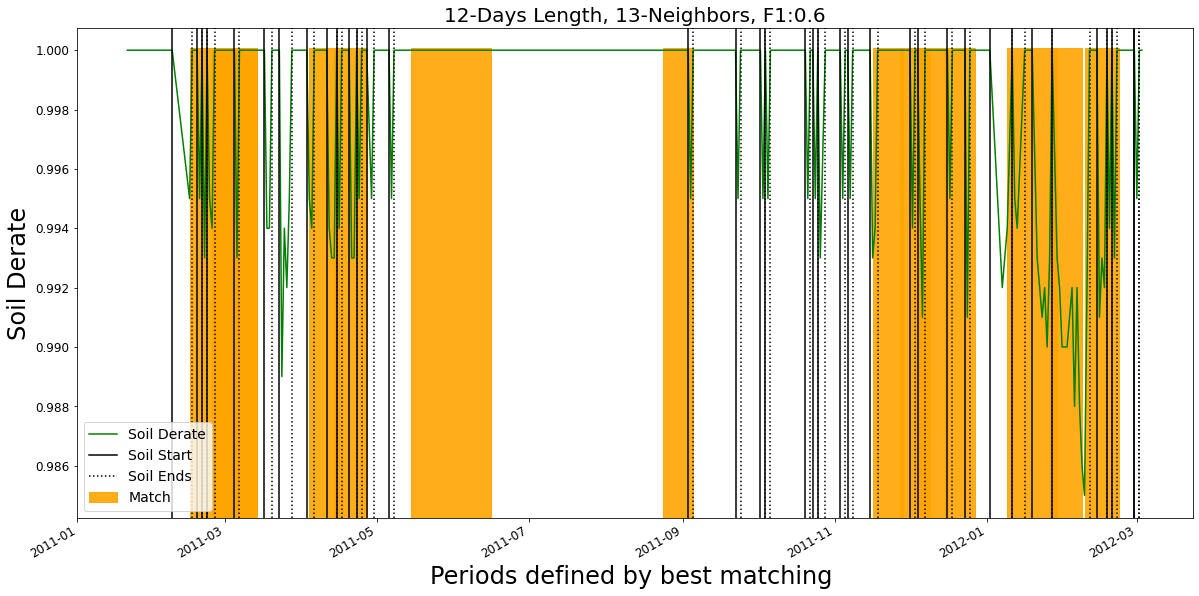

              precision    recall  f1-score   support

         0.0       0.75      0.70      0.72       202
         1.0       0.57      0.63      0.60       129

    accuracy                           0.67       331
   macro avg       0.66      0.67      0.66       331
weighted avg       0.68      0.67      0.68       331



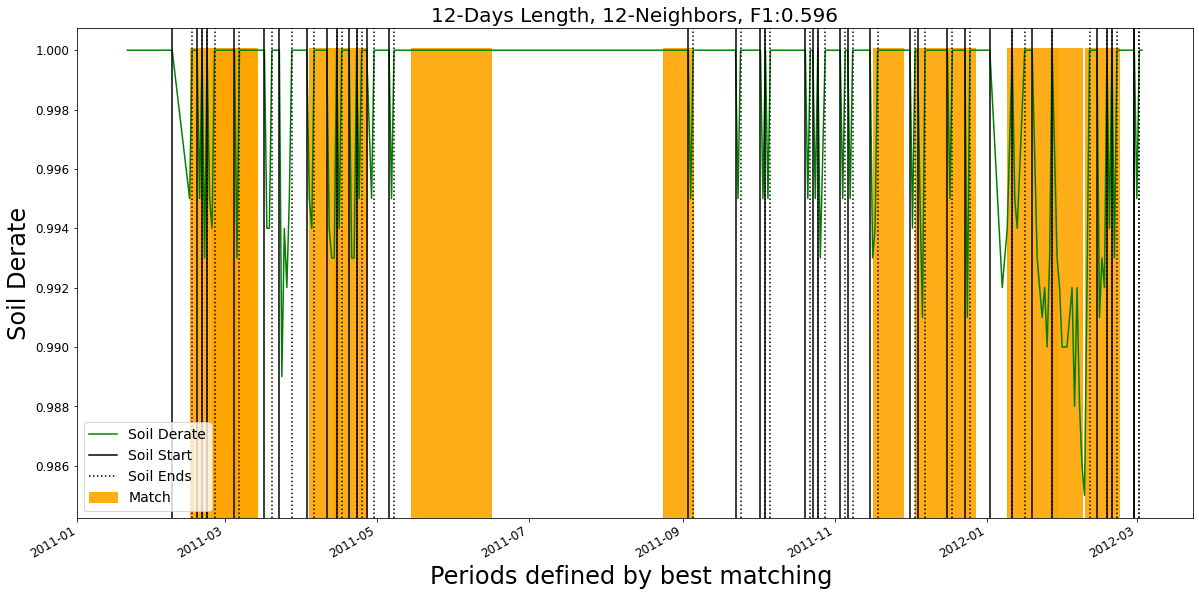

              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73       202
         1.0       0.58      0.61      0.60       129

    accuracy                           0.68       331
   macro avg       0.66      0.67      0.66       331
weighted avg       0.68      0.68      0.68       331

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`


In [9]:
files=['eugene.csv',
       'cocoa.csv']
count=1
for i,file in enumerate(files):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
    print(f'{count}/{len(files)}')
    print(file)
    count=count+1
    filename = file
    df=pd.read_csv(filename)
    df['timestamp']=pd.to_datetime(df['timestamp'])
    df=df.set_index('timestamp')
    #testing step
    if file=='golden.csv':
      df=df.loc[:'2013-06-24']

      df.soiling_derate[0]=1
      df.soiling_derate[1]=1

    df.soiling_derate[-1]=1
    ##testing step
    print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
    print(f'Shape of our Timeseries: {df.shape}')
    df_soil_output=soiling_dates(df,y=x,plot=False)
#     print(f'Here we observe the exact dates which a soiling interval starts and stops')
#     print(df_soil_output)
    events=len(df_soil_output)
    df_new=df
    out,df_last=matching_eval(col,df_old,df_new,alles_df=end_df[end_df.f1>0.5],
                              events=len(df_soil_output),df_soil_output=df_soil_output,
                              n=len(end_df[end_df.f1>0.5]),plot=False)
    # df_last.to_csv(f'/home/pgidarakos/Genetic/Eugene/indirect_eval_{i}_deliv.csv',columns=df_last.columns,index=False)
    print(df_last.head(6))
    match_graph_multi_dim_eval(col,df_new,df_old,df_soil_output=df_soil_output,alles_df=df_last,n=2,plot=True)

    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")

### MP based pattrn discovery

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
eugene.csv
1/2
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (355, 7)
We found 27 Soiling Events with decay less than 0.999 


   min_nei  max_d  cutoff  max_m  max_motif  profile_wind  exclusion_zone  \
0        0   3.35    3.90     24          8            10             5.0   
1        1   2.40    2.37     25          9             7             4.0   
2        1   2.17    2.01     26         11             7             5.0   
3        1   2.68    1.84     25         10             7             8.0   
4        0   3.40    2.18     25          8            10             5.0   

         f1   jaccard    recall   hamming      pres  motif_type  
0  0.633987  0.464115  0.723881  0.315493  0.563953           4  
1  0.627586  0.457286  0.679104  0.304225  0.583333           8  
2  0.626016  0.455621  0.574627  0.259155  0.687500           8  
3  0.625850  0.455446  0.686567  0.309859  0.575000          10  
4  0.625806  0.455399  0.723881  0.326761  0.551136           4  


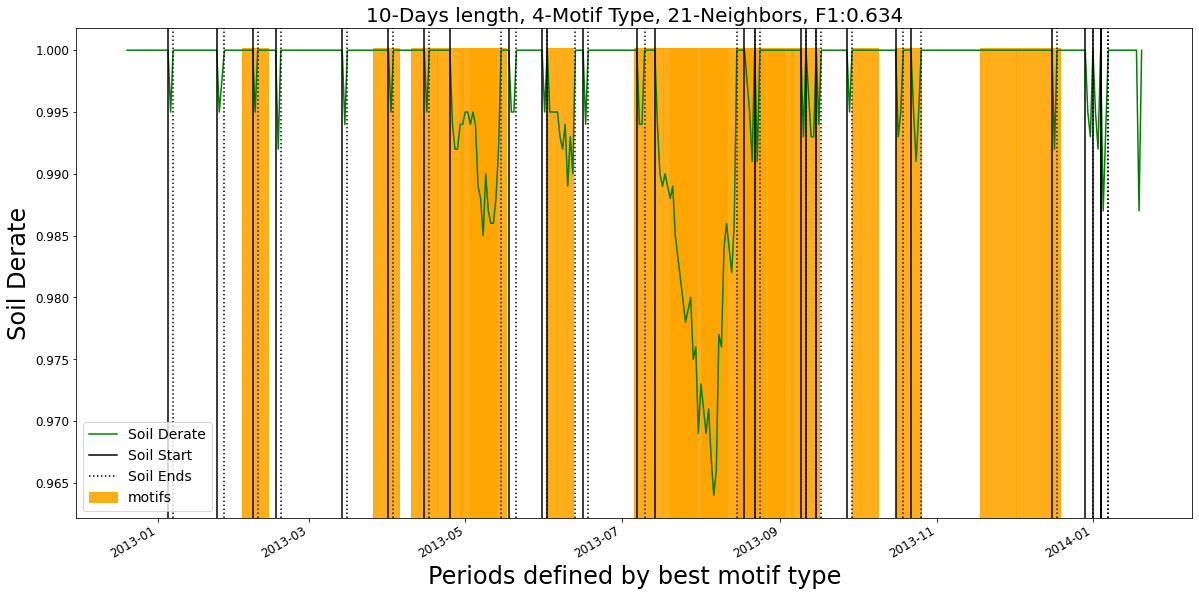

              precision    recall  f1-score   support

         0.0       0.80      0.66      0.72       221
         1.0       0.56      0.72      0.63       134

    accuracy                           0.68       355
   macro avg       0.68      0.69      0.68       355
weighted avg       0.71      0.68      0.69       355



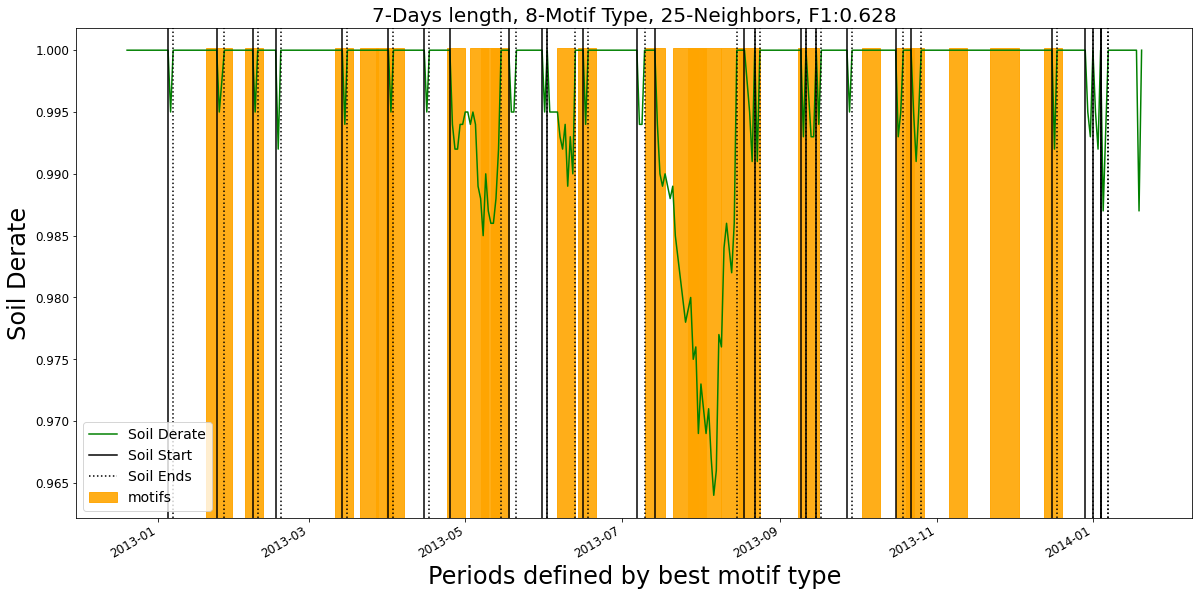

              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74       221
         1.0       0.58      0.68      0.63       134

    accuracy                           0.70       355
   macro avg       0.68      0.69      0.69       355
weighted avg       0.71      0.70      0.70       355

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cocoa.csv
2/2
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (331, 7)
We found 36 Soiling Events with decay less than 0.999 


   min_nei  max_d  cutoff  max_m  max_motif  profile_wind  exclusion_zone  \
0        0   3.48    3.29     25          8            12             6.0   
1        1   4.04    3.27     25          9            11             4.0   
2        1   3.50    2.45     25          9            12             6.0   
3        1   2.97    2.62     28          9             8             8.0   
4        1   3.60    3.29     25          8            11             5.0   

         f1   jaccard    recall   hamming      pres  motif_type  
0  0.601266  0.429864  0.753968  0.380665  0.500000           8  
1  0.598870  0.427419  0.841270  0.429003  0.464912           4  
2  0.596273  0.424779  0.761905  0.392749  0.489796           8  
3  0.587097  0.415525  0.722222  0.386707  0.494565           8  
4  0.584527  0.412955  0.809524  0.438066  0.457399           4  


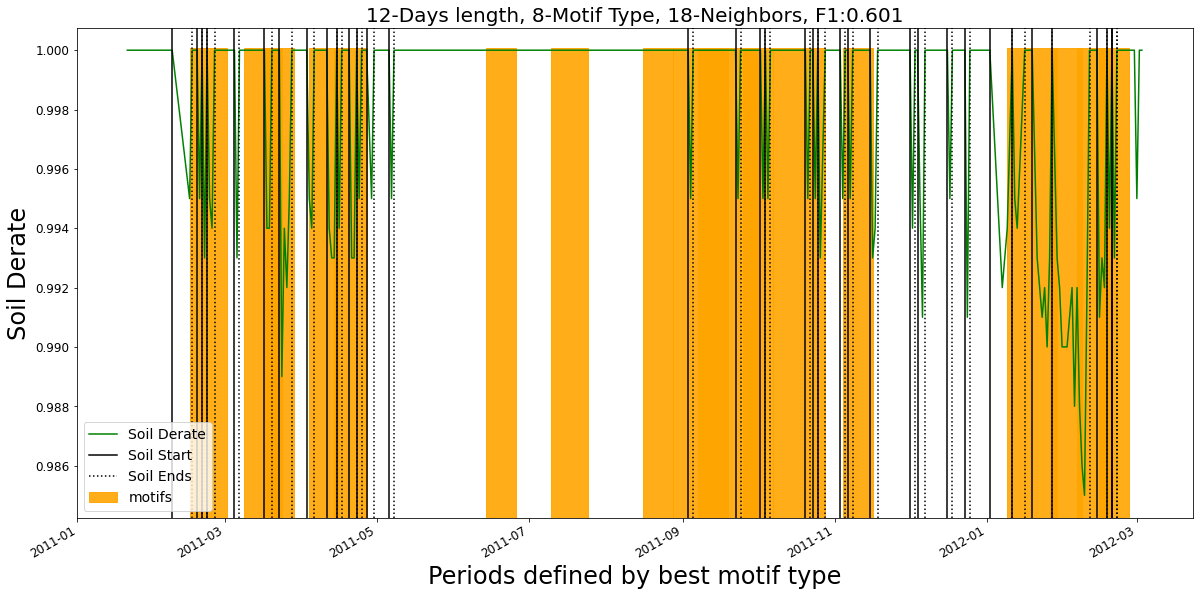

              precision    recall  f1-score   support

         0.0       0.78      0.54      0.64       205
         1.0       0.50      0.75      0.60       126

    accuracy                           0.62       331
   macro avg       0.64      0.65      0.62       331
weighted avg       0.67      0.62      0.62       331



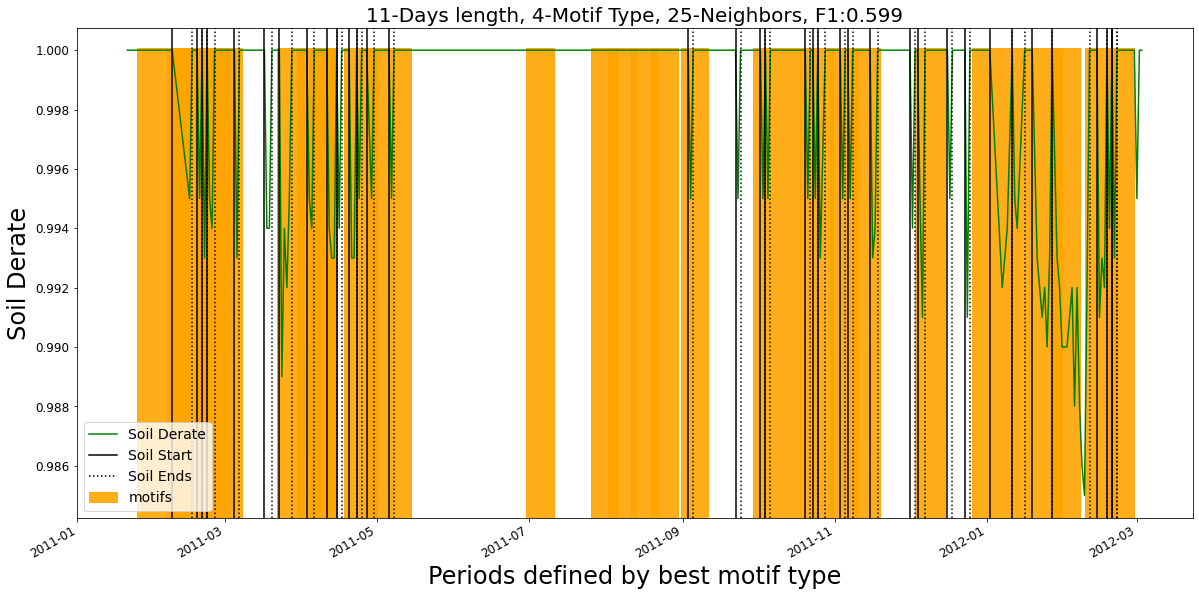

              precision    recall  f1-score   support

         0.0       0.81      0.40      0.54       205
         1.0       0.46      0.84      0.60       126

    accuracy                           0.57       331
   macro avg       0.64      0.62      0.57       331
weighted avg       0.68      0.57      0.56       331

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [10]:
files=['eugene.csv',
       'cocoa.csv']
count=1
for i,file in enumerate(files):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(file)
    print(f'{count}/{len(files)}')
    count=count+1
    filename = file
    df=pd.read_csv(filename)
    df['timestamp']=pd.to_datetime(df['timestamp'])
    df=df.set_index('timestamp')
    #testing step
    if file=='golden.csv':
        df=df.loc[:'2013-06-24']

        df.soiling_derate[0]=1
        df.soiling_derate[1]=1

    df.soiling_derate[-1]=1
    ##testing step
    print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
    print(f'Shape of our Timeseries: {df.shape}')
    df_soil_output=soiling_dates(df,y=x,plot=False)
    df_soil_output=df_soil_output[:-1]
#     print(f'Here we observe the exact dates which a soiling interval starts and stops')
#     print(df_soil_output)
    events=len(df_soil_output)
    eval_df,_,_=evaluate_motifs(col,df,df_soil_output,alles_df=end_df[['min_nei', 'max_d', 'cutoff', 'max_m', 'max_motif', 'profile_wind','exclusion_zone']])
    eval_df=pd.concat([end_df[['min_nei', 'max_d', 'cutoff', 'max_m', 'max_motif', 'profile_wind','exclusion_zone']],eval_df],axis=1)
    eval_df=eval_df.loc[eval_df[['f1']].drop_duplicates(['f1']).index]
    eval_df=eval_df.sort_values(by='f1',ascending=False)
    eval_df=eval_df.reset_index(drop=True)
    print(eval_df.head())
    # eval_df.to_csv(f'/home/pgidarakos/Genetic/Eugene/direct_eval_{i}_deliv.csv',columns=eval_df.columns,index=False)

    motif_graph_multi_dim_eval(col=col,df=df,
                      df_soil_output=df_soil_output,
                      alles_df=eval_df,n=2,plot=True)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")